<a href="https://colab.research.google.com/github/Shaunak-Mukherjee/ControlNet-ECE570-project/blob/main/ME697_07_homework_Shaunak_final_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pysindy
!pip install derivative
!pip install optax
!pip install equinox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 2.7 MB/s eta 0:00:00


In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('png')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks");
from scipy.integrate import odeint
from derivative import dxdt
import optax
from functools import partial
import numpy as np
import jax
import equinox as eqx
from sklearn.preprocessing import PolynomialFeatures
import jax.numpy as jnp
from tqdm import trange
import time
import scipy
from scipy.linalg import svd
from scipy import signal
from sklearn.preprocessing import StandardScaler
from scipy.signal import savgol_filter

# Homework 7

## References

+ Module 5: Inverse problems in deterministic scientifc models
    - Purely data-driven learning of dynamical systems

+ Module 6: Physics-informed neural networks
   - PINNs basics
   - PINNs for parametric studies
   - PINNs for inverse problems

<!-- + Module 7: Inverse problems in stochastic scientific models
    - Stochastic differential equations -->

## Instructions

+ Type your name and email in the "Student details" section below.
+ Develop the code and generate the figures you need to solve the problems using this notebook.
+ For the answers that require a mathematical proof or derivation you should type them using latex. If you have never written latex before and you find it exceedingly difficult, we will likely accept handwritten solutions.
+ The total homework points are 100. Please note that the problems are not weighed equally.

## Student details

+ **First Name: Shaunak**
+ **Last Name: Mukherjee**
+ **Email: mukher86@purdue.edu**
+ **Used generative AI to complete this assignment (Yes/No): Yes**
+ **Which generative AI tool did you use (if applicable)?: ChatGPT**

# Problem 1 - Partially Observed Lorenz System

In [54]:
import numpy as np
import scipy

sigma = 10.0
rho = 28.0
beta = 8.0 / 3.0
dt = 0.01
num_steps = int(20.0 / dt)
ts = np.linspace(0, 100, num_steps)
x0 = np.array([-8.0, 7.0, 27.0])

def vector_field(x, t):
    return (
        sigma * (x[1] - x[0]),
        x[0] * (rho - x[2]) - x[1],
        x[0] * x[1] - beta * x[2]
    )
xs = scipy.integrate.odeint(vector_field, x0, ts)

# Find the exact derivatives - no noise
from jax import vmap, jit
vf = jit(vmap(vector_field, in_axes=(0, 0)))
dxs = np.array(vf(xs, ts)).T

The data you should use are these:

In [55]:
partial_xs = xs[:, 0]
partial_dxs = dxs[:, 0]

## Part A - Applying SINDY on a partially observed system

Try to apply SINDY on `partial_xs` and `partial_dxs`.
Just try to express the right-hand-side of the dynamics using a high order polynomial.
Do not use anything fancier as there is no way this can work.
Demonstrate using some validation data that this doesn't work.

**Answer:**<br> (Ref SINDy function- https://predictivesciencelab.github.io/advanced-scientific-machine-learning/inverse/data/03_sindy_2.html)


In [56]:
# as many code blocks and markdown blocks as you want

# Partially observed data reshape
partial_xs_reshaped = xs[:, 0].reshape(-1, 1)
partial_dxs_reshaped = dxs[:, 0].reshape(-1, 1)

# Split for train and validation
split = partial_xs_reshaped.shape[0] // 2
x_train, dx_train = partial_xs_reshaped[:split], partial_dxs_reshaped[:split]
x_val, dx_val = partial_xs_reshaped[split:], partial_dxs_reshaped[split:]
ts_val = ts[split:]


# SINDy function
def sparsify_dynamics(Phi, dxs, alpha, max_iter=100):
    if dxs.ndim == 1:
        dxs = dxs.reshape(-1, 1)
    thetas = np.linalg.lstsq(Phi, dxs, rcond=None)[0]
    n_out = dxs.shape[1]
    for _ in range(max_iter):
        small = np.abs(thetas) < alpha
        thetas[small] = 0
        for i in range(n_out):
            biginds = ~small[:, i]
            thetas[biginds, i] = np.linalg.lstsq(Phi[:, biginds], dxs[:, i], rcond=None)[0]
    return thetas

# Apply SINDy on the partially observed data
poly = PolynomialFeatures(degree=5)
Phi_train = poly.fit_transform(x_train)

# Fit SiNDy
thetas = sparsify_dynamics(Phi_train, dx_train, alpha=1e-6)
# To look at the coefficients:
for j in range(thetas.shape[1]):
    print(f"Dynamics of x_{j+1}:")
    print("-" * 20)
    for i, name in enumerate(poly.get_feature_names_out()):
        print(f"{name:>6s} = {thetas[i][j]:.4e}")

# Learned right-hand side for x
def f_learned(x, t, thetas, poly):
    phi = poly.fit_transform(x.reshape(1, -1)).flatten()
    dx = np.zeros(x.shape[0])
    for j in range(x.shape[0]):
        dx[j] = np.dot(thetas[:, j], phi)
    return dx

# Simulate learned dynamics on validation
partial_x0_val = x_val[0, 0]
xs_learned = scipy.integrate.odeint(f_learned, partial_x0_val, ts_val, args = (thetas, poly))

# Compute validation error
mse_val = np.mean((x_val.flatten() - xs_learned.flatten())**2)
print(f"Validation MSE: {mse_val:.2f}")

Dynamics of x_1:
--------------------
     1 = 2.7692e-01
    x0 = -1.2291e-01
  x0^2 = 3.7028e-03
  x0^3 = 1.0764e-03
  x0^4 = -2.3349e-05
  x0^5 = -2.3121e-06
Validation MSE: 82.82


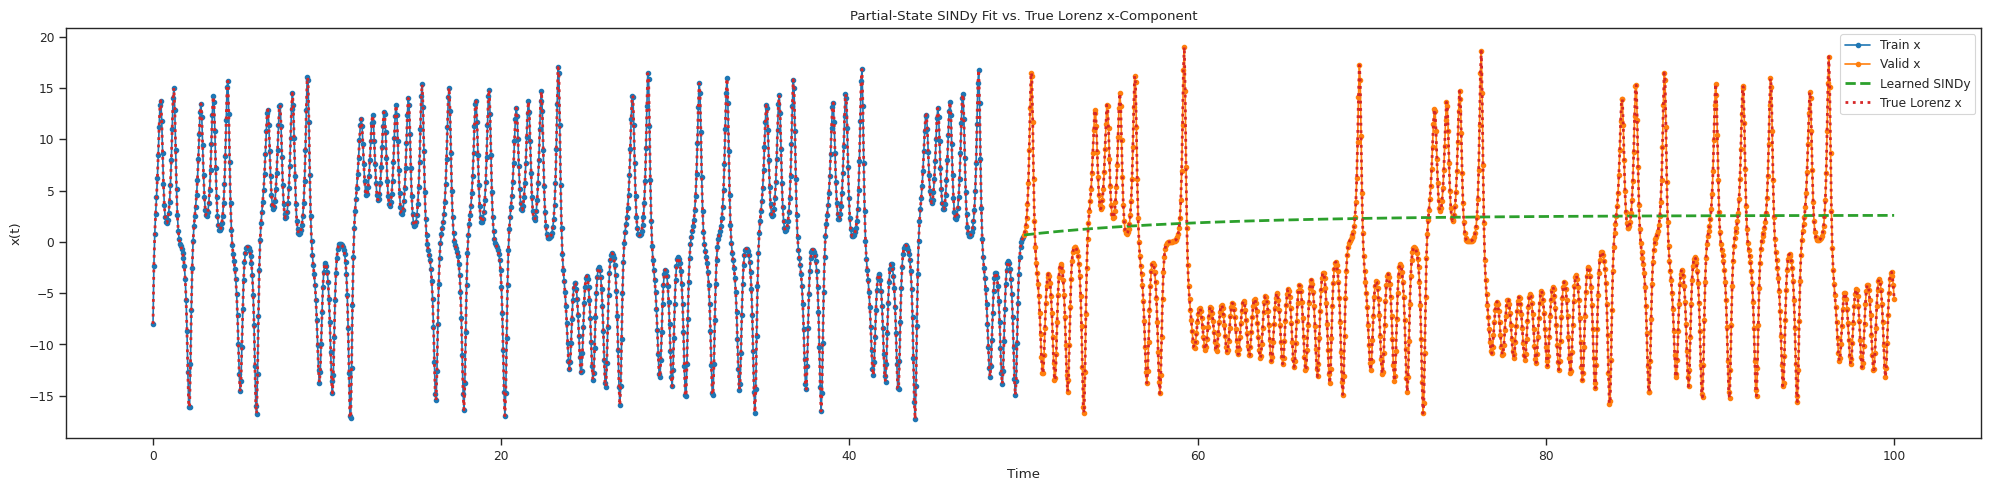

In [57]:
# Plotting with validation data
ts_train = ts[:split]
ts_val   = ts[split:]
x_true   = xs[:, 0]

plt.figure(figsize=(20, 5))

# training data
plt.plot(ts_train, x_train.flatten(),
         linestyle='-', marker='o', markersize=3, label='Train x')

# validation data
plt.plot(ts_val, x_val.flatten(),
         linestyle='-', marker='o', markersize=3, label='Valid x')

# learned SINDy model on validation
plt.plot(ts_val, xs_learned.flatten(),
         linestyle='--', linewidth=2, label='Learned SINDy')

# true Lorenz x‐component
plt.plot(ts, x_true,
         linestyle=':', linewidth=2, label='True Lorenz x')

plt.xlabel('Time')
plt.ylabel('x(t)')
plt.title('Partial‐State SINDy Fit vs. True Lorenz x‐Component')
plt.legend(loc='upper right')
plt.grid(False)
plt.tight_layout()
plt.show()

## Part B - The Hankel Matrix

Part A failed because we tried to fit Markovian dynamics to a partially observed state.
There are no Markovian dynamics for partially observed states.
Partially observed states exhibit effective dynamics that appear to have memory (and noise).
The Hankel matrix is a way to create variables that account for memory.
We will try two variations.
First, we will just try to learn dynamics directly on the columns of the Hankel matrix.
This is not going to work if the memory we need is long.
Then, we will use SVD to reduce the dimensionality of the Hankel matrix before attempting to learn the dynamics.

Your data are $x(t_1),\dots,x(t_m)$.
The Hankel matrix is:

$$
\mathbf{H}_\ell = \begin{bmatrix}
x(t_1) & x(t_2) & x(t_3) & \dots x(t_{m-\ell})\\
x(t_2) & x(t_3) & x(t_4) & \dots x(t_{m-\ell+1})\\
\vdots & \vdots & \vdots & \dots \vdots\\
x(t_\ell) & x(t_{\ell+1}) & x(t_{\ell+3}) \dots & x(t_m)
\end{bmatrix}
$$

Write a function that forms the Hankel matrix given the data and $\ell$.

**Answer:**

In [58]:
def make_hankel(xs, ell):
    """Write a good docstring."""
    # write your code here
    # pass
    xs = np.asarray(xs)
    m = xs.shape[0]
    if not (1 <= ell <= m):
        raise ValueError(f"ell must be between 1 and {m}, got {ell}")

    n_cols = m - ell + 1
    H = np.empty((ell, n_cols), dtype=xs.dtype)
    for i in range(ell):
        H[i, :] = xs[i : i + n_cols]
    return H

## Part C - Apply SINDY on the Hankel matrix

Form the Hankel matrices for $x(t)$ and $\dot{x}(t)$ for $\ell=5$.
Try to represent the dynamics with a third degree polynomial.
Validate your results.
Do not expect this work very well.

**Answer:**
<br>
Ref of functions used here- https://predictivesciencelab.github.io/advanced-scientific-machine-learning/inverse/data/03_sindy_2.html

In [59]:
# as many code blocks and markdown blocks as you want

# Form Hankel matrices for x(t) and x'(t) for l=5
ell = 5

# Create Hankel matrices
H_x = make_hankel(partial_xs, ell) # 5x1996
H_dx = make_hankel(partial_dxs, ell) # 5x1996

ts_H = ts[ell-1:] # 1996 (adjusted)

# Split for train and validation
n_cols     = H_x.shape[1] # 1996
split_cols = n_cols // 2 # 998

H_x_train = H_x[:, :split_cols] # 5x998
H_dx_train= H_dx[:, :split_cols] # 5x998
H_x_val   = H_x[:, split_cols:] # 5x998
H_dx_val  = H_dx[:, split_cols:] # 5x998
ts_val_H  = ts_H[split_cols:] # 998

# Reshape
x_train_H = H_x_train.T  # 998x5
dx_train_H= H_dx_train.T # 998x5
x_val_H   = H_x_val.T # 998x5
dx_val_H  = H_dx_val.T # 998x5


degree = 3 # As per the problem
# Apply polynomial features

poly_H = PolynomialFeatures(degree=degree)
Phi_train_H = poly_H.fit_transform(x_train_H) # 998x56

alpha = 1e-2
iter =1000

# Apply SINDY to learn dynamics
thetas_H = sparsify_dynamics(Phi_train_H, dx_train_H, alpha=alpha, max_iter=iter)

for j in range(thetas_H.shape[1]):
    print(f"Dynamics of x_{j+1}:")
    print("-" * 20)
    for i, name in enumerate(poly_H.get_feature_names_out()):
        print(f"{name:10s} = {thetas_H[i][j]:.2f}")


# integrate over the validation time-grid

def f_learned_H(x, t, thetas, poly):
    phi = poly.fit_transform(x.reshape(1, -1)).flatten()
    dx = np.zeros(x.shape[0])
    for j in range(x.shape[0]):
        dx[j] = np.dot(thetas[:, j], phi)
    return dx

xs_learned = scipy.integrate.odeint(lambda x, t: f_learned_H(x, t, thetas_H, poly_H), x_val_H[0], ts_val_H)
# Compute MSE between the learned and true validation data
mse_H = np.mean((x_val_H.flatten() - xs_learned.flatten())**2)

# Print the MSE
print(f"Hankel‐SINDy validation MSE (l={ell}, deg={degree}): {mse_H:.4e}")

Dynamics of x_1:
--------------------
1          = 0.00
x0         = -47.00
x1         = 102.99
x2         = -94.66
x3         = 48.25
x4         = -9.69
x0^2       = 0.00
x0 x1      = 0.00
x0 x2      = 0.00
x0 x3      = 0.00
x0 x4      = 0.00
x1^2       = 0.00
x1 x2      = 0.00
x1 x3      = 0.00
x1 x4      = 0.00
x2^2       = 0.00
x2 x3      = 0.00
x2 x4      = 0.00
x3^2       = 0.00
x3 x4      = 0.00
x4^2       = 0.00
x0^3       = 0.05
x0^2 x1    = -0.38
x0^2 x2    = 0.43
x0^2 x3    = -0.31
x0^2 x4    = 0.06
x0 x1^2    = 0.88
x0 x1 x2   = -1.58
x0 x1 x3   = 1.11
x0 x1 x4   = -0.13
x0 x2^2    = 0.72
x0 x2 x3   = -1.49
x0 x2 x4   = 0.36
x0 x3^2    = 0.68
x0 x3 x4   = -0.39
x0 x4^2    = 0.00
x1^3       = -1.27
x1^2 x2    = 4.38
x1^2 x3    = -2.72
x1^2 x4    = 0.33
x1 x2^2    = -6.05
x1 x2 x3   = 9.03
x1 x2 x4   = -1.92
x1 x3^2    = -3.44
x1 x3 x4   = 1.86
x1 x4^2    = -0.07
x2^3       = 2.62
x2^2 x3    = -5.68
x2^2 x4    = 0.93
x2 x3^2    = 4.04
x2 x3 x4   = -1.78
x2 x4^2    = 0.12
x3^3

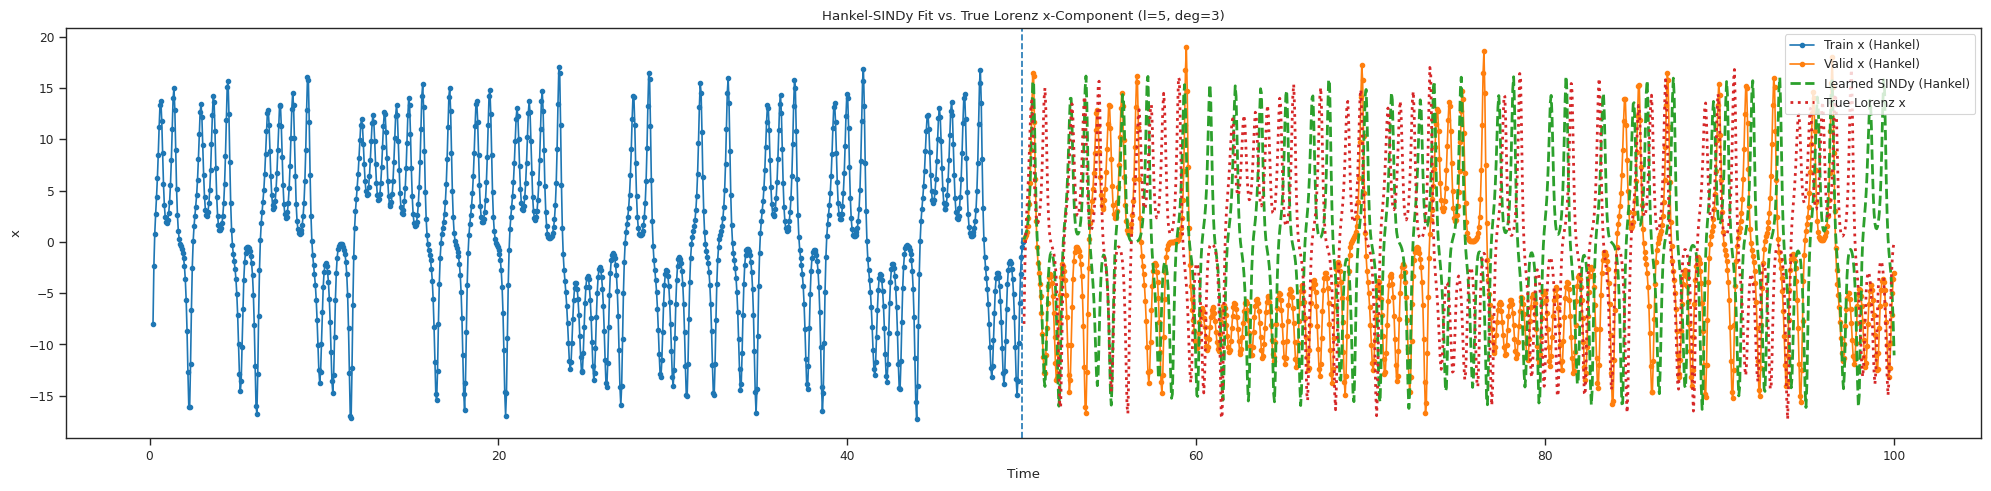

In [60]:
# Same way compare with validation set
ts_train = ts_H[:split_cols]
ts_val   = ts_H[split_cols:]
x_true_aligned = x_true[:len(ts_val_H)]

plt.figure(figsize=(20, 5))

# Training data (first component of x_train_H)
plt.plot(ts_train, x_train_H[:, 0],
         linestyle='-', marker='o', markersize=3, label='Train x (Hankel)')

# Validation data (first component of x_val_H)
plt.plot(ts_val, x_val_H[:, 0],
         linestyle='-', marker='o', markersize=3, label='Valid x (Hankel)')

# Learned SINDy model on validation
plt.plot(ts_val, xs_learned[:, 0],
         linestyle='--', linewidth=2, label='Learned SINDy (Hankel)')

# True Lorenz x‐component
plt.plot(ts_val_H, x_true_aligned ,
         linestyle=':', linewidth=2, label='True Lorenz x')
plt.axvline(50, linestyle = "--")

plt.xlabel('Time')
plt.ylabel('x')
plt.title(f'Hankel-SINDy Fit vs. True Lorenz x-Component (l={ell}, deg={degree})')
plt.legend(loc='upper right')
plt.grid(False)
plt.tight_layout()
plt.show()

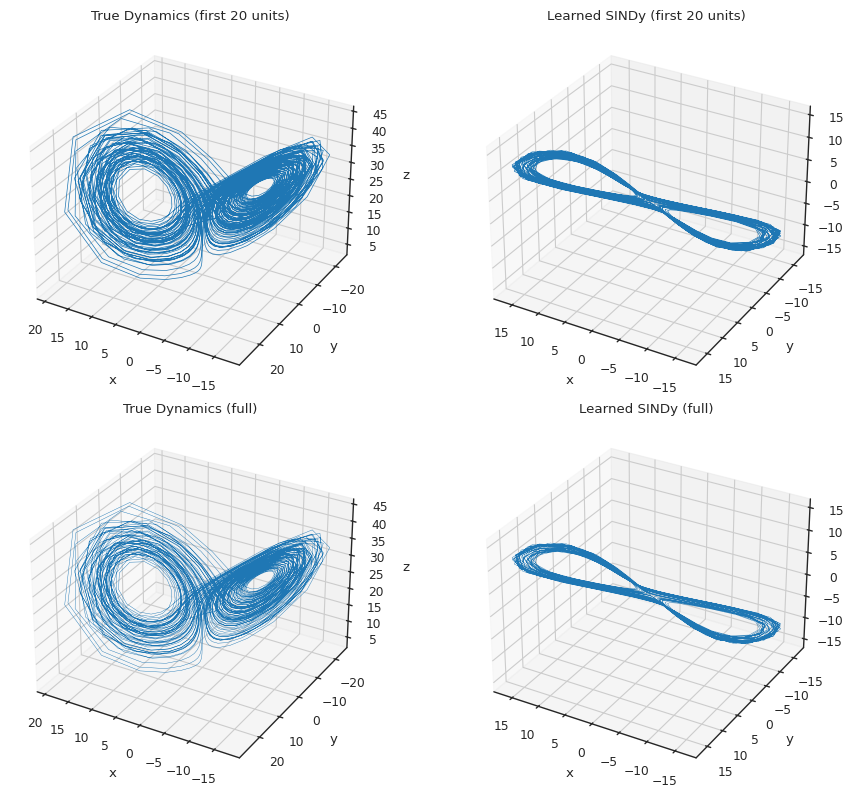

In [61]:
steps = int(20 / dt)
fig = plt.figure(figsize=(10, 8))

# True Dynamics, short
ax1 = fig.add_subplot(2, 2, 1, projection='3d')
ax1.plot(xs[:steps, 0], xs[:steps, 1], xs[:steps, 2], lw=0.5)
ax1.set(title='True Dynamics (first 20 units)',
        xlabel='x', ylabel='y', zlabel='z')
ax1.view_init(30, 120)

# Learned Dynamics, short
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
ax2.plot(xs_learned[:steps, 0], xs_learned[:steps, 1], xs_learned[:steps, 2], lw=0.5)
ax2.set(title='Learned SINDy (first 20 units)',
        xlabel='x', ylabel='y', zlabel='z')
ax2.view_init(30, 120)

# True Dynamics, full
ax3 = fig.add_subplot(2, 2, 3, projection='3d')
ax3.plot(xs[:, 0], xs[:, 1], xs[:, 2], lw=0.3)
ax3.set(title='True Dynamics (full)',
        xlabel='x', ylabel='y', zlabel='z')
ax3.view_init(30, 120)

# Learned Dynamics, full
ax4 = fig.add_subplot(2, 2, 4, projection='3d')
ax4.plot(xs_learned[:, 0], xs_learned[:, 1], xs_learned[:, 2], lw=0.3)
ax4.set(title='Learned SINDy (full)',
        xlabel='x', ylabel='y', zlabel='z')
ax4.view_init(30, 120)

plt.tight_layout()
plt.show()

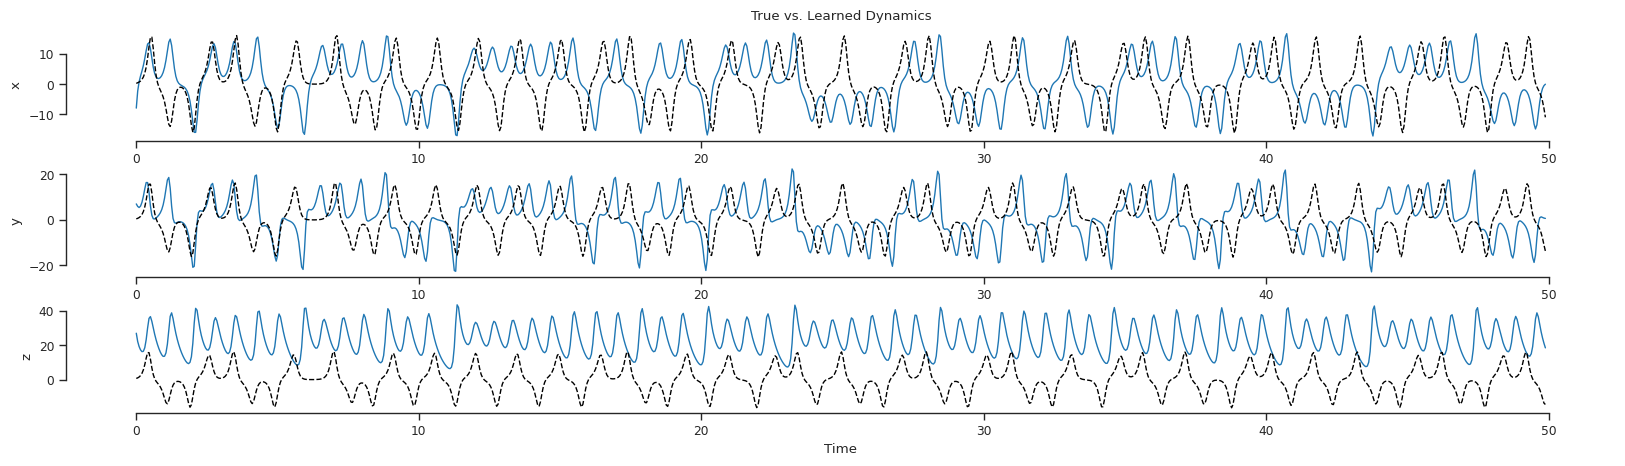

In [62]:
fig = plt.figure(figsize=(20, 5))
ax1 = fig.add_subplot(311)
steps = int(20/dt)
steps = min(steps, xs_learned.shape[0])

# plot data
ax1.plot(ts[:steps], xs[:steps, 0], lw=1.0, label='True Dynamics')
ax1.plot(ts[:steps], xs_learned[:steps, 0], 'k--', lw=1.0, label='Learned Dynamics')
ax1.set(xlabel='Time', ylabel='x', title='True vs. Learned Dynamics')
sns.despine(trim=True);
ax2 = fig.add_subplot(312)
steps = min(steps, xs_learned.shape[0])
ax2.plot(ts[:steps], xs[:steps, 1], lw=1.0, label='True Dynamics')
ax2.plot(ts[:steps], xs_learned[:steps, 1], 'k--', lw=1.0, label='Learned Dynamics')
ax2.set(xlabel='Time', ylabel='y')
ax3 = fig.add_subplot(313)
steps = min(steps, xs_learned.shape[0])
ax3.plot(ts[:steps], xs[:steps, 2], lw=1.0, label='True Dynamics')
ax3.plot(ts[:steps], xs_learned[:steps, 2], 'k--', lw=1.0, label='Learned Dynamics')
ax3.set(xlabel='Time', ylabel='z')
sns.despine(trim=True);

## Part D - Do SVD on the Hankel matrix

Let's pick a big $\ell$. Say $\ell = 100$:
+ Form the corresponding Hankel matrix and then do SVD on it.
+ Plot the explained variance as a function of the number of singular values.
+ How much variance do you explain with three dimensions (this is the intrinsic dimensionality of the dynamical system)?
+ Visualize the first three POD modes.
+ Project the Hankel matrix columns to three dimensions (POD amplitudes/principal components).
+ Plot the time series of each one of the principal components.
+ Plot the 3D trajectory of the principal components.

**Answer:**

In [63]:
# as many code blocks and markdown blocks as you want

ell = 100 # provided
# Form Hankel matrix
H_x = make_hankel(partial_xs, ell) # 100x1901

# Perform SVD
U, S, Vt = np.linalg.svd(H_x, full_matrices=False) # Shape of S, 100

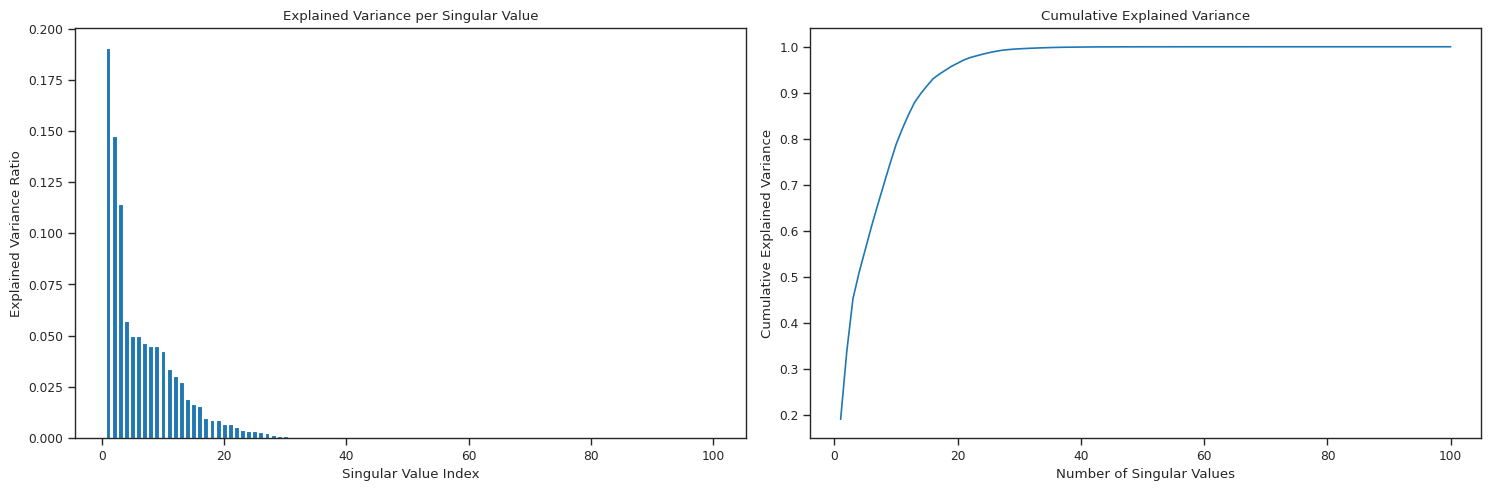

In [64]:
# Calculate the explained variance as the square of the singular values
total_variance = np.sum(S**2)
explained_variance = S**2 / total_variance

# Calculate cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance)

# Plot explained variance
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.bar(range(1, ell + 1), explained_variance)
plt.xlabel('Singular Value Index')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance per Singular Value')

plt.subplot(1, 2, 2)
plt.plot(range(1, ell + 1), cumulative_explained_variance)
plt.xlabel('Number of Singular Values')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')
plt.grid(False)
plt.tight_layout()

In [65]:
# # Variance explained by the first three dimensions
variance_explained_3d = cumulative_explained_variance[2]
print(f"Variance explained by the first 3 dimensions: {variance_explained_3d:.4f}")

Variance explained by the first 3 dimensions: 0.4525


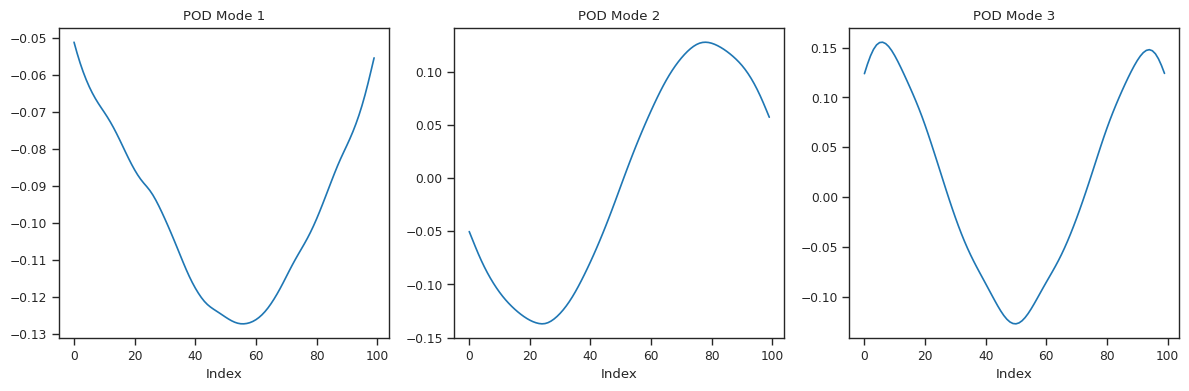

In [66]:
# Visualize first three POD modes
plt.figure(figsize=(12, 4))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.plot(U[:, i])
    plt.title(f'POD Mode {i+1}')
    plt.xlabel('Index')
plt.tight_layout()

(100, 3)


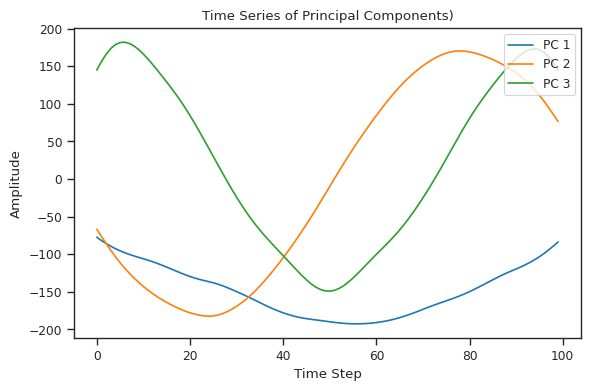

In [67]:
# Project Hankel matrix columns to three dimensions
pod_amplitudes = U[:, :3] @ np.diag(S[:3])
print(pod_amplitudes.shape)
plt.figure(figsize=(6, 4))

for i in range(3):
    plt.plot(pod_amplitudes[:, i], label=f'PC {i+1}')
plt.title('Time Series of Principal Components)')
plt.xlabel('Time Step')
plt.ylabel('Amplitude')
plt.legend(loc='upper right')
plt.grid(False)
plt.tight_layout()
plt.show()

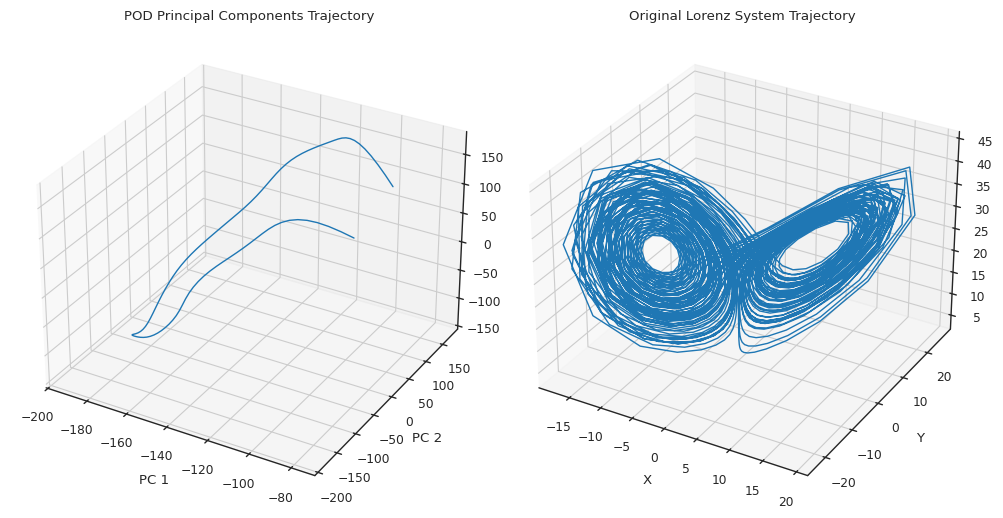

In [68]:
fig = plt.figure(figsize=(10, 8))
# POD trajectory
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(
    pod_amplitudes[:, 0],
    pod_amplitudes[:, 1],
    pod_amplitudes[:, 2],
    lw=1.0  # line width
)
ax1.set_xlabel('PC 1')
ax1.set_ylabel('PC 2')
ax1.set_zlabel('PC 3')
ax1.set_title('POD Principal Components Trajectory')

# Original Lorenz
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(
    xs[:, 0],
    xs[:, 1],
    xs[:, 2],
    lw=1.0
)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title('Original Lorenz System Trajectory')
plt.tight_layout()
plt.show()


## Part E - Find the time derivatives of the principal components of the Hankel matrix

To do SINDY, we need to have time derivatives.
So, you have to find the time derivatives of the principal components of the Hankel matrix.
You have two options:
+ Work out analytically how the observed `partial_dxs` will project on the POD modes, or;
+ Use numerical differentiation to find the required time derivatives (Google around for the best Python library for numerical differentiation). In this case, simple finite differences should work.

**Answer:**

100


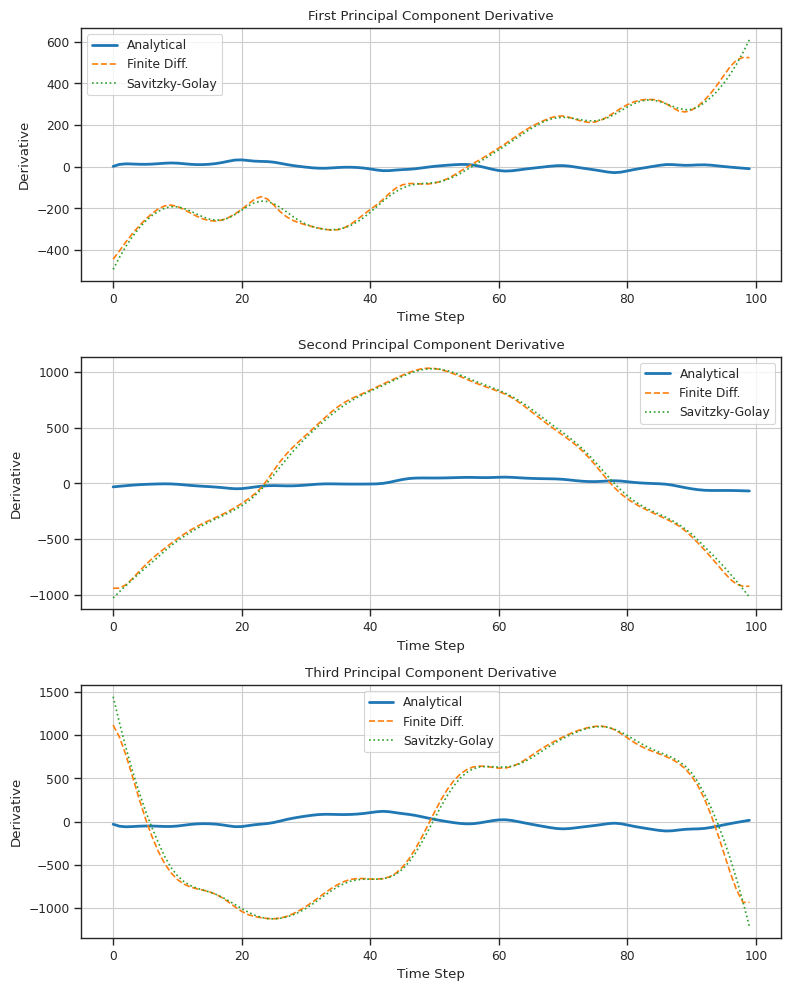

Correlation between analytical and numerical methods:
Component 1:
Simple finite differences: -0.3640
Savitzky-Golay filter: -0.3613
Component 2:
Simple finite differences: 0.7706
Savitzky-Golay filter: 0.7786
Component 3:
Simple finite differences: -0.5036
Savitzky-Golay filter: -0.5262


In [69]:
# Ask is to find the time derivatives of the principal components of the Hankel
# matrix using two options
print(ell)
# Option1: Analytical approach
H_dx = make_hankel(partial_dxs, ell)

# Project tonto the POD modes as instructed
pod_derivatives_analytical = U.T @ H_dx

# Extract the first 3 components for SINDy
pod_derivatives_analytical_3d = pod_derivatives_analytical[:3, :]
# print(pod_derivatives_analytical_3d.shape)

# Option 2: Numerical differentiation
pod_amplitudes = U[:, :3] @ np.diag(S[:3]) # Copied codeblock from part D

# First try: Simple finite differences
dt = 0.01 # Given
pod_derivatives_numerical_simple = np.zeros_like(pod_amplitudes)
pod_derivatives_numerical_simple[:-1] = (pod_amplitudes[1:] - pod_amplitudes[:-1]) / dt # forward
pod_derivatives_numerical_simple[-1] = (pod_amplitudes[-1] - pod_amplitudes[-2]) / dt # backward

# Second try: Using derivative library
window_length = 15  # must be odd
poly_order = 3  # polynomial order for the filter
pod_derivatives_savgol = np.zeros_like(pod_amplitudes)

for i in range(3):
    pod_derivatives_savgol[:, i] = signal.savgol_filter(
        pod_amplitudes[:, i], window_length, poly_order, deriv=1, delta=dt
    )

# Plot and compare the different derivatives
plt.figure(figsize=(8, 10))
components = ['First', 'Second', 'Third']
methods = ['Analytical', 'Finite Diff.', 'Central Diff.', 'Savitzky-Golay']

# Plot all methods
for i in range(3):
    plt.subplot(3, 1, i+1)
    analytical = pod_derivatives_analytical[i, :ell]
    plt.plot(analytical, label=methods[0], linewidth=2)
    plt.plot(pod_derivatives_numerical_simple[:ell, i], label=methods[1], linestyle='--')
    plt.plot(pod_derivatives_savgol[:ell, i], label=methods[3], linestyle=':')

    plt.title(f'{components[i]} Principal Component Derivative')
    plt.xlabel('Time Step')
    plt.ylabel('Derivative')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# Calculate the correlation between analytical and numerical methods
print("Correlation between analytical and numerical methods:")
for i in range(3):
    analytical = pod_derivatives_analytical[i, :ell]
    corr_simple = np.corrcoef(analytical, pod_derivatives_numerical_simple[:ell, i])[0, 1]
    corr_savgol = np.corrcoef(analytical, pod_derivatives_savgol[:ell, i])[0, 1]

    print(f"Component {i+1}:")
    print(f"Simple finite differences: {corr_simple:.4f}")
    print(f"Savitzky-Golay filter: {corr_savgol:.4f}")

## Part F - Do SINDY on the principal components of the Hankel matrix

You are now ready to do SINDY on the principal components of the Hankel matrix.
Use a polynomial of degree 5 as the right-hand-side.
Try to validate your results.

**Answer:**

dPC1/dt = -1.340e+01*PC1 + -7.356e+00*PC2 + 5.726e+00*PC3 + 2.564e+00*PC1^2 + 1.704e+00*PC1 PC2 + -1.294e+00*PC1 PC3 + -2.477e-01*PC2^2 + -1.403e-01*PC2 PC3 + -2.069e-01*PC3^2 + 1.321e+01*PC1^3 + 8.045e+00*PC1^2 PC2 + -8.963e+00*PC1^2 PC3 + 4.417e+00*PC1 PC2^2 + -1.184e+00*PC1 PC2 PC3 + 3.917e+00*PC1 PC3^2 + 1.652e+00*PC2^3 + -2.697e-01*PC2^2 PC3 + 2.524e+00*PC2 PC3^2 + -7.418e-01*PC3^3 + -1.283e+00*PC1^4 + -1.794e-01*PC1^3 PC2 + 8.935e-01*PC1^3 PC3 + 6.261e-01*PC1^2 PC2^2 + 3.449e-01*PC1^2 PC2 PC3 + -9.129e-02*PC1^2 PC3^2 + -8.071e-02*PC1 PC2^3 + -4.730e-01*PC1 PC2^2 PC3 + -6.612e-01*PC1 PC2 PC3^2 + -4.529e-02*PC1 PC3^3 + 5.596e-02*PC2^4 + 5.943e-02*PC2^3 PC3 + 3.383e-02*PC2^2 PC3^2 + 4.687e-02*PC2 PC3^3 + 3.622e-02*PC3^4 + -3.334e+00*PC1^5 + -5.429e-01*PC1^4 PC2 + 2.959e+00*PC1^4 PC3 + 3.357e-01*PC1^3 PC2^2 + 9.954e-01*PC1^3 PC2 PC3 + -1.675e+00*PC1^3 PC3^2 + -5.087e-01*PC1^2 PC2^3 + -8.326e-01*PC1^2 PC2^2 PC3 + -3.019e+00*PC1^2 PC2 PC3^2 + 3.542e-01*PC1^2 PC3^3 + -2.446e-01*PC1 PC2^

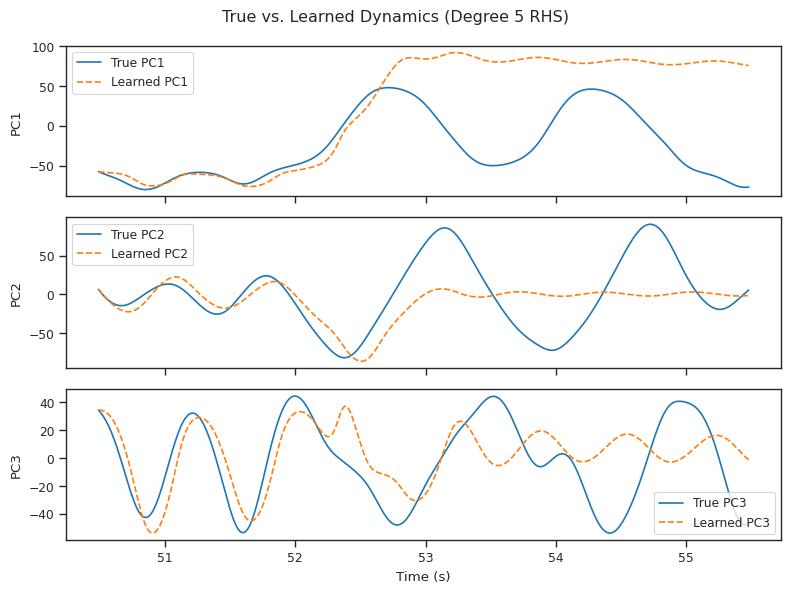

In [86]:
# Simulate Lorenz
sigma, rho, beta = 10.0, 28.0, 8.0/3.0
dt, T = 0.01, 100.0
ts = np.arange(0, T, dt)
x0 = np.array([-8.0, 7.0, 27.0])

def vector_field(x, t):
    return [
        sigma*(x[1] - x[0]),
        x[0]*(rho - x[2]) - x[1],
        x[0]*x[1] - beta*x[2]
    ]

xs = odeint(vector_field, x0, ts)
partial_xs = xs[:, 0]   # we’ll use x-component for Hankel

# Build Hankel of length ell
def make_hankel(x, ell):
    x = np.asarray(x)
    m = len(x)
    if not (1 <= ell <= m):
        raise ValueError(f"ell must be 1..{m}")
    n_cols = m - ell + 1
    return np.vstack([x[i : i + n_cols] for i in range(ell)])

ELL = 100 # *****************


H_x  = make_hankel(partial_xs, ELL)
ts_H = ts[ELL-1:]

# SVD to top-k PCs
U, S, Vt = np.linalg.svd(H_x, full_matrices=False)
k = 3
X_pc = (np.diag(S) @ Vt).T[:, :k]

# Split train/test
M = X_pc.shape[0]
split = M//2
X_train, X_test = X_pc[:split], X_pc[split:]
ts_train, ts_test = ts_H[:split], ts_H[split:]

# Standardize
scaler    = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

# Derivative estimation (blend spline & Savitzky–Golay)
def estimate_derivative(y, t, smooth=1.0):
    try:
        # if you have dxdt available:
        d1 = dxdt(y, t,
                  kind="spline",
                  s=smooth,
                  method="smoothed_finite_difference")
    except NameError:
        d1 = np.gradient(y, t)
    d2 = savgol_filter(y,
                       window_length=51,
                       polyorder=3, # *****************
                       deriv=1, # *****************
                       delta=t[1]-t[0])
    return 0.5*d1 + 0.5*d2

Xdot = np.zeros_like(X_train_s)
for i in range(k):
    Xdot[:, i] = estimate_derivative(X_train_s[:, i], ts_train)

# 7) Build 5th‑degree library
DEGREE = 5 # Fixed
poly   = PolynomialFeatures(degree=DEGREE, include_bias=False)
Phi    = poly.fit_transform(X_train_s)
feat_names = poly.get_feature_names_out([f"PC{j+1}" for j in range(k)])

# 8) Sequential‑threshold SINDy
def sparsify_dynamics(Phi, dXdt, alpha, max_iter=10):
    Theta = np.linalg.lstsq(Phi, dXdt, rcond=None)[0]
    for _ in range(max_iter):
        small = np.abs(Theta) < alpha
        Theta[small] = 0
        for j in range(dXdt.shape[1]):
            big = ~small[:, j]
            if big.sum() > 0:
                Theta[big, j] = np.linalg.lstsq(Phi[:, big],
                                                 dXdt[:, j],
                                                 rcond=None)[0]
    return Theta

ALPHA = 0.025 # *****************
MAXit =100 # *****************
Theta = sparsify_dynamics(Phi, Xdot, alpha=ALPHA, max_iter=MAXit)

# Print the discovered ODEs
for j in range(k):
    terms = [(feat_names[i], Theta[i,j])
             for i in range(Theta.shape[0])
             if abs(Theta[i,j]) > 1e-6]
    eqn = " + ".join(f"{coef:.3e}*{name}"
                     for name, coef in terms)
    print(f"dPC{j+1}/dt = {eqn}")

# Define learned RHS for integration
def f_learned(X, t, Theta, poly):
    Phi = poly.transform(X.reshape(1, -1)).flatten()
    return (Theta.T @ Phi)

# Simulate on test set & eval
t_short = ts_test[:500]
X0_s    = X_test_s[0]
X_pred_s = odeint(f_learned,
                  X0_s,
                  t_short,
                  args=(Theta, poly))
X_pred  = scaler.inverse_transform(X_pred_s)
true_short = X_test[:500]

mses = np.mean((true_short - X_pred)**2, axis=0)
corrs = [np.corrcoef(true_short[:,i], X_pred[:,i])[0,1]
         for i in range(k)]
for i in range(k):
    print(f"PC{i+1} corr = {corrs[i]:.3f}, MSE = {mses[i]:.3f}")
print("Overall MSE =", mses.mean())

# Plot true vs learned
fig, axs = plt.subplots(k,1,figsize=(8,6), sharex=True)
for i in range(k):
    axs[i].plot(t_short, true_short[:,i], '-', label=f"True PC{i+1}")
    axs[i].plot(t_short, X_pred[:,i],   '--', label=f"Learned PC{i+1}")
    axs[i].legend()
    axs[i].set_ylabel(f"PC{i+1}")
axs[-1].set_xlabel("Time (s)")
plt.suptitle("True vs. Learned Dynamics (Degree 5 RHS)")
plt.tight_layout()
plt.show()


# Problem 2 - SINDY with measurement noise and no derivatives

Let's get back to the Lorenz system. This time, we are going to assume that we have access to the full state, but we do not have the derivative, and the measurements are corrupted by noise.
So, your available data are:

In [71]:
eta = 0.01
noisy_x = xs + eta * np.random.normal(0, 1.0, xs.shape)

Review the package [derivative](https://pypi.org/project/derivative/) (which part of the `pysindy` ecosystem) and:
- Use a suitable method to estimate the derivative dx/dt from the noisy data `noisy_xs`.
- Apply SINDY to the denoised data and the numerical derivatives.
- Validate your results.

**Answer:**


Validation MSE (x,y,z): ['125.197', '160.936', '123.597']
Validation correlation (x,y,z): ['0.037', '0.036', '-0.023']


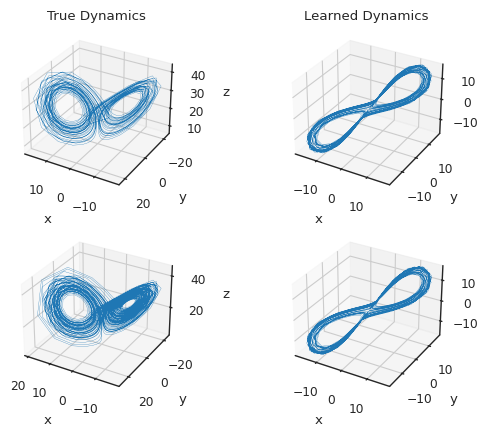

<Figure size 2000x1200 with 0 Axes>

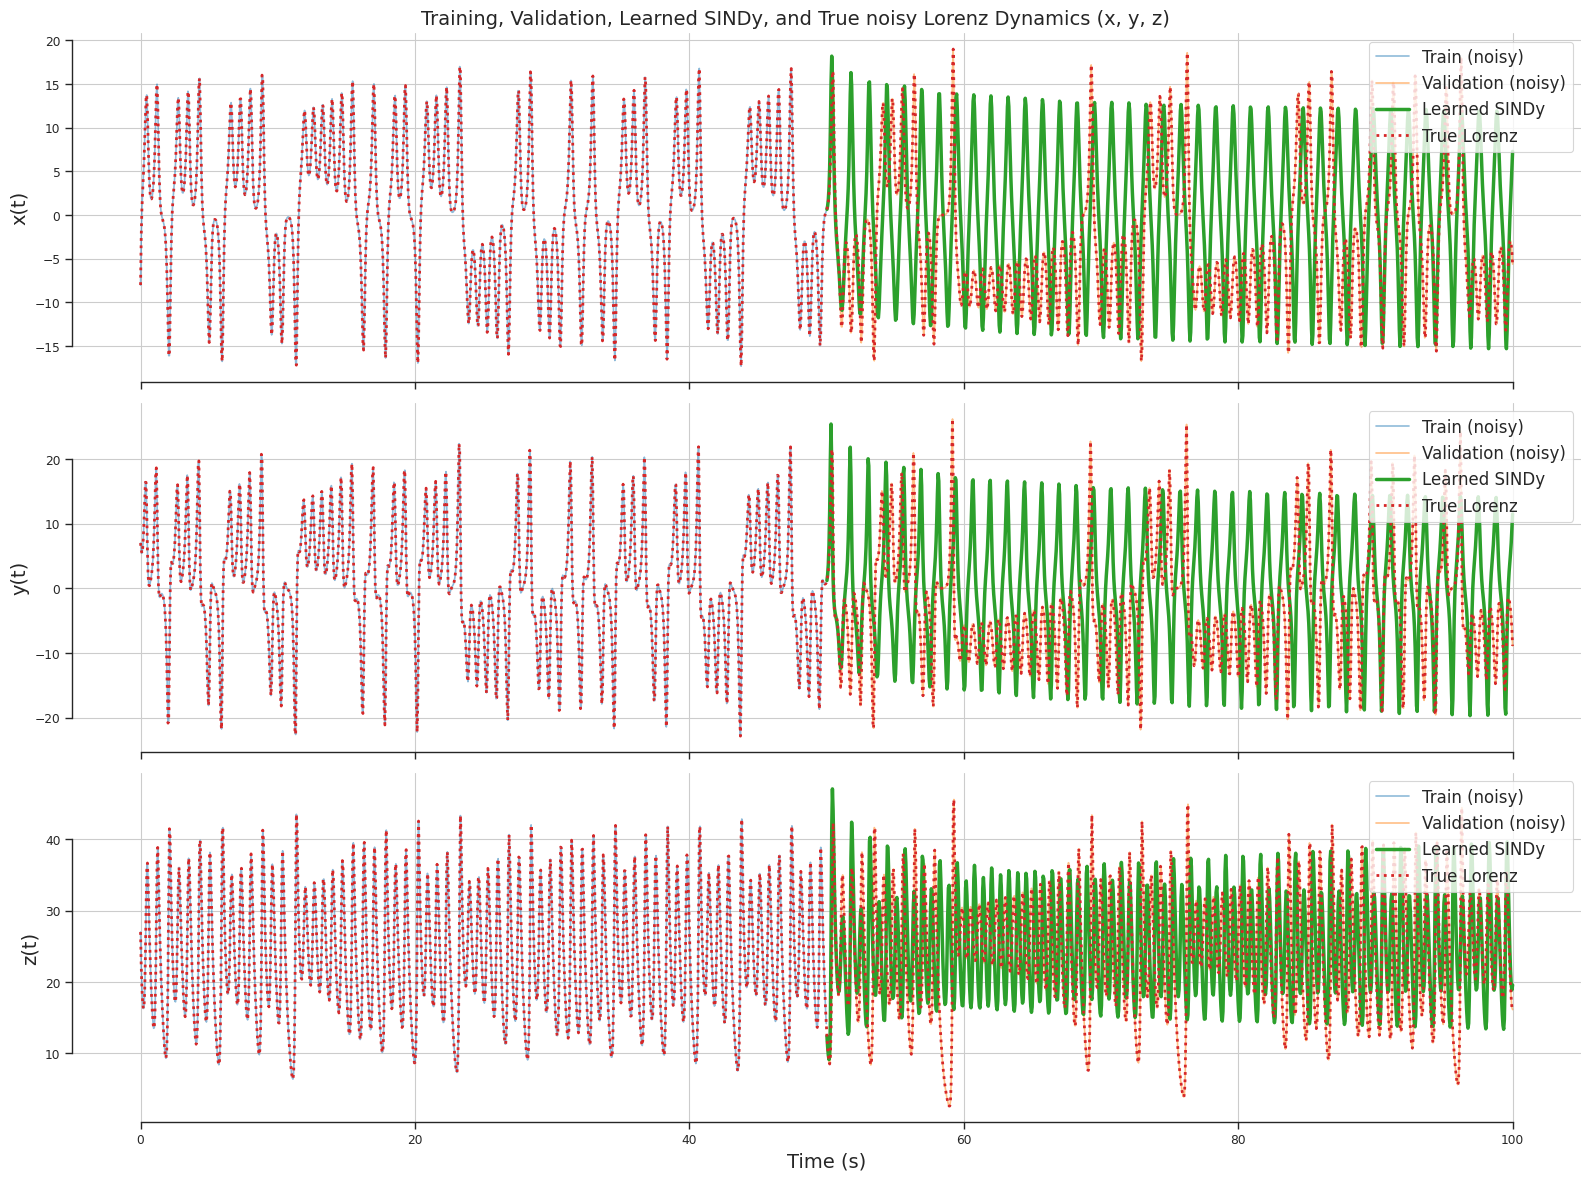

In [72]:
from derivative import dxdt

ell = 100

# Estimate derivatives from noisy data using the derivative package
# https://pypi.org/project/derivative/ Method 4

dim = 3

# Use Savitzky-Golay filter to compute derivatives
dxs_estimated = np.zeros_like(noisy_x)
for i in range(dim):
    dxs_estimated[:, i] = dxdt(
        noisy_x[:, i],
        ts,
        kind="spline",
        s=1e-1,
        method="smoothed_finite_difference"
    )


# Split time domain
split_idx = noisy_x.shape[0] // 2

# Training set
x_train = noisy_x[:split_idx]
dxdt_train = dxs_estimated[:split_idx]
t_train = ts[:split_idx]

# Validation set
x_val_true = xs[split_idx:]
noisy_x_val = noisy_x[split_idx:]
t_val = ts[split_idx:]


# Build feature library on noisy_x
poly = PolynomialFeatures(degree=5)
Phi_train = poly.fit_transform(x_train)

alpha = 5e-2
iter =10000

# Sparse regression
thetas_noisy = sparsify_dynamics(Phi_train, dxdt_train, alpha=alpha, max_iter=iter)

# Initial condition
x0_val = noisy_x[split_idx]

# Simulate learned system on validation
x_val_learned_full = scipy.integrate.odeint(lambda x, t: f_learned(x, t, thetas_noisy, poly), x0_val, t_val)

# Validate
# Compute validation errors
mse_val = np.mean((x_val_true - x_val_learned_full)**2, axis=0)
corrs_val = [np.corrcoef(x_val_true[:,i], x_val_learned_full[:,i])[0,1] for i in range(3)]

print(f"\nValidation MSE (x,y,z): {[f'{x:.3f}' for x in mse_val]}")
print(f"Validation correlation (x,y,z): {[f'{x:.3f}' for x in corrs_val]}")
# 3D plots
fig = plt.figure()
ax1 = fig.add_subplot(221, projection='3d')

steps = x_val_learned_full.shape[0]
ax1.plot(xs[:steps, 0], xs[:steps, 1], xs[:steps, 2], lw=0.2)
ax1.set(xlabel='x', ylabel='y', zlabel='z', title='True Dynamics')
ax1.view_init(30, 120)

ax2 = fig.add_subplot(222, projection='3d')
ax2.plot(xs_learned[:steps, 0], xs_learned[:steps, 1], xs_learned[:steps, 2], lw=0.2)
ax2.set(xlabel='x', ylabel='y', zlabel='z', title='Learned Dynamics')
ax1.view_init(30, 120)

ax3 = fig.add_subplot(223, projection='3d')
ax3.plot(xs[:, 0], xs[:, 1], xs[:, 2], lw=0.2)
ax3.set(xlabel='x', ylabel='y', zlabel='z')
ax3.view_init(30, 120)

ax4 = fig.add_subplot(224, projection='3d')
ax4.plot(xs_learned[:, 0], xs_learned[:, 1], xs_learned[:, 2], lw=0.2)
ax4.set(xlabel='x', ylabel='y', zlabel='z')
ax3.view_init(30, 120);
fig = plt.figure(figsize=(20, 12))
plt.show()

# Plotting againts training and  validation set

# Split time domain
split_idx = noisy_x.shape[0] // 2

ts_train = ts[:split_idx]
ts_val   = ts[split_idx:]

# Extract true components
x_true = xs[:, 0]
y_true = xs[:, 1]
z_true = xs[:, 2]

# Noisy measurements
x_train = noisy_x[:split_idx, 0]
y_train = noisy_x[:split_idx, 1]
z_train = noisy_x[:split_idx, 2]

x_val = noisy_x[split_idx:, 0]
y_val = noisy_x[split_idx:, 1]
z_val = noisy_x[split_idx:, 2]

x_val_learned = x_val_learned_full[:, 0]
y_val_learned = x_val_learned_full[:, 1]
z_val_learned = x_val_learned_full[:, 2]

fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True)

train_signals = [x_train, y_train, z_train]
val_signals = [x_val, y_val, z_val]
val_learned_signals = [x_val_learned, y_val_learned, z_val_learned]
true_signals = [x_true, y_true, z_true]
components = ['x', 'y', 'z']
# Plot
for i in range(3):
    ax = axes[i]

    # Training data
    ax.plot(ts_train, train_signals[i], linestyle='-',  markersize=3, alpha=0.5, label='Train (noisy)')

    # Validation data
    ax.plot(ts_val, val_signals[i], linestyle='-', markersize=3, alpha=0.5, label='Validation (noisy)')

    # Learned SINDy trajectory
    ax.plot(ts_val, val_learned_signals[i], lw=2.5, label='Learned SINDy')

    # True Lorenz trajectory
    ax.plot(ts, true_signals[i],  ':', lw=2, label='True Lorenz')

    ax.set_ylabel(f'{components[i]}(t)', fontsize=14)
    ax.legend(loc='upper right', fontsize=12)
    ax.grid(True)

axes[-1].set_xlabel('Time (s)', fontsize=14)
plt.suptitle('Training, Validation, Learned SINDy, and True noisy Lorenz Dynamics (x, y, z)', fontsize=14)
plt.tight_layout()
sns.despine(trim=True)
plt.show()


# Problem 3 - Physics-informed Neural Networks for Solving a Neo-Hookean Hyperelasticity Problem

*The original version of this problem was developed by Atharva Hans as a companion to [this](https://youtu.be/o9JaZGWekWQ).

Consider a neo-Hookean square body defined on $(x,y) \in [0,1]^2$. Let $\mathbf{u}(x,y) = (u_1, u_2)$ describe the displacement field for this body.
This body is subjected to the following displacement boundary conditions:

$$
u_1(0,y) = 0,
$$

$$
u_2(0,y) = 0,
$$

$$
u_1(1,y) = \delta,
$$

$$
u_2(1,y) = 0,
$$

with $\delta$ referring to the applied displacement along the x-direction.

For this hyperelastic material, the stored energy $E_b$ in the body can be expressed in as:

$$
E_b[\mathbf{u}(\cdot)] = \int_{[0,1]^2}\left\{\frac{1}{2}(\sum_{i=1}^2\sum_{j=1}^2{F_{ij}^2} - 2)- \ln(\det(\mathbf{F})) + 50\ln(\det(\mathbf{F}))^2\right\} dxdy,
$$

with

$$
\mathbf{F} = \mathbf{I} + \nabla \mathbf{u},
$$

where $\mathbf{I}$ is an identity matrix.

The final orientation of this body is described by a displacement field that minimizes the stored energy $E_b$.
The idea is to use a neural network to approximate the displacement field and train it by minimizing the stored energy $E_b$.

To automatically satisfy the boundary conditions, we will use this approximation:
$$
u_1(x,y) = \delta - \delta(1-x) + x(1-x)N_1(x,y;\theta),
$$
and,
$$
u_2(x,y) = x(1-x)N_2(x,y;\theta)
$$
where $N_1(x,y;\theta)$ and $N_2(x,y;\theta)$ are neural networks.

## Part A

Solve the problem above for $\delta=0.1$ using a physics-informed neural network (PINN).
Use separate neural networks for $N_1(x,y;\theta)$ and $N_2(x,y;\theta)$.
Start with a multi-layer perceptron with 3 hidden layers, each with 128 units, and tanh activations.
Add a Fourier feature layer at the beginning of the network.
Feel free to change the architecture if you think it is necessary.

Use `equinox` for the neural networks and `optax` for the optimization.
Use a sampling average of 32 collocation points to compute the integral of the stored energy.
Use the Adam optimizer with a learning rate of 0.001 for 1000 iterations to debug.
Feel free to play with the learning rate, the number of collocation points, and the number of iterations.

Show the evolution of the loss function over the iterations.
Plot the final displacement field (plot $u_1(x,y)$ and $u_2(x,y)$ separately).

*Put your answer here. Use as many markdown and code blocks as you want.*

In [73]:
class FourierFeatures(eqx.Module):
    """Fourier features for a 2D input.
      input_dim: int
      mapping_size: int
      scale: float
      return: jax.ndarray
    """
    B: jnp.ndarray

    def __init__(self, input_dim=2, mapping_size=256, scale=3.0, key=None):
        if key is None:
            key = jax.random.PRNGKey(0)
        self.B = jax.random.normal(key, (mapping_size, input_dim)) * scale

    def __call__(self, x):
        x_proj = 2 * jnp.pi * x @ self.B.T
        return jnp.concatenate([jnp.sin(x_proj), jnp.cos(x_proj)], axis=-1)

class MLPWithFourier(eqx.Module):
    """Multi-layer perceptron with Fourier features.
    fourier: FourierFeatures
    layers: list
    return: jax.ndarray
      """
    fourier: FourierFeatures
    layers: list

    # Start with a multi-layer perceptron with 3 hidden layers, each with 128 units
    def __init__(self, in_features=2, hidden_features=128, hidden_layers=3, fourier_features=256, key=None):
        """
        in_features: int
        hidden_features: int
        hidden_layers: int
        fourier_features: int
        key: jax.random.PRNGKey
        """

        if key is None:
            key = jax.random.PRNGKey(0)
        key_fourier, key_layers = jax.random.split(key, 2)

        self.fourier = FourierFeatures(input_dim=in_features, mapping_size=fourier_features, key=key_fourier)

        keys = jax.random.split(key_layers, hidden_layers + 1)

        # Hidden layers
        self.layers = []
        in_dim = 2 * fourier_features
        for i in range(hidden_layers):
            layer = eqx.nn.Linear(in_dim, hidden_features, key=keys[i])
            self.layers.append(layer)
            in_dim = hidden_features

        # Output layer
        self.layers.append(eqx.nn.Linear(hidden_features, 1, key=keys[-1]))


    def __call__(self, x):
        """
        x: jax.ndarray
        return: jax.ndarray
        """
        x = self.fourier(x)
        for layer in self.layers[:-1]:
            x = jnp.tanh(layer(x))  #jax.numpy.tanh ?
        x = self.layers[-1](x)
        return x


# Define the displacement field for a single point (non-batched)
def displacement_field_single(x, delta, net1, net2):
    """
    x: jax.ndarray
    delta: float
    net1: MLPWithFourier
    net2: MLPWithFourier
    return: jax.ndarray
    """
    x1 = x[0]
    u1 = delta - delta * (1. - x1) + x1 * (1. - x1) * net1(x).squeeze()
    u2 = x1 * (1. - x1) * net2(x).squeeze()
    return jnp.array([u1, u2])


# Define the displacement field for batched inputs
def displacement_field(x, delta, net1, net2):
    """
    x: jax.ndarray
    delta: float
    net1: MLPWithFourier
    net2: MLPWithFourier
    return: jax.ndarray
    """
    x1 = x[:, 0:1]
    u1 = delta - delta * (1. - x1) + x1 * (1. - x1) * net1(x)
    u2 = x1 * (1. - x1) * net2(x)
    return jnp.concatenate([u1, u2], axis=-1)

# Compute the mean stored energy over sampled collocation points x.
def stored_energy_loss(x, delta, net1, net2):
    """
    x: jax.ndarray
    delta: float
    net1: MLPWithFourier
    net2: MLPWithFourier
    return: jax.ndarray
    """
    batch_size = x.shape[0]

    # Compute jacobians for each point in the batch
    def single_point_jacobian(x_i):
      """
      x_i: jax.ndarray
      return: jax.ndarray
      """
      return jax.jacrev(lambda x_point: displacement_field_single(x_point, delta, net1, net2))(x_i)

    # Apply jacobian computation to each point in the batch
    jacobians = jax.vmap(single_point_jacobian)(x)

    # Compute deformation gradient F = I + grad(u)
    I = jnp.eye(2)
    F = I + jacobians

    # Compute energy density per point
    F_squared = jnp.sum(F**2, axis=(1,2))
    det_F = F[:,0,0]*F[:,1,1] - F[:,0,1]*F[:,1,0]
    epsilon = 1e-6
    log_det_F = jnp.log(jnp.clip(det_F, a_min=epsilon))


    energy_density = 0.5 * (F_squared - 2) - log_det_F + 50.0 * log_det_F**2
    return jnp.mean(energy_density)

@eqx.filter_value_and_grad
def compute_loss(params, x, delta):
    """
    params: tuple
    x: jax.ndarray
    delta: float
    return: jax.ndarray
    """
    net1, net2 = params
    return stored_energy_loss(x, delta, net1, net2)

@eqx.filter_jit
def make_step(params, opt_state, optimizer, delta, key):
    """
    params: tuple
    opt_state: jax.ndarray
    optimizer: jax.ndarray
    delta: float
    key: jax.random.PRNGKey
    return: tuple
    """
    net1, net2 = params
    x = jax.random.uniform(key, (COLLECTION, 2))
    loss_value, grads = compute_loss((net1, net2), x, delta)

    updates, opt_state = optimizer.update(grads, opt_state)
    new_params = eqx.apply_updates((net1, net2), updates)

    return new_params, opt_state, loss_value

# Training function
def train(net1, net2, delta, num_iter= int, lr = int, seed=0, collection_points=int):

    """
    net1: MLPWithFourier
    net2: MLPWithFourier
    delta: float
    num_iter: int
    lr: float
    seed: int
    collection_points: int
    return: tuple
    """
    key = jax.random.PRNGKey(seed)
    params = (net1, net2)
    optimizer = optax.adam(lr)
    opt_state = optimizer.init(params)

    loss_history = []

    print(f"\nStarting training loop...")
    print(f"Right Edge Displacement: {delta:.3f} \t batch_size: {collection_points} \t max_iter: {num_iter}\n")

    start_time = time.time()

    @eqx.filter_value_and_grad
    def compute_loss(params, x, delta):
      """
      params: tuple
      x: jax.ndarray
      delta: float
      return: jax.ndarray
      """
      net1, net2 = params
      return stored_energy_loss(x, delta, net1, net2)

    for step in trange(1, num_iter + 1):
        key, subkey = jax.random.split(key)
        x = jax.random.uniform(subkey, (collection_points, 2))
        loss_value, grads = compute_loss(params, x, delta)
        updates, opt_state = optimizer.update(grads, opt_state)
        params = eqx.apply_updates(params, updates)

        loss_history.append(loss_value.item())

        if step % 10 == 0 or step == 1:
            elapsed = int(time.time() - start_time)
            print(f"[iter: {step:>4}] time elapsed: {elapsed:>3}s  |  Loss = {loss_value.item():.6f}")

    net1_trained, net2_trained = params
    return net1_trained, net2_trained, loss_history

In [74]:
# Set delta
delta = 0.1 # Provided
LEARNING_RATE = 1e-4 # optimized
COLLECTION = 128
MAX_ITER = 2000 # optimize
SEED = 123

# Set random keys
key = jax.random.PRNGKey(SEED)
key1, key2 = jax.random.split(key)

# Initialize networks
net1 = MLPWithFourier(key=key1)
net2 = MLPWithFourier(key=key2)


# Train the model
net1_trained, net2_trained, loss_history = train(net1, net2, delta= delta, num_iter= MAX_ITER, lr= LEARNING_RATE, collection_points =COLLECTION)


Starting training loop...
Right Edge Displacement: 0.100 	 batch_size: 128 	 max_iter: 2000



  0%|          | 2/2000 [00:04<1:08:07,  2.05s/it]

[iter:    1] time elapsed:   4s  |  Loss = 5.189515


  1%|          | 11/2000 [00:06<06:42,  4.94it/s]

[iter:   10] time elapsed:   6s  |  Loss = 1.573189


  1%|          | 21/2000 [00:08<05:25,  6.09it/s]

[iter:   20] time elapsed:   7s  |  Loss = 1.049441


  2%|▏         | 31/2000 [00:09<06:56,  4.72it/s]

[iter:   30] time elapsed:   9s  |  Loss = 0.628682


  2%|▏         | 41/2000 [00:11<05:20,  6.11it/s]

[iter:   40] time elapsed:  11s  |  Loss = 0.514564


  3%|▎         | 51/2000 [00:13<05:21,  6.06it/s]

[iter:   50] time elapsed:  12s  |  Loss = 0.402368


  3%|▎         | 61/2000 [00:14<05:13,  6.19it/s]

[iter:   60] time elapsed:  14s  |  Loss = 0.402333


  4%|▎         | 71/2000 [00:16<05:21,  5.99it/s]

[iter:   70] time elapsed:  16s  |  Loss = 0.329173


  4%|▍         | 81/2000 [00:18<05:21,  5.97it/s]

[iter:   80] time elapsed:  18s  |  Loss = 0.301486


  5%|▍         | 91/2000 [00:19<05:08,  6.18it/s]

[iter:   90] time elapsed:  19s  |  Loss = 0.301085


  5%|▌         | 101/2000 [00:21<05:08,  6.16it/s]

[iter:  100] time elapsed:  21s  |  Loss = 0.219367


  6%|▌         | 111/2000 [00:23<05:08,  6.13it/s]

[iter:  110] time elapsed:  22s  |  Loss = 0.249325


  6%|▌         | 121/2000 [00:24<05:00,  6.26it/s]

[iter:  120] time elapsed:  24s  |  Loss = 0.217176


  7%|▋         | 131/2000 [00:26<05:32,  5.61it/s]

[iter:  130] time elapsed:  26s  |  Loss = 0.177157


  7%|▋         | 141/2000 [00:28<05:16,  5.88it/s]

[iter:  140] time elapsed:  28s  |  Loss = 0.160925


  8%|▊         | 151/2000 [00:29<04:55,  6.26it/s]

[iter:  150] time elapsed:  29s  |  Loss = 0.171855


  8%|▊         | 161/2000 [00:31<05:05,  6.02it/s]

[iter:  160] time elapsed:  31s  |  Loss = 0.131673


  9%|▊         | 171/2000 [00:33<05:00,  6.09it/s]

[iter:  170] time elapsed:  33s  |  Loss = 0.133059


  9%|▉         | 181/2000 [00:34<05:00,  6.06it/s]

[iter:  180] time elapsed:  34s  |  Loss = 0.117030


 10%|▉         | 191/2000 [00:36<04:56,  6.09it/s]

[iter:  190] time elapsed:  36s  |  Loss = 0.105196


 10%|█         | 201/2000 [00:38<04:53,  6.13it/s]

[iter:  200] time elapsed:  37s  |  Loss = 0.116041


 11%|█         | 211/2000 [00:39<05:03,  5.89it/s]

[iter:  210] time elapsed:  39s  |  Loss = 0.094746


 11%|█         | 221/2000 [00:41<05:50,  5.07it/s]

[iter:  220] time elapsed:  41s  |  Loss = 0.095210


 12%|█▏        | 231/2000 [00:43<04:47,  6.16it/s]

[iter:  230] time elapsed:  43s  |  Loss = 0.069284


 12%|█▏        | 241/2000 [00:44<04:48,  6.10it/s]

[iter:  240] time elapsed:  44s  |  Loss = 0.068476


 13%|█▎        | 251/2000 [00:46<04:46,  6.11it/s]

[iter:  250] time elapsed:  46s  |  Loss = 0.065556


 13%|█▎        | 261/2000 [00:48<04:42,  6.17it/s]

[iter:  260] time elapsed:  47s  |  Loss = 0.066913


 14%|█▎        | 271/2000 [00:49<04:49,  5.97it/s]

[iter:  270] time elapsed:  49s  |  Loss = 0.067643


 14%|█▍        | 281/2000 [00:51<04:53,  5.86it/s]

[iter:  280] time elapsed:  51s  |  Loss = 0.048123


 15%|█▍        | 291/2000 [00:53<04:40,  6.08it/s]

[iter:  290] time elapsed:  53s  |  Loss = 0.056194


 15%|█▌        | 301/2000 [00:54<04:44,  5.97it/s]

[iter:  300] time elapsed:  54s  |  Loss = 0.056671


 16%|█▌        | 311/2000 [00:56<04:44,  5.94it/s]

[iter:  310] time elapsed:  56s  |  Loss = 0.049621


 16%|█▌        | 321/2000 [00:58<04:38,  6.03it/s]

[iter:  320] time elapsed:  58s  |  Loss = 0.048197


 17%|█▋        | 331/2000 [01:00<04:38,  5.98it/s]

[iter:  330] time elapsed:  59s  |  Loss = 0.051403


 17%|█▋        | 341/2000 [01:01<04:39,  5.94it/s]

[iter:  340] time elapsed:  61s  |  Loss = 0.055035


 18%|█▊        | 351/2000 [01:03<04:35,  5.98it/s]

[iter:  350] time elapsed:  63s  |  Loss = 0.045650


 18%|█▊        | 361/2000 [01:05<04:29,  6.09it/s]

[iter:  360] time elapsed:  64s  |  Loss = 0.047803


 19%|█▊        | 371/2000 [01:06<04:33,  5.96it/s]

[iter:  370] time elapsed:  66s  |  Loss = 0.043435


 19%|█▉        | 381/2000 [01:08<04:28,  6.03it/s]

[iter:  380] time elapsed:  68s  |  Loss = 0.048697


 20%|█▉        | 391/2000 [01:10<04:29,  5.97it/s]

[iter:  390] time elapsed:  69s  |  Loss = 0.044213


 20%|██        | 401/2000 [01:11<04:29,  5.93it/s]

[iter:  400] time elapsed:  71s  |  Loss = 0.041001


 21%|██        | 411/2000 [01:13<04:27,  5.93it/s]

[iter:  410] time elapsed:  73s  |  Loss = 0.045509


 21%|██        | 421/2000 [01:15<04:33,  5.76it/s]

[iter:  420] time elapsed:  75s  |  Loss = 0.037325


 22%|██▏       | 431/2000 [01:17<05:41,  4.60it/s]

[iter:  430] time elapsed:  76s  |  Loss = 0.049225


 22%|██▏       | 441/2000 [01:18<04:29,  5.79it/s]

[iter:  440] time elapsed:  78s  |  Loss = 0.036421


 23%|██▎       | 451/2000 [01:20<04:22,  5.91it/s]

[iter:  450] time elapsed:  80s  |  Loss = 0.042503


 23%|██▎       | 461/2000 [01:22<04:16,  6.00it/s]

[iter:  460] time elapsed:  81s  |  Loss = 0.038760


 24%|██▎       | 471/2000 [01:23<04:18,  5.91it/s]

[iter:  470] time elapsed:  83s  |  Loss = 0.039156


 24%|██▍       | 481/2000 [01:25<04:18,  5.87it/s]

[iter:  480] time elapsed:  85s  |  Loss = 0.041094


 25%|██▍       | 491/2000 [01:27<04:19,  5.81it/s]

[iter:  490] time elapsed:  87s  |  Loss = 0.036353


 25%|██▌       | 501/2000 [01:28<04:10,  5.98it/s]

[iter:  500] time elapsed:  88s  |  Loss = 0.040429


 26%|██▌       | 511/2000 [01:30<04:10,  5.95it/s]

[iter:  510] time elapsed:  90s  |  Loss = 0.034578


 26%|██▌       | 521/2000 [01:32<04:20,  5.69it/s]

[iter:  520] time elapsed:  92s  |  Loss = 0.034913


 27%|██▋       | 531/2000 [01:34<04:37,  5.30it/s]

[iter:  530] time elapsed:  94s  |  Loss = 0.036149


 27%|██▋       | 541/2000 [01:36<04:09,  5.85it/s]

[iter:  540] time elapsed:  95s  |  Loss = 0.037397


 28%|██▊       | 551/2000 [01:37<04:11,  5.75it/s]

[iter:  550] time elapsed:  97s  |  Loss = 0.036659


 28%|██▊       | 561/2000 [01:39<04:06,  5.83it/s]

[iter:  560] time elapsed:  99s  |  Loss = 0.034022


 29%|██▊       | 571/2000 [01:41<04:09,  5.73it/s]

[iter:  570] time elapsed: 101s  |  Loss = 0.037088


 29%|██▉       | 581/2000 [01:42<04:05,  5.77it/s]

[iter:  580] time elapsed: 102s  |  Loss = 0.035756


 30%|██▉       | 591/2000 [01:44<04:03,  5.78it/s]

[iter:  590] time elapsed: 104s  |  Loss = 0.036763


 30%|███       | 601/2000 [01:46<04:02,  5.76it/s]

[iter:  600] time elapsed: 106s  |  Loss = 0.034490


 31%|███       | 611/2000 [01:48<03:52,  5.98it/s]

[iter:  610] time elapsed: 107s  |  Loss = 0.033856


 31%|███       | 621/2000 [01:49<03:59,  5.75it/s]

[iter:  620] time elapsed: 109s  |  Loss = 0.030723


 32%|███▏      | 631/2000 [01:51<04:10,  5.47it/s]

[iter:  630] time elapsed: 111s  |  Loss = 0.030802


 32%|███▏      | 641/2000 [01:53<03:55,  5.77it/s]

[iter:  640] time elapsed: 113s  |  Loss = 0.040446


 33%|███▎      | 651/2000 [01:55<03:58,  5.66it/s]

[iter:  650] time elapsed: 115s  |  Loss = 0.036453


 33%|███▎      | 661/2000 [01:57<03:52,  5.75it/s]

[iter:  660] time elapsed: 116s  |  Loss = 0.033304


 34%|███▎      | 671/2000 [01:58<03:45,  5.89it/s]

[iter:  670] time elapsed: 118s  |  Loss = 0.031515


 34%|███▍      | 681/2000 [02:00<03:43,  5.91it/s]

[iter:  680] time elapsed: 120s  |  Loss = 0.032043


 35%|███▍      | 691/2000 [02:02<03:58,  5.48it/s]

[iter:  690] time elapsed: 122s  |  Loss = 0.032141


 35%|███▌      | 701/2000 [02:03<03:41,  5.86it/s]

[iter:  700] time elapsed: 123s  |  Loss = 0.030886


 36%|███▌      | 711/2000 [02:05<03:51,  5.57it/s]

[iter:  710] time elapsed: 125s  |  Loss = 0.030427


 36%|███▌      | 721/2000 [02:07<03:45,  5.66it/s]

[iter:  720] time elapsed: 127s  |  Loss = 0.032241


 37%|███▋      | 731/2000 [02:09<04:52,  4.35it/s]

[iter:  730] time elapsed: 129s  |  Loss = 0.030647


 37%|███▋      | 741/2000 [02:11<03:46,  5.56it/s]

[iter:  740] time elapsed: 131s  |  Loss = 0.031855


 38%|███▊      | 751/2000 [02:13<03:49,  5.44it/s]

[iter:  750] time elapsed: 132s  |  Loss = 0.031253


 38%|███▊      | 761/2000 [02:14<03:44,  5.52it/s]

[iter:  760] time elapsed: 134s  |  Loss = 0.033955


 39%|███▊      | 771/2000 [02:16<03:34,  5.72it/s]

[iter:  770] time elapsed: 136s  |  Loss = 0.034066


 39%|███▉      | 781/2000 [02:18<03:30,  5.79it/s]

[iter:  780] time elapsed: 138s  |  Loss = 0.033705


 40%|███▉      | 791/2000 [02:20<03:30,  5.76it/s]

[iter:  790] time elapsed: 140s  |  Loss = 0.029950


 40%|████      | 801/2000 [02:21<03:27,  5.77it/s]

[iter:  800] time elapsed: 141s  |  Loss = 0.032996


 41%|████      | 811/2000 [02:23<03:31,  5.62it/s]

[iter:  810] time elapsed: 143s  |  Loss = 0.034686


 41%|████      | 821/2000 [02:25<03:35,  5.46it/s]

[iter:  820] time elapsed: 145s  |  Loss = 0.031740


 42%|████▏     | 831/2000 [02:27<03:21,  5.80it/s]

[iter:  830] time elapsed: 147s  |  Loss = 0.030002


 42%|████▏     | 841/2000 [02:29<03:57,  4.88it/s]

[iter:  840] time elapsed: 149s  |  Loss = 0.028930


 43%|████▎     | 851/2000 [02:31<03:22,  5.68it/s]

[iter:  850] time elapsed: 150s  |  Loss = 0.030078


 43%|████▎     | 861/2000 [02:32<03:18,  5.74it/s]

[iter:  860] time elapsed: 152s  |  Loss = 0.028852


 44%|████▎     | 871/2000 [02:34<03:17,  5.72it/s]

[iter:  870] time elapsed: 154s  |  Loss = 0.031441


 44%|████▍     | 881/2000 [02:36<03:20,  5.59it/s]

[iter:  880] time elapsed: 156s  |  Loss = 0.028981


 45%|████▍     | 891/2000 [02:38<03:15,  5.66it/s]

[iter:  890] time elapsed: 157s  |  Loss = 0.031399


 45%|████▌     | 901/2000 [02:39<03:11,  5.74it/s]

[iter:  900] time elapsed: 159s  |  Loss = 0.031188


 46%|████▌     | 911/2000 [02:41<03:09,  5.76it/s]

[iter:  910] time elapsed: 161s  |  Loss = 0.029240


 46%|████▌     | 921/2000 [02:43<03:05,  5.82it/s]

[iter:  920] time elapsed: 163s  |  Loss = 0.031581


 47%|████▋     | 931/2000 [02:45<03:04,  5.78it/s]

[iter:  930] time elapsed: 164s  |  Loss = 0.029857


 47%|████▋     | 940/2000 [02:46<03:03,  5.78it/s]

[iter:  940] time elapsed: 166s  |  Loss = 0.031661


 48%|████▊     | 951/2000 [02:48<03:09,  5.54it/s]

[iter:  950] time elapsed: 168s  |  Loss = 0.028499


 48%|████▊     | 961/2000 [02:50<03:08,  5.51it/s]

[iter:  960] time elapsed: 170s  |  Loss = 0.030616


 49%|████▊     | 971/2000 [02:52<03:03,  5.61it/s]

[iter:  970] time elapsed: 172s  |  Loss = 0.029845


 49%|████▉     | 981/2000 [02:54<03:01,  5.62it/s]

[iter:  980] time elapsed: 174s  |  Loss = 0.029417


 50%|████▉     | 991/2000 [02:55<02:58,  5.66it/s]

[iter:  990] time elapsed: 175s  |  Loss = 0.032110


 50%|█████     | 1001/2000 [02:57<02:56,  5.67it/s]

[iter: 1000] time elapsed: 177s  |  Loss = 0.029481


 51%|█████     | 1011/2000 [02:59<02:59,  5.51it/s]

[iter: 1010] time elapsed: 179s  |  Loss = 0.030765


 51%|█████     | 1021/2000 [03:01<02:58,  5.49it/s]

[iter: 1020] time elapsed: 181s  |  Loss = 0.031046


 52%|█████▏    | 1031/2000 [03:03<02:56,  5.49it/s]

[iter: 1030] time elapsed: 183s  |  Loss = 0.028977


 52%|█████▏    | 1041/2000 [03:05<03:05,  5.18it/s]

[iter: 1040] time elapsed: 185s  |  Loss = 0.030519


 53%|█████▎    | 1051/2000 [03:07<02:49,  5.60it/s]

[iter: 1050] time elapsed: 186s  |  Loss = 0.029739


 53%|█████▎    | 1061/2000 [03:08<02:49,  5.54it/s]

[iter: 1060] time elapsed: 188s  |  Loss = 0.029824


 54%|█████▎    | 1071/2000 [03:10<02:45,  5.61it/s]

[iter: 1070] time elapsed: 190s  |  Loss = 0.030114


 54%|█████▍    | 1081/2000 [03:12<02:47,  5.48it/s]

[iter: 1080] time elapsed: 192s  |  Loss = 0.031460


 55%|█████▍    | 1091/2000 [03:14<02:39,  5.71it/s]

[iter: 1090] time elapsed: 194s  |  Loss = 0.031590


 55%|█████▌    | 1101/2000 [03:16<02:39,  5.63it/s]

[iter: 1100] time elapsed: 195s  |  Loss = 0.027430


 56%|█████▌    | 1111/2000 [03:17<02:38,  5.60it/s]

[iter: 1110] time elapsed: 197s  |  Loss = 0.028603


 56%|█████▌    | 1121/2000 [03:19<02:50,  5.16it/s]

[iter: 1120] time elapsed: 199s  |  Loss = 0.029275


 57%|█████▋    | 1131/2000 [03:21<02:34,  5.64it/s]

[iter: 1130] time elapsed: 201s  |  Loss = 0.029938


 57%|█████▋    | 1141/2000 [03:23<02:41,  5.33it/s]

[iter: 1140] time elapsed: 203s  |  Loss = 0.028054


 58%|█████▊    | 1151/2000 [03:25<02:37,  5.40it/s]

[iter: 1150] time elapsed: 205s  |  Loss = 0.027930


 58%|█████▊    | 1161/2000 [03:27<02:29,  5.60it/s]

[iter: 1160] time elapsed: 206s  |  Loss = 0.025564


 59%|█████▊    | 1171/2000 [03:28<02:27,  5.61it/s]

[iter: 1170] time elapsed: 208s  |  Loss = 0.031560


 59%|█████▉    | 1181/2000 [03:30<02:26,  5.61it/s]

[iter: 1180] time elapsed: 210s  |  Loss = 0.026914


 60%|█████▉    | 1191/2000 [03:32<02:26,  5.54it/s]

[iter: 1190] time elapsed: 212s  |  Loss = 0.031858


 60%|██████    | 1201/2000 [03:34<02:25,  5.49it/s]

[iter: 1200] time elapsed: 214s  |  Loss = 0.028256


 61%|██████    | 1211/2000 [03:36<02:25,  5.42it/s]

[iter: 1210] time elapsed: 215s  |  Loss = 0.028999


 61%|██████    | 1221/2000 [03:37<02:18,  5.64it/s]

[iter: 1220] time elapsed: 217s  |  Loss = 0.026108


 62%|██████▏   | 1231/2000 [03:39<02:57,  4.33it/s]

[iter: 1230] time elapsed: 219s  |  Loss = 0.026280


 62%|██████▏   | 1241/2000 [03:41<02:19,  5.45it/s]

[iter: 1240] time elapsed: 221s  |  Loss = 0.027421


 63%|██████▎   | 1251/2000 [03:43<02:20,  5.32it/s]

[iter: 1250] time elapsed: 223s  |  Loss = 0.027157


 63%|██████▎   | 1261/2000 [03:45<02:17,  5.36it/s]

[iter: 1260] time elapsed: 225s  |  Loss = 0.027936


 64%|██████▎   | 1271/2000 [03:47<02:25,  5.02it/s]

[iter: 1270] time elapsed: 227s  |  Loss = 0.028207


 64%|██████▍   | 1281/2000 [03:49<02:12,  5.42it/s]

[iter: 1280] time elapsed: 229s  |  Loss = 0.027092


 65%|██████▍   | 1291/2000 [03:51<02:13,  5.32it/s]

[iter: 1290] time elapsed: 231s  |  Loss = 0.029835


 65%|██████▌   | 1301/2000 [03:53<02:12,  5.28it/s]

[iter: 1300] time elapsed: 232s  |  Loss = 0.027687


 66%|██████▌   | 1311/2000 [03:55<02:10,  5.28it/s]

[iter: 1310] time elapsed: 234s  |  Loss = 0.029145


 66%|██████▌   | 1321/2000 [03:56<02:07,  5.31it/s]

[iter: 1320] time elapsed: 236s  |  Loss = 0.025938


 67%|██████▋   | 1331/2000 [03:58<02:10,  5.11it/s]

[iter: 1330] time elapsed: 238s  |  Loss = 0.029969


 67%|██████▋   | 1341/2000 [04:00<02:20,  4.70it/s]

[iter: 1340] time elapsed: 240s  |  Loss = 0.029385


 68%|██████▊   | 1351/2000 [04:02<02:00,  5.37it/s]

[iter: 1350] time elapsed: 242s  |  Loss = 0.028763


 68%|██████▊   | 1361/2000 [04:04<01:58,  5.41it/s]

[iter: 1360] time elapsed: 244s  |  Loss = 0.029495


 69%|██████▊   | 1371/2000 [04:06<01:56,  5.38it/s]

[iter: 1370] time elapsed: 246s  |  Loss = 0.028638


 69%|██████▉   | 1381/2000 [04:08<01:55,  5.36it/s]

[iter: 1380] time elapsed: 248s  |  Loss = 0.027954


 70%|██████▉   | 1391/2000 [04:10<01:56,  5.22it/s]

[iter: 1390] time elapsed: 250s  |  Loss = 0.030338


 70%|███████   | 1401/2000 [04:12<01:51,  5.39it/s]

[iter: 1400] time elapsed: 252s  |  Loss = 0.029275


 71%|███████   | 1411/2000 [04:14<01:50,  5.32it/s]

[iter: 1410] time elapsed: 253s  |  Loss = 0.028359


 71%|███████   | 1421/2000 [04:15<01:46,  5.44it/s]

[iter: 1420] time elapsed: 255s  |  Loss = 0.029487


 72%|███████▏  | 1431/2000 [04:17<01:45,  5.40it/s]

[iter: 1430] time elapsed: 257s  |  Loss = 0.030806


 72%|███████▏  | 1440/2000 [04:19<01:44,  5.33it/s]

[iter: 1440] time elapsed: 259s  |  Loss = 0.031894


 73%|███████▎  | 1451/2000 [04:21<01:45,  5.21it/s]

[iter: 1450] time elapsed: 261s  |  Loss = 0.028586


 73%|███████▎  | 1461/2000 [04:23<01:41,  5.31it/s]

[iter: 1460] time elapsed: 263s  |  Loss = 0.029713


 74%|███████▎  | 1471/2000 [04:25<01:40,  5.26it/s]

[iter: 1470] time elapsed: 265s  |  Loss = 0.025692


 74%|███████▍  | 1481/2000 [04:27<01:38,  5.27it/s]

[iter: 1480] time elapsed: 267s  |  Loss = 0.027821


 75%|███████▍  | 1491/2000 [04:29<01:36,  5.30it/s]

[iter: 1490] time elapsed: 269s  |  Loss = 0.027950


 75%|███████▌  | 1501/2000 [04:31<01:34,  5.29it/s]

[iter: 1500] time elapsed: 271s  |  Loss = 0.027198


 76%|███████▌  | 1511/2000 [04:33<01:33,  5.21it/s]

[iter: 1510] time elapsed: 272s  |  Loss = 0.028442


 76%|███████▌  | 1521/2000 [04:35<01:31,  5.26it/s]

[iter: 1520] time elapsed: 274s  |  Loss = 0.028209


 77%|███████▋  | 1531/2000 [04:37<01:27,  5.35it/s]

[iter: 1530] time elapsed: 276s  |  Loss = 0.026016


 77%|███████▋  | 1541/2000 [04:38<01:27,  5.26it/s]

[iter: 1540] time elapsed: 278s  |  Loss = 0.028025


 78%|███████▊  | 1551/2000 [04:41<01:36,  4.64it/s]

[iter: 1550] time elapsed: 280s  |  Loss = 0.027760


 78%|███████▊  | 1561/2000 [04:42<01:23,  5.23it/s]

[iter: 1560] time elapsed: 282s  |  Loss = 0.025963


 79%|███████▊  | 1571/2000 [04:44<01:21,  5.24it/s]

[iter: 1570] time elapsed: 284s  |  Loss = 0.027638


 79%|███████▉  | 1581/2000 [04:46<01:21,  5.16it/s]

[iter: 1580] time elapsed: 286s  |  Loss = 0.026964


 80%|███████▉  | 1591/2000 [04:48<01:18,  5.21it/s]

[iter: 1590] time elapsed: 288s  |  Loss = 0.030371


 80%|████████  | 1601/2000 [04:50<01:18,  5.11it/s]

[iter: 1600] time elapsed: 290s  |  Loss = 0.029340


 81%|████████  | 1611/2000 [04:52<01:14,  5.25it/s]

[iter: 1610] time elapsed: 292s  |  Loss = 0.028824


 81%|████████  | 1620/2000 [04:54<01:14,  5.08it/s]

[iter: 1620] time elapsed: 294s  |  Loss = 0.028524


 82%|████████▏ | 1631/2000 [04:56<01:13,  4.99it/s]

[iter: 1630] time elapsed: 296s  |  Loss = 0.028735


 82%|████████▏ | 1640/2000 [04:58<01:09,  5.15it/s]

[iter: 1640] time elapsed: 298s  |  Loss = 0.027095


 83%|████████▎ | 1651/2000 [05:00<01:07,  5.20it/s]

[iter: 1650] time elapsed: 300s  |  Loss = 0.027874


 83%|████████▎ | 1661/2000 [05:02<01:07,  5.05it/s]

[iter: 1660] time elapsed: 302s  |  Loss = 0.027929


 84%|████████▎ | 1671/2000 [05:04<01:03,  5.19it/s]

[iter: 1670] time elapsed: 304s  |  Loss = 0.029403


 84%|████████▍ | 1681/2000 [05:06<01:01,  5.21it/s]

[iter: 1680] time elapsed: 306s  |  Loss = 0.026553


 85%|████████▍ | 1691/2000 [05:08<00:59,  5.16it/s]

[iter: 1690] time elapsed: 308s  |  Loss = 0.027185


 85%|████████▌ | 1701/2000 [05:10<00:57,  5.21it/s]

[iter: 1700] time elapsed: 310s  |  Loss = 0.033493


 86%|████████▌ | 1711/2000 [05:12<00:56,  5.13it/s]

[iter: 1710] time elapsed: 312s  |  Loss = 0.025274


 86%|████████▌ | 1721/2000 [05:14<00:52,  5.34it/s]

[iter: 1720] time elapsed: 314s  |  Loss = 0.029015


 87%|████████▋ | 1731/2000 [05:16<00:50,  5.29it/s]

[iter: 1730] time elapsed: 315s  |  Loss = 0.028225


 87%|████████▋ | 1741/2000 [05:18<00:50,  5.14it/s]

[iter: 1740] time elapsed: 317s  |  Loss = 0.027927


 88%|████████▊ | 1751/2000 [05:20<00:50,  4.94it/s]

[iter: 1750] time elapsed: 320s  |  Loss = 0.026016


 88%|████████▊ | 1761/2000 [05:22<00:46,  5.09it/s]

[iter: 1760] time elapsed: 322s  |  Loss = 0.028298


 89%|████████▊ | 1771/2000 [05:24<00:43,  5.22it/s]

[iter: 1770] time elapsed: 324s  |  Loss = 0.028252


 89%|████████▉ | 1781/2000 [05:26<00:42,  5.20it/s]

[iter: 1780] time elapsed: 325s  |  Loss = 0.029480


 90%|████████▉ | 1791/2000 [05:28<00:39,  5.28it/s]

[iter: 1790] time elapsed: 327s  |  Loss = 0.029175


 90%|█████████ | 1801/2000 [05:29<00:37,  5.36it/s]

[iter: 1800] time elapsed: 329s  |  Loss = 0.025145


 91%|█████████ | 1811/2000 [05:31<00:36,  5.17it/s]

[iter: 1810] time elapsed: 331s  |  Loss = 0.033134


 91%|█████████ | 1821/2000 [05:33<00:34,  5.20it/s]

[iter: 1820] time elapsed: 333s  |  Loss = 0.030692


 92%|█████████▏| 1831/2000 [05:35<00:32,  5.13it/s]

[iter: 1830] time elapsed: 335s  |  Loss = 0.029305


 92%|█████████▏| 1841/2000 [05:37<00:31,  5.09it/s]

[iter: 1840] time elapsed: 337s  |  Loss = 0.032740


 93%|█████████▎| 1851/2000 [05:39<00:33,  4.49it/s]

[iter: 1850] time elapsed: 339s  |  Loss = 0.030514


 93%|█████████▎| 1861/2000 [05:41<00:27,  5.09it/s]

[iter: 1860] time elapsed: 341s  |  Loss = 0.028613


 94%|█████████▎| 1871/2000 [05:43<00:25,  5.06it/s]

[iter: 1870] time elapsed: 343s  |  Loss = 0.029877


 94%|█████████▍| 1881/2000 [05:45<00:23,  5.10it/s]

[iter: 1880] time elapsed: 345s  |  Loss = 0.030801


 95%|█████████▍| 1891/2000 [05:47<00:21,  5.08it/s]

[iter: 1890] time elapsed: 347s  |  Loss = 0.033562


 95%|█████████▌| 1901/2000 [05:49<00:19,  4.99it/s]

[iter: 1900] time elapsed: 349s  |  Loss = 0.030165


 96%|█████████▌| 1911/2000 [05:51<00:17,  5.11it/s]

[iter: 1910] time elapsed: 351s  |  Loss = 0.027130


 96%|█████████▌| 1921/2000 [05:53<00:15,  5.02it/s]

[iter: 1920] time elapsed: 353s  |  Loss = 0.028271


 96%|█████████▋| 1930/2000 [05:55<00:14,  4.97it/s]

[iter: 1930] time elapsed: 355s  |  Loss = 0.031307


 97%|█████████▋| 1941/2000 [05:57<00:11,  5.11it/s]

[iter: 1940] time elapsed: 357s  |  Loss = 0.030748


 98%|█████████▊| 1951/2000 [05:59<00:09,  5.17it/s]

[iter: 1950] time elapsed: 359s  |  Loss = 0.031558


 98%|█████████▊| 1961/2000 [06:01<00:07,  4.93it/s]

[iter: 1960] time elapsed: 361s  |  Loss = 0.030796


 99%|█████████▊| 1971/2000 [06:03<00:05,  5.15it/s]

[iter: 1970] time elapsed: 363s  |  Loss = 0.028808


 99%|█████████▉| 1981/2000 [06:05<00:03,  5.06it/s]

[iter: 1980] time elapsed: 365s  |  Loss = 0.026804


100%|█████████▉| 1990/2000 [06:07<00:02,  4.91it/s]

[iter: 1990] time elapsed: 367s  |  Loss = 0.028913


100%|██████████| 2000/2000 [06:09<00:00,  5.41it/s]

[iter: 2000] time elapsed: 369s  |  Loss = 0.030538


Final Loss: 0.030538
Initial Loss: 5.189515


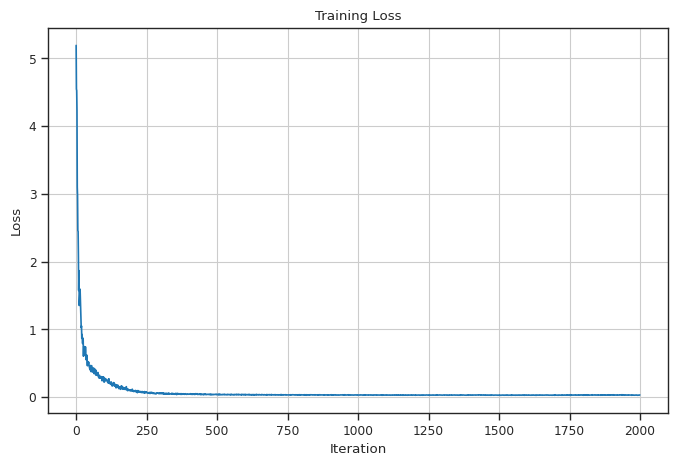

In [75]:
# Plot the loss with iteration
print(f"Final Loss: {loss_history[-1]:.6f}")
print(f"Initial Loss: {loss_history[0]:.6f}")
plt.figure(figsize=(8,5))
plt.plot(jnp.arange(len(loss_history)), loss_history)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.show()

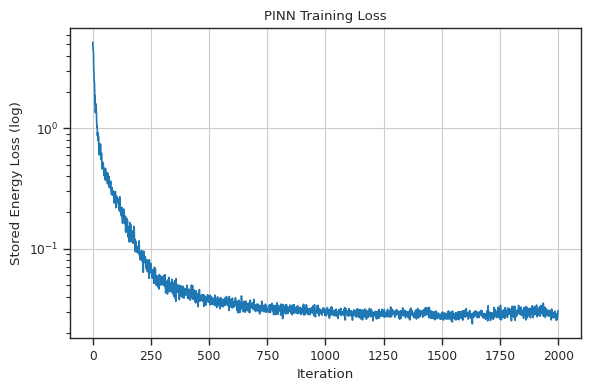

In [76]:
plt.figure(figsize=(6,4))
plt.plot(loss_history)
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Stored Energy Loss (log)')
plt.title('PINN Training Loss')
plt.grid(True)
plt.tight_layout()
plt.show()


In [77]:
# Plot displacement
def plot_displacement_contour_with_quiver(
    net1, net2,
    right_edge_displacement,
    scale_network_out=1.0,
    num_samples_X=100,
    quiver_stride=10,
    show_quiver=True
):
    x = jnp.linspace(0, 1, num_samples_X)
    xx, yy = jnp.meshgrid(x, x)
    coords = jnp.stack([xx.flatten(), yy.flatten()], axis=-1)

    # Compute displacement
    disp_fn = lambda x: displacement_field_single(x, right_edge_displacement, net1, net2) * scale_network_out
    displacement = jax.vmap(disp_fn)(coords)
    coords_deformed = coords + displacement

    u1 = displacement[:, 0].reshape(num_samples_X, num_samples_X)
    u2 = displacement[:, 1].reshape(num_samples_X, num_samples_X)
    x_def = coords_deformed[:, 0].reshape(num_samples_X, num_samples_X)
    y_def = coords_deformed[:, 1].reshape(num_samples_X, num_samples_X)

    boundary_x = [0, 1, 1, 0, 0]
    boundary_y = [0, 0, 1, 1, 0]

    # Sample for quiver
    Xq = x_def[::quiver_stride, ::quiver_stride]
    Yq = y_def[::quiver_stride, ::quiver_stride]
    Uq = u1[::quiver_stride, ::quiver_stride]
    Vq = u2[::quiver_stride, ::quiver_stride]

    fig, ax = plt.subplots(1, 2, figsize=(15, 8))
    fig.suptitle(f"Displacement Field with delta:{delta} ", fontsize=18)

    # u1
    c1 = ax[0].contourf(x_def, y_def, u1, levels=100, cmap="coolwarm")
    if show_quiver:
        ax[0].quiver(Xq, Yq, Uq, Vq, color="k", alpha=0.5, scale=3, width=0.002)
    ax[0].plot(boundary_x, boundary_y, 'r--', lw=4)
    ax[0].set_title("Horizontal Displacement ($u_x$)", fontsize=14)
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("y")
    ax[0].set_aspect("equal")
    fig.colorbar(c1, ax=ax[0])

    # u2
    c2 = ax[1].contourf(x_def, y_def, u2, levels=100, cmap="coolwarm")
    if show_quiver:
        ax[1].quiver(Xq, Yq, Uq, Vq, color="k", alpha=0.5, scale=3, width=0.002)
    ax[1].plot(boundary_x, boundary_y, 'r--', lw=4)
    ax[1].set_title("Vertical Displacement ($u_y$)", fontsize=14)
    ax[1].set_xlabel("x")
    ax[1].set_ylabel("y")
    ax[1].set_aspect("equal")
    fig.colorbar(c2, ax=ax[1])

    plt.tight_layout(rect=[0, 0, 1, 0.75])
    plt.show()



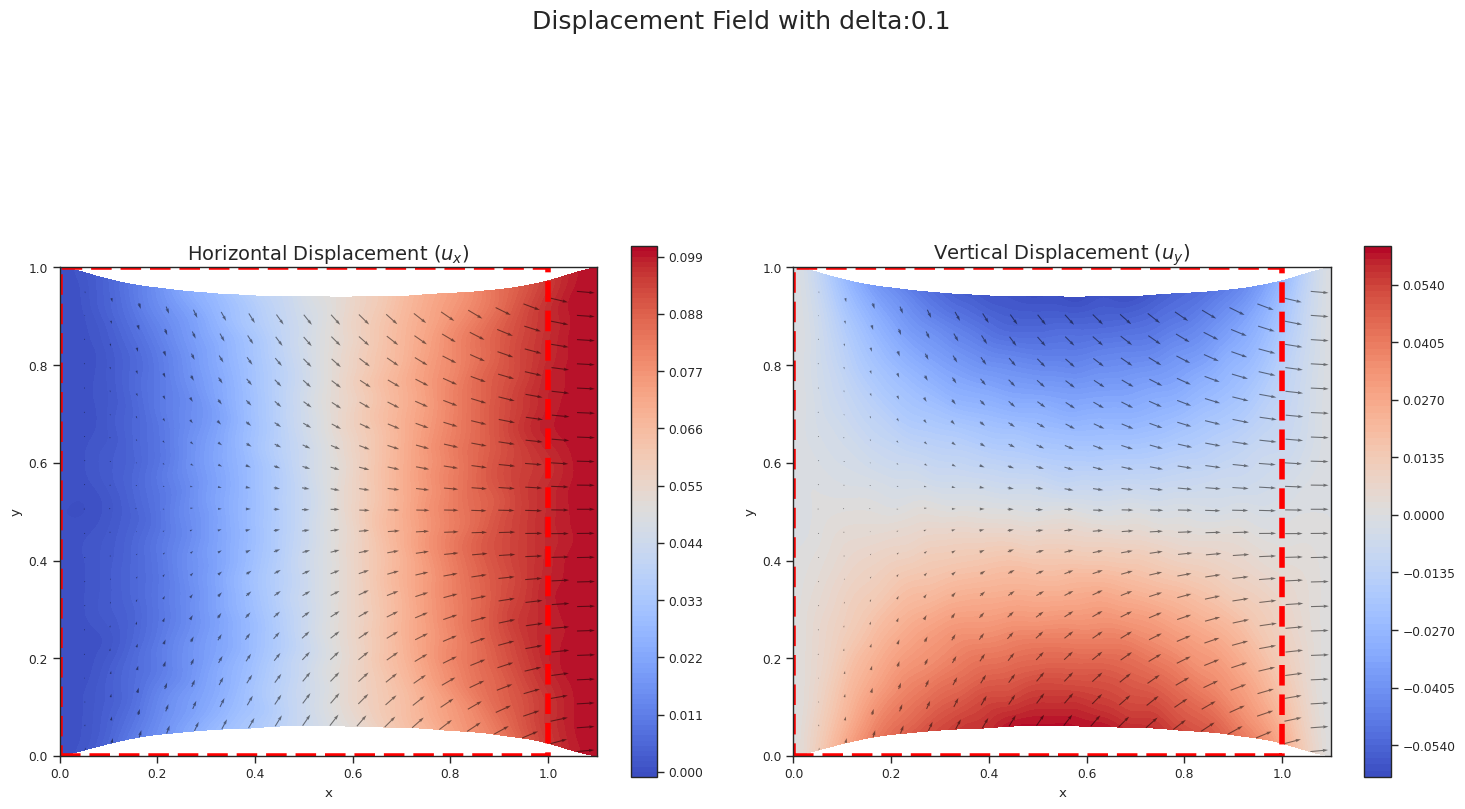

In [78]:
plot_displacement_contour_with_quiver(
    net1_trained, net2_trained,
    right_edge_displacement =0.1,
    scale_network_out=1.0,
    num_samples_X=100,
    quiver_stride=5,
    show_quiver= True
)

## Part B

Solve the problem for $\delta=0.5$ using the same architecture as above.
It will likely fail to train.
If yes, then use the solution of $\delta=0.1$ as the initial guess for $\delta=0.2$, and then use the solution of $\delta=0.2$ as the initial guess for $\delta=0.3$, and so on, until you reach $\delta=0.5$.
This is called transfer learning.

At the end, plot the final displacement field for $\delta=0.5$.

*Put your answer here. Use as many markdown and code blocks as you want.*

 Answer:

Lets first train using 𝛅 = 0.5 without the transfer learning.

In [79]:
delta = 0.5 # Provided
LEARNING_RATE = 1e-4
COLLECTION = 128
MAX_ITER = 2000
SEED = 123

key = jax.random.PRNGKey(SEED)
key1, key2 = jax.random.split(key)

net1_trained, net2_trained, loss_history = train(net1, net2, delta= delta, num_iter= MAX_ITER, lr= LEARNING_RATE, collection_points =COLLECTION)


Starting training loop...
Right Edge Displacement: 0.500 	 batch_size: 128 	 max_iter: 2000



  0%|          | 1/2000 [00:00<07:00,  4.75it/s]

[iter:    1] time elapsed:   0s  |  Loss = 9.347795


  0%|          | 10/2000 [00:02<07:08,  4.65it/s]

[iter:   10] time elapsed:   2s  |  Loss = 8.598633


  1%|          | 20/2000 [00:04<08:53,  3.71it/s]

[iter:   20] time elapsed:   4s  |  Loss = 8.177599


  2%|▏         | 30/2000 [00:06<07:17,  4.50it/s]

[iter:   30] time elapsed:   6s  |  Loss = 7.124540


  2%|▏         | 40/2000 [00:08<07:07,  4.59it/s]

[iter:   40] time elapsed:   8s  |  Loss = 6.959059


  2%|▎         | 50/2000 [00:11<07:14,  4.49it/s]

[iter:   50] time elapsed:  11s  |  Loss = 6.048157


  3%|▎         | 60/2000 [00:13<06:54,  4.68it/s]

[iter:   60] time elapsed:  13s  |  Loss = 6.067270


  4%|▎         | 70/2000 [00:15<07:13,  4.45it/s]

[iter:   70] time elapsed:  15s  |  Loss = 5.399571


  4%|▍         | 80/2000 [00:17<06:53,  4.64it/s]

[iter:   80] time elapsed:  17s  |  Loss = 5.166754


  4%|▍         | 90/2000 [00:19<06:59,  4.55it/s]

[iter:   90] time elapsed:  19s  |  Loss = 4.512649


  5%|▌         | 100/2000 [00:22<06:58,  4.54it/s]

[iter:  100] time elapsed:  22s  |  Loss = 3.165617


  6%|▌         | 110/2000 [00:24<06:45,  4.66it/s]

[iter:  110] time elapsed:  24s  |  Loss = 3.743877


  6%|▌         | 120/2000 [00:26<06:45,  4.64it/s]

[iter:  120] time elapsed:  26s  |  Loss = 2.815377


  6%|▋         | 130/2000 [00:28<07:47,  4.00it/s]

[iter:  130] time elapsed:  28s  |  Loss = 2.508211


  7%|▋         | 140/2000 [00:31<07:02,  4.41it/s]

[iter:  140] time elapsed:  31s  |  Loss = 2.213354


  8%|▊         | 150/2000 [00:33<06:43,  4.59it/s]

[iter:  150] time elapsed:  33s  |  Loss = 2.033373


  8%|▊         | 160/2000 [00:35<06:47,  4.52it/s]

[iter:  160] time elapsed:  35s  |  Loss = 1.415865


  8%|▊         | 170/2000 [00:37<06:49,  4.47it/s]

[iter:  170] time elapsed:  37s  |  Loss = 1.537470


  9%|▉         | 180/2000 [00:39<06:46,  4.48it/s]

[iter:  180] time elapsed:  39s  |  Loss = 1.340774


 10%|▉         | 190/2000 [00:42<06:53,  4.38it/s]

[iter:  190] time elapsed:  42s  |  Loss = 1.133555


 10%|█         | 200/2000 [00:44<06:47,  4.41it/s]

[iter:  200] time elapsed:  44s  |  Loss = 1.179930


 10%|█         | 210/2000 [00:46<06:27,  4.62it/s]

[iter:  210] time elapsed:  46s  |  Loss = 1.033906


 11%|█         | 220/2000 [00:48<06:43,  4.41it/s]

[iter:  220] time elapsed:  48s  |  Loss = 0.931469


 12%|█▏        | 230/2000 [00:51<06:32,  4.51it/s]

[iter:  230] time elapsed:  51s  |  Loss = 0.714892


 12%|█▏        | 240/2000 [00:53<07:41,  3.81it/s]

[iter:  240] time elapsed:  53s  |  Loss = 0.719783


 12%|█▎        | 250/2000 [00:55<06:20,  4.59it/s]

[iter:  250] time elapsed:  55s  |  Loss = 0.685582


 13%|█▎        | 260/2000 [00:58<06:19,  4.59it/s]

[iter:  260] time elapsed:  58s  |  Loss = 0.697182


 14%|█▎        | 270/2000 [01:00<06:18,  4.57it/s]

[iter:  270] time elapsed:  60s  |  Loss = 0.821861


 14%|█▍        | 280/2000 [01:02<06:14,  4.59it/s]

[iter:  280] time elapsed:  62s  |  Loss = 0.576432


 14%|█▍        | 290/2000 [01:04<06:24,  4.44it/s]

[iter:  290] time elapsed:  64s  |  Loss = 0.649448


 15%|█▌        | 300/2000 [01:06<06:09,  4.60it/s]

[iter:  300] time elapsed:  66s  |  Loss = 0.613023


 16%|█▌        | 310/2000 [01:09<06:13,  4.53it/s]

[iter:  310] time elapsed:  69s  |  Loss = 0.650249


 16%|█▌        | 320/2000 [01:11<06:04,  4.60it/s]

[iter:  320] time elapsed:  71s  |  Loss = 0.602970


 16%|█▋        | 330/2000 [01:13<06:00,  4.63it/s]

[iter:  330] time elapsed:  73s  |  Loss = 0.684086


 17%|█▋        | 340/2000 [01:15<05:59,  4.62it/s]

[iter:  340] time elapsed:  75s  |  Loss = 0.599073


 18%|█▊        | 350/2000 [01:17<05:57,  4.62it/s]

[iter:  350] time elapsed:  77s  |  Loss = 0.654514


 18%|█▊        | 360/2000 [01:20<05:53,  4.64it/s]

[iter:  360] time elapsed:  80s  |  Loss = 0.651037


 18%|█▊        | 370/2000 [01:22<05:57,  4.56it/s]

[iter:  370] time elapsed:  82s  |  Loss = 0.581586


 19%|█▉        | 380/2000 [01:24<05:46,  4.67it/s]

[iter:  380] time elapsed:  84s  |  Loss = 0.620005


 20%|█▉        | 390/2000 [01:26<05:48,  4.62it/s]

[iter:  390] time elapsed:  86s  |  Loss = 0.579680


 20%|██        | 400/2000 [01:28<05:47,  4.60it/s]

[iter:  400] time elapsed:  88s  |  Loss = 0.556093


 20%|██        | 410/2000 [01:30<05:36,  4.72it/s]

[iter:  410] time elapsed:  90s  |  Loss = 0.627261


 21%|██        | 420/2000 [01:33<05:39,  4.65it/s]

[iter:  420] time elapsed:  93s  |  Loss = 0.561704


 22%|██▏       | 430/2000 [01:35<05:38,  4.63it/s]

[iter:  430] time elapsed:  95s  |  Loss = 0.706197


 22%|██▏       | 440/2000 [01:37<06:02,  4.30it/s]

[iter:  440] time elapsed:  97s  |  Loss = 0.582122


 22%|██▎       | 450/2000 [01:39<05:45,  4.48it/s]

[iter:  450] time elapsed:  99s  |  Loss = 0.650303


 23%|██▎       | 460/2000 [01:42<05:40,  4.53it/s]

[iter:  460] time elapsed: 102s  |  Loss = 0.571914


 24%|██▎       | 470/2000 [01:44<05:38,  4.52it/s]

[iter:  470] time elapsed: 104s  |  Loss = 0.583852


 24%|██▍       | 480/2000 [01:46<05:26,  4.66it/s]

[iter:  480] time elapsed: 106s  |  Loss = 0.577028


 24%|██▍       | 490/2000 [01:48<05:25,  4.64it/s]

[iter:  490] time elapsed: 108s  |  Loss = 0.519870


 25%|██▌       | 500/2000 [01:50<05:26,  4.59it/s]

[iter:  500] time elapsed: 110s  |  Loss = 0.551279


 26%|██▌       | 510/2000 [01:53<05:24,  4.60it/s]

[iter:  510] time elapsed: 113s  |  Loss = 0.507581


 26%|██▌       | 520/2000 [01:55<05:17,  4.66it/s]

[iter:  520] time elapsed: 115s  |  Loss = 0.491699


 26%|██▋       | 530/2000 [01:57<05:14,  4.68it/s]

[iter:  530] time elapsed: 117s  |  Loss = 0.585651


 27%|██▋       | 540/2000 [01:59<06:08,  3.97it/s]

[iter:  540] time elapsed: 119s  |  Loss = 0.539531


 28%|██▊       | 550/2000 [02:01<05:12,  4.64it/s]

[iter:  550] time elapsed: 121s  |  Loss = 0.592240


 28%|██▊       | 560/2000 [02:04<05:18,  4.52it/s]

[iter:  560] time elapsed: 124s  |  Loss = 0.534020


 28%|██▊       | 570/2000 [02:06<05:11,  4.58it/s]

[iter:  570] time elapsed: 126s  |  Loss = 0.544847


 29%|██▉       | 580/2000 [02:08<05:14,  4.52it/s]

[iter:  580] time elapsed: 128s  |  Loss = 0.558309


 30%|██▉       | 590/2000 [02:10<05:12,  4.52it/s]

[iter:  590] time elapsed: 130s  |  Loss = 0.544035


 30%|███       | 600/2000 [02:12<05:10,  4.51it/s]

[iter:  600] time elapsed: 132s  |  Loss = 0.525535


 30%|███       | 610/2000 [02:15<05:13,  4.44it/s]

[iter:  610] time elapsed: 135s  |  Loss = 0.521620


 31%|███       | 620/2000 [02:17<05:11,  4.43it/s]

[iter:  620] time elapsed: 137s  |  Loss = 0.485802


 32%|███▏      | 630/2000 [02:19<05:05,  4.49it/s]

[iter:  630] time elapsed: 139s  |  Loss = 0.511193


 32%|███▏      | 640/2000 [02:21<05:04,  4.46it/s]

[iter:  640] time elapsed: 141s  |  Loss = 0.631327


 32%|███▎      | 650/2000 [02:24<05:14,  4.30it/s]

[iter:  650] time elapsed: 144s  |  Loss = 0.611658


 33%|███▎      | 660/2000 [02:26<04:56,  4.51it/s]

[iter:  660] time elapsed: 146s  |  Loss = 0.513225


 34%|███▎      | 670/2000 [02:28<04:52,  4.55it/s]

[iter:  670] time elapsed: 148s  |  Loss = 0.542265


 34%|███▍      | 680/2000 [02:31<04:44,  4.64it/s]

[iter:  680] time elapsed: 151s  |  Loss = 0.531215


 34%|███▍      | 690/2000 [02:33<04:42,  4.63it/s]

[iter:  690] time elapsed: 153s  |  Loss = 0.512781


 35%|███▌      | 700/2000 [02:35<04:53,  4.43it/s]

[iter:  700] time elapsed: 155s  |  Loss = 0.497077


 36%|███▌      | 710/2000 [02:37<04:42,  4.57it/s]

[iter:  710] time elapsed: 157s  |  Loss = 0.494378


 36%|███▌      | 720/2000 [02:39<04:47,  4.46it/s]

[iter:  720] time elapsed: 159s  |  Loss = 0.534419


 36%|███▋      | 730/2000 [02:42<04:46,  4.43it/s]

[iter:  730] time elapsed: 162s  |  Loss = 0.506464


 37%|███▋      | 740/2000 [02:44<04:44,  4.43it/s]

[iter:  740] time elapsed: 164s  |  Loss = 0.507528


 38%|███▊      | 750/2000 [02:46<04:50,  4.31it/s]

[iter:  750] time elapsed: 166s  |  Loss = 0.501368


 38%|███▊      | 760/2000 [02:49<04:39,  4.44it/s]

[iter:  760] time elapsed: 169s  |  Loss = 0.532469


 38%|███▊      | 770/2000 [02:51<04:40,  4.38it/s]

[iter:  770] time elapsed: 171s  |  Loss = 0.537986


 39%|███▉      | 780/2000 [02:53<04:29,  4.53it/s]

[iter:  780] time elapsed: 173s  |  Loss = 0.542724


 40%|███▉      | 790/2000 [02:55<04:24,  4.58it/s]

[iter:  790] time elapsed: 175s  |  Loss = 0.488223


 40%|████      | 800/2000 [02:58<04:21,  4.60it/s]

[iter:  800] time elapsed: 178s  |  Loss = 0.549548


 40%|████      | 810/2000 [03:00<04:16,  4.64it/s]

[iter:  810] time elapsed: 180s  |  Loss = 0.588927


 41%|████      | 820/2000 [03:02<04:20,  4.52it/s]

[iter:  820] time elapsed: 182s  |  Loss = 0.535809


 42%|████▏     | 830/2000 [03:04<04:21,  4.48it/s]

[iter:  830] time elapsed: 184s  |  Loss = 0.502949


 42%|████▏     | 840/2000 [03:06<04:18,  4.48it/s]

[iter:  840] time elapsed: 186s  |  Loss = 0.491330


 42%|████▎     | 850/2000 [03:09<05:40,  3.38it/s]

[iter:  850] time elapsed: 189s  |  Loss = 0.517348


 43%|████▎     | 860/2000 [03:11<04:22,  4.35it/s]

[iter:  860] time elapsed: 191s  |  Loss = 0.518139


 44%|████▎     | 870/2000 [03:13<04:19,  4.35it/s]

[iter:  870] time elapsed: 193s  |  Loss = 0.530552


 44%|████▍     | 880/2000 [03:16<04:10,  4.46it/s]

[iter:  880] time elapsed: 196s  |  Loss = 0.513306


 44%|████▍     | 890/2000 [03:18<04:04,  4.54it/s]

[iter:  890] time elapsed: 198s  |  Loss = 0.566193


 45%|████▌     | 900/2000 [03:20<04:05,  4.47it/s]

[iter:  900] time elapsed: 200s  |  Loss = 0.511466


 46%|████▌     | 910/2000 [03:22<03:58,  4.57it/s]

[iter:  910] time elapsed: 202s  |  Loss = 0.494724


 46%|████▌     | 920/2000 [03:24<04:04,  4.42it/s]

[iter:  920] time elapsed: 204s  |  Loss = 0.525411


 46%|████▋     | 930/2000 [03:27<03:58,  4.49it/s]

[iter:  930] time elapsed: 207s  |  Loss = 0.532959


 47%|████▋     | 940/2000 [03:29<03:54,  4.52it/s]

[iter:  940] time elapsed: 209s  |  Loss = 0.538436


 48%|████▊     | 950/2000 [03:31<03:51,  4.54it/s]

[iter:  950] time elapsed: 211s  |  Loss = 0.484195


 48%|████▊     | 960/2000 [03:34<04:16,  4.05it/s]

[iter:  960] time elapsed: 214s  |  Loss = 0.537897


 48%|████▊     | 970/2000 [03:36<03:49,  4.49it/s]

[iter:  970] time elapsed: 216s  |  Loss = 0.510702


 49%|████▉     | 980/2000 [03:38<03:53,  4.36it/s]

[iter:  980] time elapsed: 218s  |  Loss = 0.501670


 50%|████▉     | 990/2000 [03:40<03:49,  4.40it/s]

[iter:  990] time elapsed: 220s  |  Loss = 0.588573


 50%|█████     | 1000/2000 [03:43<03:46,  4.41it/s]

[iter: 1000] time elapsed: 223s  |  Loss = 0.482689


 50%|█████     | 1010/2000 [03:45<03:44,  4.41it/s]

[iter: 1010] time elapsed: 225s  |  Loss = 0.514621


 51%|█████     | 1020/2000 [03:47<03:36,  4.52it/s]

[iter: 1020] time elapsed: 227s  |  Loss = 0.544460


 52%|█████▏    | 1030/2000 [03:49<03:42,  4.37it/s]

[iter: 1030] time elapsed: 229s  |  Loss = 0.488619


 52%|█████▏    | 1040/2000 [03:52<03:28,  4.59it/s]

[iter: 1040] time elapsed: 232s  |  Loss = 0.503709


 52%|█████▎    | 1050/2000 [03:54<03:27,  4.57it/s]

[iter: 1050] time elapsed: 234s  |  Loss = 0.491842


 53%|█████▎    | 1060/2000 [03:56<03:27,  4.52it/s]

[iter: 1060] time elapsed: 236s  |  Loss = 0.514376


 54%|█████▎    | 1070/2000 [03:58<03:32,  4.38it/s]

[iter: 1070] time elapsed: 238s  |  Loss = 0.515520


 54%|█████▍    | 1080/2000 [04:01<03:31,  4.34it/s]

[iter: 1080] time elapsed: 241s  |  Loss = 0.531826


 55%|█████▍    | 1090/2000 [04:03<03:23,  4.46it/s]

[iter: 1090] time elapsed: 243s  |  Loss = 0.513879


 55%|█████▌    | 1100/2000 [04:05<03:24,  4.40it/s]

[iter: 1100] time elapsed: 245s  |  Loss = 0.470769


 56%|█████▌    | 1110/2000 [04:07<03:19,  4.46it/s]

[iter: 1110] time elapsed: 247s  |  Loss = 0.526369


 56%|█████▌    | 1120/2000 [04:10<03:17,  4.45it/s]

[iter: 1120] time elapsed: 250s  |  Loss = 0.502237


 56%|█████▋    | 1130/2000 [04:12<03:17,  4.40it/s]

[iter: 1130] time elapsed: 252s  |  Loss = 0.526187


 57%|█████▋    | 1140/2000 [04:14<03:15,  4.39it/s]

[iter: 1140] time elapsed: 254s  |  Loss = 0.518365


 57%|█████▊    | 1150/2000 [04:17<03:08,  4.50it/s]

[iter: 1150] time elapsed: 257s  |  Loss = 0.484414


 58%|█████▊    | 1160/2000 [04:19<03:52,  3.62it/s]

[iter: 1160] time elapsed: 259s  |  Loss = 0.457996


 58%|█████▊    | 1170/2000 [04:21<03:04,  4.50it/s]

[iter: 1170] time elapsed: 261s  |  Loss = 0.523827


 59%|█████▉    | 1180/2000 [04:23<03:07,  4.38it/s]

[iter: 1180] time elapsed: 263s  |  Loss = 0.493578


 60%|█████▉    | 1190/2000 [04:26<03:00,  4.49it/s]

[iter: 1190] time elapsed: 266s  |  Loss = 0.543980


 60%|██████    | 1200/2000 [04:28<03:04,  4.34it/s]

[iter: 1200] time elapsed: 268s  |  Loss = 0.471790


 60%|██████    | 1210/2000 [04:30<02:58,  4.44it/s]

[iter: 1210] time elapsed: 270s  |  Loss = 0.513308


 61%|██████    | 1220/2000 [04:33<02:53,  4.49it/s]

[iter: 1220] time elapsed: 273s  |  Loss = 0.469548


 62%|██████▏   | 1230/2000 [04:35<02:54,  4.40it/s]

[iter: 1230] time elapsed: 275s  |  Loss = 0.463909


 62%|██████▏   | 1240/2000 [04:37<02:47,  4.54it/s]

[iter: 1240] time elapsed: 277s  |  Loss = 0.491167


 62%|██████▎   | 1250/2000 [04:39<02:45,  4.54it/s]

[iter: 1250] time elapsed: 279s  |  Loss = 0.474011


 63%|██████▎   | 1260/2000 [04:42<03:42,  3.32it/s]

[iter: 1260] time elapsed: 282s  |  Loss = 0.488950


 64%|██████▎   | 1270/2000 [04:44<02:43,  4.48it/s]

[iter: 1270] time elapsed: 284s  |  Loss = 0.468489


 64%|██████▍   | 1280/2000 [04:46<02:36,  4.61it/s]

[iter: 1280] time elapsed: 286s  |  Loss = 0.457785


 64%|██████▍   | 1290/2000 [04:48<02:46,  4.26it/s]

[iter: 1290] time elapsed: 288s  |  Loss = 0.489992


 65%|██████▌   | 1300/2000 [04:51<02:38,  4.41it/s]

[iter: 1300] time elapsed: 291s  |  Loss = 0.476775


 66%|██████▌   | 1310/2000 [04:53<02:34,  4.46it/s]

[iter: 1310] time elapsed: 293s  |  Loss = 0.506002


 66%|██████▌   | 1320/2000 [04:55<02:31,  4.48it/s]

[iter: 1320] time elapsed: 295s  |  Loss = 0.464407


 66%|██████▋   | 1330/2000 [04:57<02:28,  4.52it/s]

[iter: 1330] time elapsed: 297s  |  Loss = 0.528484


 67%|██████▋   | 1340/2000 [05:00<02:31,  4.36it/s]

[iter: 1340] time elapsed: 300s  |  Loss = 0.499905


 68%|██████▊   | 1350/2000 [05:02<02:25,  4.47it/s]

[iter: 1350] time elapsed: 302s  |  Loss = 0.489686


 68%|██████▊   | 1360/2000 [05:04<02:22,  4.49it/s]

[iter: 1360] time elapsed: 304s  |  Loss = 0.513167


 68%|██████▊   | 1370/2000 [05:07<02:31,  4.15it/s]

[iter: 1370] time elapsed: 307s  |  Loss = 0.496639


 69%|██████▉   | 1380/2000 [05:09<02:19,  4.43it/s]

[iter: 1380] time elapsed: 309s  |  Loss = 0.491572


 70%|██████▉   | 1390/2000 [05:11<02:21,  4.31it/s]

[iter: 1390] time elapsed: 311s  |  Loss = 0.520317


 70%|███████   | 1400/2000 [05:13<02:13,  4.49it/s]

[iter: 1400] time elapsed: 313s  |  Loss = 0.483330


 70%|███████   | 1410/2000 [05:16<02:11,  4.48it/s]

[iter: 1410] time elapsed: 316s  |  Loss = 0.493371


 71%|███████   | 1420/2000 [05:18<02:09,  4.49it/s]

[iter: 1420] time elapsed: 318s  |  Loss = 0.484372


 72%|███████▏  | 1430/2000 [05:20<02:07,  4.46it/s]

[iter: 1430] time elapsed: 320s  |  Loss = 0.505591


 72%|███████▏  | 1440/2000 [05:23<02:14,  4.16it/s]

[iter: 1440] time elapsed: 323s  |  Loss = 0.514567


 72%|███████▎  | 1450/2000 [05:25<02:06,  4.36it/s]

[iter: 1450] time elapsed: 325s  |  Loss = 0.485564


 73%|███████▎  | 1460/2000 [05:27<02:02,  4.42it/s]

[iter: 1460] time elapsed: 327s  |  Loss = 0.505479


 74%|███████▎  | 1470/2000 [05:29<01:59,  4.42it/s]

[iter: 1470] time elapsed: 329s  |  Loss = 0.454085


 74%|███████▍  | 1480/2000 [05:32<02:00,  4.33it/s]

[iter: 1480] time elapsed: 332s  |  Loss = 0.478518


 74%|███████▍  | 1490/2000 [05:34<01:56,  4.39it/s]

[iter: 1490] time elapsed: 334s  |  Loss = 0.477173


 75%|███████▌  | 1500/2000 [05:36<01:52,  4.44it/s]

[iter: 1500] time elapsed: 336s  |  Loss = 0.496288


 76%|███████▌  | 1510/2000 [05:39<01:53,  4.31it/s]

[iter: 1510] time elapsed: 339s  |  Loss = 0.498696


 76%|███████▌  | 1520/2000 [05:41<01:48,  4.43it/s]

[iter: 1520] time elapsed: 341s  |  Loss = 0.502632


 76%|███████▋  | 1530/2000 [05:43<01:44,  4.49it/s]

[iter: 1530] time elapsed: 343s  |  Loss = 0.462582


 77%|███████▋  | 1540/2000 [05:46<01:45,  4.38it/s]

[iter: 1540] time elapsed: 346s  |  Loss = 0.486193


 78%|███████▊  | 1550/2000 [05:48<01:41,  4.44it/s]

[iter: 1550] time elapsed: 348s  |  Loss = 0.502652


 78%|███████▊  | 1560/2000 [05:50<01:36,  4.56it/s]

[iter: 1560] time elapsed: 350s  |  Loss = 0.483480


 78%|███████▊  | 1570/2000 [05:52<01:37,  4.42it/s]

[iter: 1570] time elapsed: 352s  |  Loss = 0.461167


 79%|███████▉  | 1580/2000 [05:55<01:36,  4.37it/s]

[iter: 1580] time elapsed: 355s  |  Loss = 0.490233


 80%|███████▉  | 1590/2000 [05:57<01:49,  3.76it/s]

[iter: 1590] time elapsed: 357s  |  Loss = 0.528507


 80%|████████  | 1600/2000 [05:59<01:30,  4.43it/s]

[iter: 1600] time elapsed: 359s  |  Loss = 0.487252


 80%|████████  | 1610/2000 [06:02<01:29,  4.34it/s]

[iter: 1610] time elapsed: 362s  |  Loss = 0.520878


 81%|████████  | 1620/2000 [06:04<01:26,  4.41it/s]

[iter: 1620] time elapsed: 364s  |  Loss = 0.490890


 82%|████████▏ | 1630/2000 [06:06<01:23,  4.42it/s]

[iter: 1630] time elapsed: 366s  |  Loss = 0.483522


 82%|████████▏ | 1640/2000 [06:08<01:22,  4.34it/s]

[iter: 1640] time elapsed: 368s  |  Loss = 0.486816


 82%|████████▎ | 1650/2000 [06:11<01:18,  4.45it/s]

[iter: 1650] time elapsed: 371s  |  Loss = 0.485893


 83%|████████▎ | 1660/2000 [06:13<01:15,  4.48it/s]

[iter: 1660] time elapsed: 373s  |  Loss = 0.486493


 84%|████████▎ | 1670/2000 [06:15<01:13,  4.50it/s]

[iter: 1670] time elapsed: 375s  |  Loss = 0.499366


 84%|████████▍ | 1680/2000 [06:17<01:11,  4.50it/s]

[iter: 1680] time elapsed: 377s  |  Loss = 0.487246


 84%|████████▍ | 1690/2000 [06:20<01:09,  4.44it/s]

[iter: 1690] time elapsed: 380s  |  Loss = 0.470998


 85%|████████▌ | 1700/2000 [06:22<01:12,  4.12it/s]

[iter: 1700] time elapsed: 382s  |  Loss = 0.578184


 86%|████████▌ | 1710/2000 [06:24<01:02,  4.65it/s]

[iter: 1710] time elapsed: 384s  |  Loss = 0.454620


 86%|████████▌ | 1720/2000 [06:27<01:02,  4.47it/s]

[iter: 1720] time elapsed: 387s  |  Loss = 0.505542


 86%|████████▋ | 1730/2000 [06:29<01:00,  4.47it/s]

[iter: 1730] time elapsed: 389s  |  Loss = 0.491431


 87%|████████▋ | 1740/2000 [06:31<00:58,  4.46it/s]

[iter: 1740] time elapsed: 391s  |  Loss = 0.519465


 88%|████████▊ | 1750/2000 [06:33<00:57,  4.38it/s]

[iter: 1750] time elapsed: 393s  |  Loss = 0.492512


 88%|████████▊ | 1760/2000 [06:36<00:54,  4.44it/s]

[iter: 1760] time elapsed: 396s  |  Loss = 0.488926


 88%|████████▊ | 1770/2000 [06:38<00:52,  4.42it/s]

[iter: 1770] time elapsed: 398s  |  Loss = 0.509697


 89%|████████▉ | 1780/2000 [06:40<00:49,  4.46it/s]

[iter: 1780] time elapsed: 400s  |  Loss = 0.512632


 90%|████████▉ | 1790/2000 [06:42<00:48,  4.32it/s]

[iter: 1790] time elapsed: 402s  |  Loss = 0.488178


 90%|█████████ | 1800/2000 [06:45<00:46,  4.30it/s]

[iter: 1800] time elapsed: 405s  |  Loss = 0.464587


 90%|█████████ | 1810/2000 [06:47<00:53,  3.58it/s]

[iter: 1810] time elapsed: 407s  |  Loss = 0.563863


 91%|█████████ | 1820/2000 [06:49<00:42,  4.25it/s]

[iter: 1820] time elapsed: 409s  |  Loss = 0.507856


 92%|█████████▏| 1830/2000 [06:52<00:38,  4.42it/s]

[iter: 1830] time elapsed: 412s  |  Loss = 0.515696


 92%|█████████▏| 1840/2000 [06:54<00:35,  4.45it/s]

[iter: 1840] time elapsed: 414s  |  Loss = 0.513166


 92%|█████████▎| 1850/2000 [06:56<00:34,  4.30it/s]

[iter: 1850] time elapsed: 416s  |  Loss = 0.482698


 93%|█████████▎| 1860/2000 [06:59<00:31,  4.42it/s]

[iter: 1860] time elapsed: 419s  |  Loss = 0.492395


 94%|█████████▎| 1870/2000 [07:01<00:29,  4.47it/s]

[iter: 1870] time elapsed: 421s  |  Loss = 0.471180


 94%|█████████▍| 1880/2000 [07:03<00:26,  4.46it/s]

[iter: 1880] time elapsed: 423s  |  Loss = 0.512606


 94%|█████████▍| 1890/2000 [07:05<00:24,  4.45it/s]

[iter: 1890] time elapsed: 425s  |  Loss = 0.526851


 95%|█████████▌| 1900/2000 [07:08<00:23,  4.29it/s]

[iter: 1900] time elapsed: 428s  |  Loss = 0.492697


 96%|█████████▌| 1910/2000 [07:10<00:19,  4.53it/s]

[iter: 1910] time elapsed: 430s  |  Loss = 0.443250


 96%|█████████▌| 1920/2000 [07:12<00:18,  4.39it/s]

[iter: 1920] time elapsed: 432s  |  Loss = 0.470101


 96%|█████████▋| 1930/2000 [07:15<00:15,  4.48it/s]

[iter: 1930] time elapsed: 435s  |  Loss = 0.509956


 97%|█████████▋| 1940/2000 [07:17<00:13,  4.49it/s]

[iter: 1940] time elapsed: 437s  |  Loss = 0.461928


 98%|█████████▊| 1950/2000 [07:19<00:11,  4.42it/s]

[iter: 1950] time elapsed: 439s  |  Loss = 0.527335


 98%|█████████▊| 1960/2000 [07:21<00:08,  4.58it/s]

[iter: 1960] time elapsed: 441s  |  Loss = 0.520318


 98%|█████████▊| 1970/2000 [07:23<00:06,  4.48it/s]

[iter: 1970] time elapsed: 443s  |  Loss = 0.471097


 99%|█████████▉| 1980/2000 [07:26<00:04,  4.59it/s]

[iter: 1980] time elapsed: 446s  |  Loss = 0.443107


100%|█████████▉| 1991/2000 [07:28<00:01,  4.88it/s]

[iter: 1990] time elapsed: 448s  |  Loss = 0.507759


100%|██████████| 2000/2000 [07:30<00:00,  4.44it/s]

[iter: 2000] time elapsed: 450s  |  Loss = 0.536390


Final Loss: 0.536390
Initial Loss: 9.347795


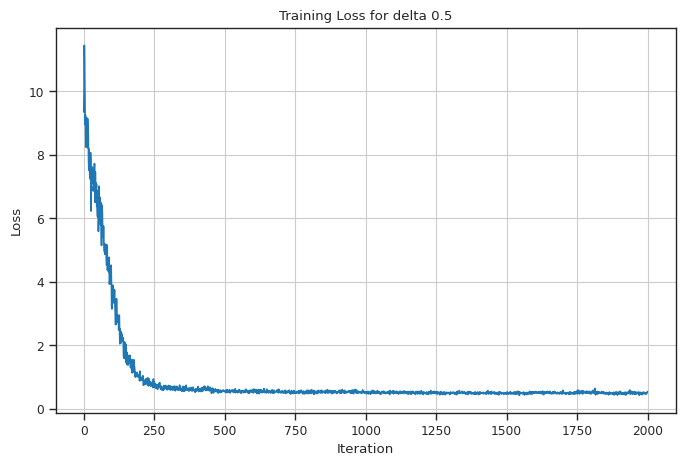

In [80]:
# Plot the loss with iteration for delta 0.5
print(f"Final Loss: {loss_history[-1]:.6f}")
print(f"Initial Loss: {loss_history[0]:.6f}")
plt.figure(figsize=(8,5))
plt.plot(jnp.arange(len(loss_history)), loss_history)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss for delta 0.5")
plt.grid(True)
plt.show()

Now we can use the transfer learning approach

In [81]:
# delta = 0.1 already trained previously
trained_pairs = [(net1_trained, net2_trained)]  # store it

# Proceed with transfer learning from delta = 0.2 to 0.5
deltas = [0.2, 0.3, 0.4, 0.5]

for delta_val in deltas:
    print(f"\nTraining with delta = {delta_val}")
    net1_prev, net2_prev = trained_pairs[-1]
    net1_new, net2_new, _ = train(
        net1_prev, net2_prev,
        delta=delta_val,
        num_iter=MAX_ITER,
        lr=LEARNING_RATE,
        collection_points=COLLECTION,
        seed=SEED
    )
    trained_pairs.append((net1_new, net2_new))

# Add delta = 0.1 to the list
deltas = [0.1] + deltas

# Final loss evaluation
print("\nFinal Loss Values After Transfer Learning:\n")
key = jax.random.PRNGKey(42)
for delta_val, (net1, net2) in zip(deltas, trained_pairs):
    key, subkey = jax.random.split(key)
    x_test = jax.random.uniform(subkey, (COLLECTION, 2))
    loss_val = stored_energy_loss(x_test, delta_val, net1, net2)
    print(f"delta = {delta_val:.1f} \t Loss = {loss_val:.6f}")



Training with delta = 0.2

Starting training loop...
Right Edge Displacement: 0.200 	 batch_size: 128 	 max_iter: 2000



  0%|          | 1/2000 [00:00<07:56,  4.19it/s]

[iter:    1] time elapsed:   0s  |  Loss = 2.772916


  0%|          | 10/2000 [00:02<08:10,  4.06it/s]

[iter:   10] time elapsed:   2s  |  Loss = 1.261217


  1%|          | 20/2000 [00:04<07:31,  4.38it/s]

[iter:   20] time elapsed:   4s  |  Loss = 0.367456


  2%|▏         | 30/2000 [00:07<07:27,  4.40it/s]

[iter:   30] time elapsed:   7s  |  Loss = 0.186862


  2%|▏         | 40/2000 [00:09<07:27,  4.38it/s]

[iter:   40] time elapsed:   9s  |  Loss = 0.132905


  2%|▎         | 50/2000 [00:11<07:27,  4.36it/s]

[iter:   50] time elapsed:  11s  |  Loss = 0.103029


  3%|▎         | 60/2000 [00:13<07:21,  4.39it/s]

[iter:   60] time elapsed:  13s  |  Loss = 0.108635


  4%|▎         | 70/2000 [00:16<07:13,  4.45it/s]

[iter:   70] time elapsed:  16s  |  Loss = 0.105700


  4%|▍         | 80/2000 [00:18<07:10,  4.46it/s]

[iter:   80] time elapsed:  18s  |  Loss = 0.094598


  4%|▍         | 90/2000 [00:20<07:04,  4.50it/s]

[iter:   90] time elapsed:  20s  |  Loss = 0.098688


  5%|▌         | 100/2000 [00:22<07:05,  4.46it/s]

[iter:  100] time elapsed:  22s  |  Loss = 0.089942


  6%|▌         | 110/2000 [00:25<07:20,  4.29it/s]

[iter:  110] time elapsed:  25s  |  Loss = 0.094812


  6%|▌         | 120/2000 [00:27<07:09,  4.37it/s]

[iter:  120] time elapsed:  27s  |  Loss = 0.096922


  6%|▋         | 130/2000 [00:30<07:03,  4.42it/s]

[iter:  130] time elapsed:  30s  |  Loss = 0.098271


  7%|▋         | 140/2000 [00:32<07:02,  4.41it/s]

[iter:  140] time elapsed:  32s  |  Loss = 0.100690


  8%|▊         | 150/2000 [00:34<07:02,  4.38it/s]

[iter:  150] time elapsed:  34s  |  Loss = 0.101116


  8%|▊         | 160/2000 [00:36<07:10,  4.27it/s]

[iter:  160] time elapsed:  36s  |  Loss = 0.094951


  8%|▊         | 170/2000 [00:39<06:53,  4.43it/s]

[iter:  170] time elapsed:  39s  |  Loss = 0.095105


  9%|▉         | 180/2000 [00:41<06:59,  4.34it/s]

[iter:  180] time elapsed:  41s  |  Loss = 0.095586


 10%|▉         | 190/2000 [00:43<07:00,  4.31it/s]

[iter:  190] time elapsed:  43s  |  Loss = 0.095526


 10%|█         | 200/2000 [00:45<06:50,  4.39it/s]

[iter:  200] time elapsed:  46s  |  Loss = 0.090293


 10%|█         | 210/2000 [00:48<07:03,  4.23it/s]

[iter:  210] time elapsed:  48s  |  Loss = 0.091888


 11%|█         | 220/2000 [00:50<06:44,  4.40it/s]

[iter:  220] time elapsed:  50s  |  Loss = 0.090071


 12%|█▏        | 230/2000 [00:53<06:35,  4.48it/s]

[iter:  230] time elapsed:  53s  |  Loss = 0.091209


 12%|█▏        | 240/2000 [00:55<06:32,  4.48it/s]

[iter:  240] time elapsed:  55s  |  Loss = 0.093106


 12%|█▎        | 250/2000 [00:57<06:29,  4.50it/s]

[iter:  250] time elapsed:  57s  |  Loss = 0.090726


 13%|█▎        | 260/2000 [00:59<06:44,  4.30it/s]

[iter:  260] time elapsed:  59s  |  Loss = 0.090733


 14%|█▎        | 270/2000 [01:02<06:24,  4.50it/s]

[iter:  270] time elapsed:  62s  |  Loss = 0.092478


 14%|█▍        | 280/2000 [01:04<06:24,  4.48it/s]

[iter:  280] time elapsed:  64s  |  Loss = 0.091123


 14%|█▍        | 290/2000 [01:06<06:29,  4.39it/s]

[iter:  290] time elapsed:  66s  |  Loss = 0.088093


 15%|█▌        | 300/2000 [01:08<06:25,  4.41it/s]

[iter:  300] time elapsed:  68s  |  Loss = 0.092524


 16%|█▌        | 310/2000 [01:11<06:24,  4.39it/s]

[iter:  310] time elapsed:  71s  |  Loss = 0.090298


 16%|█▌        | 320/2000 [01:13<06:17,  4.45it/s]

[iter:  320] time elapsed:  73s  |  Loss = 0.101320


 16%|█▋        | 330/2000 [01:15<06:13,  4.47it/s]

[iter:  330] time elapsed:  75s  |  Loss = 0.091211


 17%|█▋        | 340/2000 [01:18<06:28,  4.28it/s]

[iter:  340] time elapsed:  78s  |  Loss = 0.092635


 18%|█▊        | 350/2000 [01:20<06:07,  4.49it/s]

[iter:  350] time elapsed:  80s  |  Loss = 0.090145


 18%|█▊        | 360/2000 [01:22<06:16,  4.36it/s]

[iter:  360] time elapsed:  82s  |  Loss = 0.087820


 18%|█▊        | 370/2000 [01:24<06:06,  4.45it/s]

[iter:  370] time elapsed:  84s  |  Loss = 0.095729


 19%|█▉        | 380/2000 [01:27<06:03,  4.46it/s]

[iter:  380] time elapsed:  87s  |  Loss = 0.094110


 20%|█▉        | 390/2000 [01:29<05:56,  4.51it/s]

[iter:  390] time elapsed:  89s  |  Loss = 0.090984


 20%|██        | 400/2000 [01:31<05:53,  4.53it/s]

[iter:  400] time elapsed:  91s  |  Loss = 0.094974


 20%|██        | 410/2000 [01:33<05:57,  4.44it/s]

[iter:  410] time elapsed:  93s  |  Loss = 0.091036


 21%|██        | 420/2000 [01:36<05:54,  4.46it/s]

[iter:  420] time elapsed:  96s  |  Loss = 0.092649


 22%|██▏       | 430/2000 [01:38<05:54,  4.43it/s]

[iter:  430] time elapsed:  98s  |  Loss = 0.093767


 22%|██▏       | 440/2000 [01:40<05:58,  4.36it/s]

[iter:  440] time elapsed: 100s  |  Loss = 0.089584


 22%|██▎       | 450/2000 [01:43<05:52,  4.39it/s]

[iter:  450] time elapsed: 103s  |  Loss = 0.088690


 23%|██▎       | 460/2000 [01:45<05:59,  4.28it/s]

[iter:  460] time elapsed: 105s  |  Loss = 0.093290


 24%|██▎       | 470/2000 [01:47<05:51,  4.35it/s]

[iter:  470] time elapsed: 107s  |  Loss = 0.083312


 24%|██▍       | 480/2000 [01:50<05:42,  4.44it/s]

[iter:  480] time elapsed: 110s  |  Loss = 0.089385


 24%|██▍       | 490/2000 [01:52<05:41,  4.43it/s]

[iter:  490] time elapsed: 112s  |  Loss = 0.086060


 25%|██▌       | 500/2000 [01:54<05:31,  4.53it/s]

[iter:  500] time elapsed: 114s  |  Loss = 0.089526


 26%|██▌       | 510/2000 [01:56<05:40,  4.37it/s]

[iter:  510] time elapsed: 116s  |  Loss = 0.093662


 26%|██▌       | 520/2000 [01:59<05:34,  4.43it/s]

[iter:  520] time elapsed: 119s  |  Loss = 0.094404


 26%|██▋       | 530/2000 [02:01<05:30,  4.45it/s]

[iter:  530] time elapsed: 121s  |  Loss = 0.084470


 27%|██▋       | 540/2000 [02:03<05:36,  4.33it/s]

[iter:  540] time elapsed: 123s  |  Loss = 0.097647


 28%|██▊       | 550/2000 [02:06<05:22,  4.50it/s]

[iter:  550] time elapsed: 126s  |  Loss = 0.093066


 28%|██▊       | 560/2000 [02:08<05:23,  4.46it/s]

[iter:  560] time elapsed: 128s  |  Loss = 0.094913


 28%|██▊       | 570/2000 [02:10<05:29,  4.34it/s]

[iter:  570] time elapsed: 130s  |  Loss = 0.084878


 29%|██▉       | 580/2000 [02:12<05:30,  4.30it/s]

[iter:  580] time elapsed: 132s  |  Loss = 0.093854


 30%|██▉       | 590/2000 [02:15<05:29,  4.29it/s]

[iter:  590] time elapsed: 135s  |  Loss = 0.092603


 30%|███       | 600/2000 [02:17<05:20,  4.36it/s]

[iter:  600] time elapsed: 137s  |  Loss = 0.091161


 30%|███       | 610/2000 [02:19<05:18,  4.36it/s]

[iter:  610] time elapsed: 139s  |  Loss = 0.093536


 31%|███       | 620/2000 [02:22<05:26,  4.23it/s]

[iter:  620] time elapsed: 142s  |  Loss = 0.094297


 32%|███▏      | 630/2000 [02:24<05:15,  4.34it/s]

[iter:  630] time elapsed: 144s  |  Loss = 0.089881


 32%|███▏      | 640/2000 [02:26<05:03,  4.48it/s]

[iter:  640] time elapsed: 146s  |  Loss = 0.091189


 32%|███▎      | 650/2000 [02:29<06:43,  3.34it/s]

[iter:  650] time elapsed: 149s  |  Loss = 0.090277


 33%|███▎      | 660/2000 [02:31<05:02,  4.42it/s]

[iter:  660] time elapsed: 151s  |  Loss = 0.090394


 34%|███▎      | 670/2000 [02:33<05:05,  4.35it/s]

[iter:  670] time elapsed: 153s  |  Loss = 0.090172


 34%|███▍      | 680/2000 [02:36<04:57,  4.44it/s]

[iter:  680] time elapsed: 156s  |  Loss = 0.087366


 34%|███▍      | 690/2000 [02:38<04:59,  4.38it/s]

[iter:  690] time elapsed: 158s  |  Loss = 0.085941


 35%|███▌      | 700/2000 [02:40<05:02,  4.30it/s]

[iter:  700] time elapsed: 160s  |  Loss = 0.090379


 36%|███▌      | 710/2000 [02:42<04:55,  4.37it/s]

[iter:  710] time elapsed: 162s  |  Loss = 0.094489


 36%|███▌      | 720/2000 [02:45<04:56,  4.31it/s]

[iter:  720] time elapsed: 165s  |  Loss = 0.089265


 36%|███▋      | 730/2000 [02:47<04:46,  4.43it/s]

[iter:  730] time elapsed: 167s  |  Loss = 0.099367


 37%|███▋      | 740/2000 [02:49<04:48,  4.37it/s]

[iter:  740] time elapsed: 169s  |  Loss = 0.092515


 38%|███▊      | 750/2000 [02:52<05:49,  3.58it/s]

[iter:  750] time elapsed: 172s  |  Loss = 0.093485


 38%|███▊      | 760/2000 [02:54<04:40,  4.42it/s]

[iter:  760] time elapsed: 174s  |  Loss = 0.089480


 38%|███▊      | 770/2000 [02:56<04:42,  4.36it/s]

[iter:  770] time elapsed: 176s  |  Loss = 0.090015


 39%|███▉      | 780/2000 [02:59<04:33,  4.47it/s]

[iter:  780] time elapsed: 179s  |  Loss = 0.095000


 40%|███▉      | 790/2000 [03:01<04:23,  4.59it/s]

[iter:  790] time elapsed: 181s  |  Loss = 0.092426


 40%|████      | 800/2000 [03:03<04:24,  4.54it/s]

[iter:  800] time elapsed: 183s  |  Loss = 0.094816


 40%|████      | 810/2000 [03:05<04:22,  4.53it/s]

[iter:  810] time elapsed: 185s  |  Loss = 0.088374


 41%|████      | 820/2000 [03:07<04:30,  4.35it/s]

[iter:  820] time elapsed: 187s  |  Loss = 0.100232


 42%|████▏     | 830/2000 [03:10<04:23,  4.45it/s]

[iter:  830] time elapsed: 190s  |  Loss = 0.090258


 42%|████▏     | 840/2000 [03:12<04:26,  4.36it/s]

[iter:  840] time elapsed: 192s  |  Loss = 0.093449


 42%|████▎     | 850/2000 [03:14<04:29,  4.27it/s]

[iter:  850] time elapsed: 194s  |  Loss = 0.096188


 43%|████▎     | 860/2000 [03:17<04:24,  4.30it/s]

[iter:  860] time elapsed: 197s  |  Loss = 0.095901


 44%|████▎     | 870/2000 [03:19<04:27,  4.23it/s]

[iter:  870] time elapsed: 199s  |  Loss = 0.098736


 44%|████▍     | 880/2000 [03:22<04:23,  4.25it/s]

[iter:  880] time elapsed: 202s  |  Loss = 0.099821


 44%|████▍     | 890/2000 [03:24<04:31,  4.09it/s]

[iter:  890] time elapsed: 204s  |  Loss = 0.091945


 45%|████▌     | 900/2000 [03:26<04:15,  4.31it/s]

[iter:  900] time elapsed: 206s  |  Loss = 0.095626


 46%|████▌     | 910/2000 [03:29<04:14,  4.29it/s]

[iter:  910] time elapsed: 209s  |  Loss = 0.087880


 46%|████▌     | 920/2000 [03:31<04:14,  4.25it/s]

[iter:  920] time elapsed: 211s  |  Loss = 0.095896


 46%|████▋     | 930/2000 [03:33<04:05,  4.36it/s]

[iter:  930] time elapsed: 213s  |  Loss = 0.093231


 47%|████▋     | 940/2000 [03:36<03:59,  4.43it/s]

[iter:  940] time elapsed: 216s  |  Loss = 0.099748


 48%|████▊     | 950/2000 [03:38<04:00,  4.37it/s]

[iter:  950] time elapsed: 218s  |  Loss = 0.094917


 48%|████▊     | 960/2000 [03:40<04:26,  3.90it/s]

[iter:  960] time elapsed: 220s  |  Loss = 0.093994


 48%|████▊     | 970/2000 [03:43<04:23,  3.91it/s]

[iter:  970] time elapsed: 223s  |  Loss = 0.096354


 49%|████▉     | 980/2000 [03:45<03:53,  4.36it/s]

[iter:  980] time elapsed: 225s  |  Loss = 0.099954


 50%|████▉     | 990/2000 [03:47<03:43,  4.51it/s]

[iter:  990] time elapsed: 227s  |  Loss = 0.093820


 50%|█████     | 1000/2000 [03:50<03:48,  4.37it/s]

[iter: 1000] time elapsed: 230s  |  Loss = 0.096781


 50%|█████     | 1010/2000 [03:52<03:44,  4.41it/s]

[iter: 1010] time elapsed: 232s  |  Loss = 0.095649


 51%|█████     | 1020/2000 [03:54<03:40,  4.44it/s]

[iter: 1020] time elapsed: 234s  |  Loss = 0.092071


 52%|█████▏    | 1030/2000 [03:57<03:38,  4.45it/s]

[iter: 1030] time elapsed: 237s  |  Loss = 0.091227


 52%|█████▏    | 1040/2000 [03:59<03:32,  4.51it/s]

[iter: 1040] time elapsed: 239s  |  Loss = 0.094042


 52%|█████▎    | 1050/2000 [04:01<03:30,  4.51it/s]

[iter: 1050] time elapsed: 241s  |  Loss = 0.098444


 53%|█████▎    | 1060/2000 [04:04<03:45,  4.18it/s]

[iter: 1060] time elapsed: 244s  |  Loss = 0.087479


 54%|█████▎    | 1070/2000 [04:06<03:29,  4.45it/s]

[iter: 1070] time elapsed: 246s  |  Loss = 0.092730


 54%|█████▍    | 1080/2000 [04:08<03:28,  4.41it/s]

[iter: 1080] time elapsed: 248s  |  Loss = 0.099297


 55%|█████▍    | 1090/2000 [04:10<03:21,  4.52it/s]

[iter: 1090] time elapsed: 250s  |  Loss = 0.093380


 55%|█████▌    | 1100/2000 [04:12<03:20,  4.49it/s]

[iter: 1100] time elapsed: 252s  |  Loss = 0.099648


 56%|█████▌    | 1110/2000 [04:15<03:19,  4.45it/s]

[iter: 1110] time elapsed: 255s  |  Loss = 0.094921


 56%|█████▌    | 1120/2000 [04:17<03:18,  4.42it/s]

[iter: 1120] time elapsed: 257s  |  Loss = 0.093187


 56%|█████▋    | 1130/2000 [04:19<03:16,  4.42it/s]

[iter: 1130] time elapsed: 259s  |  Loss = 0.090007


 57%|█████▋    | 1140/2000 [04:21<03:14,  4.42it/s]

[iter: 1140] time elapsed: 261s  |  Loss = 0.088527


 57%|█████▊    | 1150/2000 [04:24<03:09,  4.48it/s]

[iter: 1150] time elapsed: 264s  |  Loss = 0.089164


 58%|█████▊    | 1160/2000 [04:26<03:08,  4.46it/s]

[iter: 1160] time elapsed: 266s  |  Loss = 0.084927


 58%|█████▊    | 1170/2000 [04:28<03:06,  4.46it/s]

[iter: 1170] time elapsed: 268s  |  Loss = 0.096050


 59%|█████▉    | 1180/2000 [04:31<03:35,  3.81it/s]

[iter: 1180] time elapsed: 271s  |  Loss = 0.093694


 60%|█████▉    | 1190/2000 [04:33<03:03,  4.41it/s]

[iter: 1190] time elapsed: 273s  |  Loss = 0.106189


 60%|██████    | 1200/2000 [04:35<03:00,  4.44it/s]

[iter: 1200] time elapsed: 275s  |  Loss = 0.089841


 60%|██████    | 1210/2000 [04:37<02:55,  4.51it/s]

[iter: 1210] time elapsed: 277s  |  Loss = 0.095303


 61%|██████    | 1220/2000 [04:40<02:52,  4.53it/s]

[iter: 1220] time elapsed: 280s  |  Loss = 0.097932


 62%|██████▏   | 1230/2000 [04:42<03:02,  4.22it/s]

[iter: 1230] time elapsed: 282s  |  Loss = 0.087805


 62%|██████▏   | 1240/2000 [04:44<02:50,  4.47it/s]

[iter: 1240] time elapsed: 284s  |  Loss = 0.093349


 62%|██████▎   | 1250/2000 [04:46<02:48,  4.45it/s]

[iter: 1250] time elapsed: 286s  |  Loss = 0.092192


 63%|██████▎   | 1260/2000 [04:49<02:46,  4.44it/s]

[iter: 1260] time elapsed: 289s  |  Loss = 0.097933


 64%|██████▎   | 1270/2000 [04:51<02:42,  4.50it/s]

[iter: 1270] time elapsed: 291s  |  Loss = 0.091977


 64%|██████▍   | 1280/2000 [04:53<02:42,  4.42it/s]

[iter: 1280] time elapsed: 293s  |  Loss = 0.094663


 64%|██████▍   | 1290/2000 [04:55<02:37,  4.52it/s]

[iter: 1290] time elapsed: 295s  |  Loss = 0.097536


 65%|██████▌   | 1300/2000 [04:58<03:15,  3.58it/s]

[iter: 1300] time elapsed: 298s  |  Loss = 0.094235


 66%|██████▌   | 1310/2000 [05:00<02:37,  4.39it/s]

[iter: 1310] time elapsed: 300s  |  Loss = 0.095608


 66%|██████▌   | 1320/2000 [05:02<02:34,  4.41it/s]

[iter: 1320] time elapsed: 302s  |  Loss = 0.093726


 66%|██████▋   | 1330/2000 [05:05<02:35,  4.30it/s]

[iter: 1330] time elapsed: 305s  |  Loss = 0.103558


 67%|██████▋   | 1340/2000 [05:07<02:32,  4.32it/s]

[iter: 1340] time elapsed: 307s  |  Loss = 0.093162


 68%|██████▊   | 1350/2000 [05:09<02:25,  4.48it/s]

[iter: 1350] time elapsed: 309s  |  Loss = 0.096260


 68%|██████▊   | 1360/2000 [05:12<02:27,  4.34it/s]

[iter: 1360] time elapsed: 312s  |  Loss = 0.095504


 68%|██████▊   | 1370/2000 [05:14<02:23,  4.39it/s]

[iter: 1370] time elapsed: 314s  |  Loss = 0.094694


 69%|██████▉   | 1380/2000 [05:16<02:22,  4.36it/s]

[iter: 1380] time elapsed: 316s  |  Loss = 0.090940


 70%|██████▉   | 1390/2000 [05:18<02:17,  4.45it/s]

[iter: 1390] time elapsed: 318s  |  Loss = 0.104695


 70%|███████   | 1400/2000 [05:21<02:12,  4.52it/s]

[iter: 1400] time elapsed: 321s  |  Loss = 0.094199


 70%|███████   | 1410/2000 [05:23<02:14,  4.40it/s]

[iter: 1410] time elapsed: 323s  |  Loss = 0.097915


 71%|███████   | 1420/2000 [05:25<02:13,  4.34it/s]

[iter: 1420] time elapsed: 325s  |  Loss = 0.103541


 72%|███████▏  | 1430/2000 [05:28<02:09,  4.39it/s]

[iter: 1430] time elapsed: 328s  |  Loss = 0.095823


 72%|███████▏  | 1440/2000 [05:30<02:07,  4.40it/s]

[iter: 1440] time elapsed: 330s  |  Loss = 0.100802


 72%|███████▎  | 1450/2000 [05:32<02:04,  4.43it/s]

[iter: 1450] time elapsed: 332s  |  Loss = 0.096330


 73%|███████▎  | 1460/2000 [05:35<02:01,  4.44it/s]

[iter: 1460] time elapsed: 335s  |  Loss = 0.104196


 74%|███████▎  | 1470/2000 [05:37<02:01,  4.37it/s]

[iter: 1470] time elapsed: 337s  |  Loss = 0.092054


 74%|███████▍  | 1480/2000 [05:39<02:01,  4.29it/s]

[iter: 1480] time elapsed: 339s  |  Loss = 0.091390


 74%|███████▍  | 1490/2000 [05:41<01:53,  4.48it/s]

[iter: 1490] time elapsed: 341s  |  Loss = 0.086801


 75%|███████▌  | 1500/2000 [05:44<01:51,  4.50it/s]

[iter: 1500] time elapsed: 344s  |  Loss = 0.109592


 76%|███████▌  | 1510/2000 [05:46<01:49,  4.47it/s]

[iter: 1510] time elapsed: 346s  |  Loss = 0.102883


 76%|███████▌  | 1520/2000 [05:48<01:46,  4.52it/s]

[iter: 1520] time elapsed: 348s  |  Loss = 0.100638


 76%|███████▋  | 1530/2000 [05:51<01:54,  4.09it/s]

[iter: 1530] time elapsed: 351s  |  Loss = 0.094941


 77%|███████▋  | 1540/2000 [05:53<01:43,  4.44it/s]

[iter: 1540] time elapsed: 353s  |  Loss = 0.099292


 78%|███████▊  | 1550/2000 [05:55<01:39,  4.51it/s]

[iter: 1550] time elapsed: 355s  |  Loss = 0.095663


 78%|███████▊  | 1560/2000 [05:57<01:38,  4.46it/s]

[iter: 1560] time elapsed: 357s  |  Loss = 0.097479


 78%|███████▊  | 1570/2000 [06:00<01:35,  4.50it/s]

[iter: 1570] time elapsed: 360s  |  Loss = 0.097053


 79%|███████▉  | 1580/2000 [06:02<01:33,  4.50it/s]

[iter: 1580] time elapsed: 362s  |  Loss = 0.100568


 80%|███████▉  | 1590/2000 [06:04<01:33,  4.39it/s]

[iter: 1590] time elapsed: 364s  |  Loss = 0.093952


 80%|████████  | 1600/2000 [06:06<01:29,  4.48it/s]

[iter: 1600] time elapsed: 366s  |  Loss = 0.103787


 80%|████████  | 1610/2000 [06:09<01:25,  4.54it/s]

[iter: 1610] time elapsed: 369s  |  Loss = 0.100412


 81%|████████  | 1620/2000 [06:11<01:24,  4.52it/s]

[iter: 1620] time elapsed: 371s  |  Loss = 0.098064


 82%|████████▏ | 1630/2000 [06:13<01:24,  4.39it/s]

[iter: 1630] time elapsed: 373s  |  Loss = 0.098393


 82%|████████▏ | 1640/2000 [06:16<01:21,  4.42it/s]

[iter: 1640] time elapsed: 376s  |  Loss = 0.109914


 82%|████████▎ | 1650/2000 [06:18<01:17,  4.54it/s]

[iter: 1650] time elapsed: 378s  |  Loss = 0.115345


 83%|████████▎ | 1660/2000 [06:20<01:14,  4.54it/s]

[iter: 1660] time elapsed: 380s  |  Loss = 0.095322


 84%|████████▎ | 1670/2000 [06:22<01:13,  4.49it/s]

[iter: 1670] time elapsed: 382s  |  Loss = 0.101102


 84%|████████▍ | 1680/2000 [06:24<01:09,  4.60it/s]

[iter: 1680] time elapsed: 384s  |  Loss = 0.102951


 84%|████████▍ | 1690/2000 [06:27<01:09,  4.44it/s]

[iter: 1690] time elapsed: 387s  |  Loss = 0.108532


 85%|████████▌ | 1700/2000 [06:29<01:06,  4.51it/s]

[iter: 1700] time elapsed: 389s  |  Loss = 0.105144


 86%|████████▌ | 1710/2000 [06:31<01:05,  4.41it/s]

[iter: 1710] time elapsed: 391s  |  Loss = 0.105039


 86%|████████▌ | 1720/2000 [06:33<01:02,  4.46it/s]

[iter: 1720] time elapsed: 393s  |  Loss = 0.110338


 86%|████████▋ | 1730/2000 [06:36<01:02,  4.29it/s]

[iter: 1730] time elapsed: 396s  |  Loss = 0.103889


 87%|████████▋ | 1740/2000 [06:38<00:58,  4.42it/s]

[iter: 1740] time elapsed: 398s  |  Loss = 0.104454


 88%|████████▊ | 1750/2000 [06:40<00:55,  4.47it/s]

[iter: 1750] time elapsed: 400s  |  Loss = 0.098840


 88%|████████▊ | 1760/2000 [06:43<00:54,  4.41it/s]

[iter: 1760] time elapsed: 403s  |  Loss = 0.104447


 88%|████████▊ | 1770/2000 [06:45<00:52,  4.38it/s]

[iter: 1770] time elapsed: 405s  |  Loss = 0.100043


 89%|████████▉ | 1780/2000 [06:47<00:48,  4.50it/s]

[iter: 1780] time elapsed: 407s  |  Loss = 0.103478


 90%|████████▉ | 1790/2000 [06:49<00:47,  4.38it/s]

[iter: 1790] time elapsed: 409s  |  Loss = 0.110207


 90%|█████████ | 1800/2000 [06:52<00:45,  4.37it/s]

[iter: 1800] time elapsed: 412s  |  Loss = 0.103952


 90%|█████████ | 1810/2000 [06:54<00:42,  4.47it/s]

[iter: 1810] time elapsed: 414s  |  Loss = 0.106186


 91%|█████████ | 1820/2000 [06:56<00:39,  4.53it/s]

[iter: 1820] time elapsed: 416s  |  Loss = 0.101023


 92%|█████████▏| 1830/2000 [06:58<00:38,  4.46it/s]

[iter: 1830] time elapsed: 418s  |  Loss = 0.104236


 92%|█████████▏| 1840/2000 [07:01<00:37,  4.24it/s]

[iter: 1840] time elapsed: 421s  |  Loss = 0.102582


 92%|█████████▎| 1850/2000 [07:03<00:34,  4.34it/s]

[iter: 1850] time elapsed: 423s  |  Loss = 0.104535


 93%|█████████▎| 1860/2000 [07:06<00:31,  4.43it/s]

[iter: 1860] time elapsed: 426s  |  Loss = 0.099304


 94%|█████████▎| 1870/2000 [07:08<00:30,  4.29it/s]

[iter: 1870] time elapsed: 428s  |  Loss = 0.104063


 94%|█████████▍| 1880/2000 [07:10<00:27,  4.39it/s]

[iter: 1880] time elapsed: 430s  |  Loss = 0.104615


 94%|█████████▍| 1890/2000 [07:12<00:25,  4.25it/s]

[iter: 1890] time elapsed: 432s  |  Loss = 0.105369


 95%|█████████▌| 1900/2000 [07:15<00:23,  4.29it/s]

[iter: 1900] time elapsed: 435s  |  Loss = 0.088532


 96%|█████████▌| 1910/2000 [07:17<00:20,  4.45it/s]

[iter: 1910] time elapsed: 437s  |  Loss = 0.099588


 96%|█████████▌| 1920/2000 [07:19<00:18,  4.33it/s]

[iter: 1920] time elapsed: 439s  |  Loss = 0.099471


 96%|█████████▋| 1930/2000 [07:22<00:16,  4.33it/s]

[iter: 1930] time elapsed: 442s  |  Loss = 0.097808


 97%|█████████▋| 1940/2000 [07:24<00:13,  4.33it/s]

[iter: 1940] time elapsed: 444s  |  Loss = 0.103747


 98%|█████████▊| 1950/2000 [07:27<00:11,  4.35it/s]

[iter: 1950] time elapsed: 447s  |  Loss = 0.093972


 98%|█████████▊| 1960/2000 [07:29<00:09,  4.41it/s]

[iter: 1960] time elapsed: 449s  |  Loss = 0.106074


 98%|█████████▊| 1970/2000 [07:31<00:06,  4.48it/s]

[iter: 1970] time elapsed: 451s  |  Loss = 0.104211


 99%|█████████▉| 1980/2000 [07:33<00:04,  4.49it/s]

[iter: 1980] time elapsed: 453s  |  Loss = 0.097606


100%|█████████▉| 1990/2000 [07:36<00:02,  4.40it/s]

[iter: 1990] time elapsed: 456s  |  Loss = 0.090374


100%|██████████| 2000/2000 [07:38<00:00,  4.36it/s]


[iter: 2000] time elapsed: 458s  |  Loss = 0.100255

Training with delta = 0.3

Starting training loop...
Right Edge Displacement: 0.300 	 batch_size: 128 	 max_iter: 2000



  0%|          | 1/2000 [00:00<07:37,  4.37it/s]

[iter:    1] time elapsed:   0s  |  Loss = 0.525650


  0%|          | 10/2000 [00:02<07:33,  4.38it/s]

[iter:   10] time elapsed:   2s  |  Loss = 0.369637


  1%|          | 20/2000 [00:04<07:30,  4.40it/s]

[iter:   20] time elapsed:   4s  |  Loss = 0.283648


  2%|▏         | 30/2000 [00:06<07:14,  4.53it/s]

[iter:   30] time elapsed:   6s  |  Loss = 0.216216


  2%|▏         | 40/2000 [00:09<08:57,  3.65it/s]

[iter:   40] time elapsed:   9s  |  Loss = 0.216854


  2%|▎         | 50/2000 [00:11<07:25,  4.38it/s]

[iter:   50] time elapsed:  11s  |  Loss = 0.190551


  3%|▎         | 60/2000 [00:13<07:17,  4.43it/s]

[iter:   60] time elapsed:  13s  |  Loss = 0.206136


  4%|▎         | 70/2000 [00:16<07:03,  4.56it/s]

[iter:   70] time elapsed:  16s  |  Loss = 0.204868


  4%|▍         | 80/2000 [00:18<07:06,  4.51it/s]

[iter:   80] time elapsed:  18s  |  Loss = 0.185127


  4%|▍         | 90/2000 [00:20<06:57,  4.58it/s]

[iter:   90] time elapsed:  20s  |  Loss = 0.187154


  5%|▌         | 100/2000 [00:22<07:07,  4.45it/s]

[iter:  100] time elapsed:  22s  |  Loss = 0.180703


  6%|▌         | 110/2000 [00:24<06:58,  4.52it/s]

[iter:  110] time elapsed:  24s  |  Loss = 0.191423


  6%|▌         | 120/2000 [00:27<07:01,  4.46it/s]

[iter:  120] time elapsed:  27s  |  Loss = 0.190172


  6%|▋         | 130/2000 [00:29<07:06,  4.39it/s]

[iter:  130] time elapsed:  29s  |  Loss = 0.200961


  7%|▋         | 140/2000 [00:31<08:26,  3.67it/s]

[iter:  140] time elapsed:  31s  |  Loss = 0.204863


  8%|▊         | 150/2000 [00:34<07:21,  4.19it/s]

[iter:  150] time elapsed:  34s  |  Loss = 0.201634


  8%|▊         | 160/2000 [00:36<06:52,  4.46it/s]

[iter:  160] time elapsed:  36s  |  Loss = 0.196560


  8%|▊         | 170/2000 [00:38<06:46,  4.50it/s]

[iter:  170] time elapsed:  38s  |  Loss = 0.192109


  9%|▉         | 180/2000 [00:40<06:47,  4.47it/s]

[iter:  180] time elapsed:  40s  |  Loss = 0.202515


 10%|▉         | 190/2000 [00:43<06:57,  4.34it/s]

[iter:  190] time elapsed:  43s  |  Loss = 0.198142


 10%|█         | 200/2000 [00:45<06:59,  4.29it/s]

[iter:  200] time elapsed:  45s  |  Loss = 0.199505


 10%|█         | 210/2000 [00:47<06:56,  4.30it/s]

[iter:  210] time elapsed:  47s  |  Loss = 0.211930


 11%|█         | 220/2000 [00:50<06:52,  4.31it/s]

[iter:  220] time elapsed:  50s  |  Loss = 0.209681


 12%|█▏        | 230/2000 [00:52<06:47,  4.34it/s]

[iter:  230] time elapsed:  52s  |  Loss = 0.196145


 12%|█▏        | 240/2000 [00:55<07:20,  4.00it/s]

[iter:  240] time elapsed:  55s  |  Loss = 0.209987


 12%|█▎        | 250/2000 [00:57<06:57,  4.20it/s]

[iter:  250] time elapsed:  57s  |  Loss = 0.195597


 13%|█▎        | 260/2000 [00:59<06:39,  4.36it/s]

[iter:  260] time elapsed:  59s  |  Loss = 0.209002


 14%|█▎        | 270/2000 [01:01<06:30,  4.43it/s]

[iter:  270] time elapsed:  61s  |  Loss = 0.219572


 14%|█▍        | 280/2000 [01:04<06:36,  4.34it/s]

[iter:  280] time elapsed:  64s  |  Loss = 0.197785


 14%|█▍        | 290/2000 [01:06<06:39,  4.28it/s]

[iter:  290] time elapsed:  66s  |  Loss = 0.203376


 15%|█▌        | 300/2000 [01:08<06:19,  4.48it/s]

[iter:  300] time elapsed:  68s  |  Loss = 0.205908


 16%|█▌        | 310/2000 [01:11<06:24,  4.40it/s]

[iter:  310] time elapsed:  71s  |  Loss = 0.204062


 16%|█▌        | 320/2000 [01:13<06:21,  4.41it/s]

[iter:  320] time elapsed:  73s  |  Loss = 0.229959


 16%|█▋        | 330/2000 [01:15<06:11,  4.50it/s]

[iter:  330] time elapsed:  75s  |  Loss = 0.202012


 17%|█▋        | 340/2000 [01:17<06:11,  4.46it/s]

[iter:  340] time elapsed:  77s  |  Loss = 0.202032


 18%|█▊        | 350/2000 [01:20<08:17,  3.32it/s]

[iter:  350] time elapsed:  80s  |  Loss = 0.190668


 18%|█▊        | 360/2000 [01:22<06:12,  4.40it/s]

[iter:  360] time elapsed:  82s  |  Loss = 0.190125


 18%|█▊        | 370/2000 [01:24<06:03,  4.48it/s]

[iter:  370] time elapsed:  84s  |  Loss = 0.206572


 19%|█▉        | 380/2000 [01:27<06:07,  4.41it/s]

[iter:  380] time elapsed:  87s  |  Loss = 0.199070


 20%|█▉        | 390/2000 [01:29<06:07,  4.38it/s]

[iter:  390] time elapsed:  89s  |  Loss = 0.197990


 20%|██        | 400/2000 [01:31<06:08,  4.34it/s]

[iter:  400] time elapsed:  91s  |  Loss = 0.207376


 20%|██        | 410/2000 [01:33<06:00,  4.41it/s]

[iter:  410] time elapsed:  93s  |  Loss = 0.200089


 21%|██        | 420/2000 [01:36<05:53,  4.47it/s]

[iter:  420] time elapsed:  96s  |  Loss = 0.202208


 22%|██▏       | 430/2000 [01:38<05:47,  4.51it/s]

[iter:  430] time elapsed:  98s  |  Loss = 0.199252


 22%|██▏       | 440/2000 [01:40<05:51,  4.44it/s]

[iter:  440] time elapsed: 100s  |  Loss = 0.192373


 22%|██▎       | 450/2000 [01:43<06:25,  4.02it/s]

[iter:  450] time elapsed: 103s  |  Loss = 0.200740


 23%|██▎       | 460/2000 [01:45<05:55,  4.33it/s]

[iter:  460] time elapsed: 105s  |  Loss = 0.211162


 24%|██▎       | 470/2000 [01:47<05:35,  4.56it/s]

[iter:  470] time elapsed: 107s  |  Loss = 0.186147


 24%|██▍       | 480/2000 [01:49<05:31,  4.58it/s]

[iter:  480] time elapsed: 109s  |  Loss = 0.193400


 24%|██▍       | 490/2000 [01:52<05:41,  4.43it/s]

[iter:  490] time elapsed: 112s  |  Loss = 0.191504


 25%|██▌       | 500/2000 [01:54<05:39,  4.42it/s]

[iter:  500] time elapsed: 114s  |  Loss = 0.197934


 26%|██▌       | 510/2000 [01:56<05:50,  4.25it/s]

[iter:  510] time elapsed: 116s  |  Loss = 0.200939


 26%|██▌       | 520/2000 [01:58<05:47,  4.26it/s]

[iter:  520] time elapsed: 118s  |  Loss = 0.195862


 26%|██▋       | 530/2000 [02:01<05:32,  4.42it/s]

[iter:  530] time elapsed: 121s  |  Loss = 0.180269


 27%|██▋       | 540/2000 [02:03<05:31,  4.40it/s]

[iter:  540] time elapsed: 123s  |  Loss = 0.218985


 28%|██▊       | 550/2000 [02:05<05:28,  4.41it/s]

[iter:  550] time elapsed: 125s  |  Loss = 0.209166


 28%|██▊       | 560/2000 [02:08<07:21,  3.26it/s]

[iter:  560] time elapsed: 128s  |  Loss = 0.203555


 28%|██▊       | 570/2000 [02:10<05:29,  4.34it/s]

[iter:  570] time elapsed: 130s  |  Loss = 0.184464


 29%|██▉       | 580/2000 [02:12<05:17,  4.47it/s]

[iter:  580] time elapsed: 132s  |  Loss = 0.209600


 30%|██▉       | 590/2000 [02:15<05:19,  4.41it/s]

[iter:  590] time elapsed: 135s  |  Loss = 0.215826


 30%|███       | 600/2000 [02:17<05:12,  4.47it/s]

[iter:  600] time elapsed: 137s  |  Loss = 0.200222


 30%|███       | 610/2000 [02:19<05:27,  4.25it/s]

[iter:  610] time elapsed: 139s  |  Loss = 0.201483


 31%|███       | 620/2000 [02:21<05:08,  4.48it/s]

[iter:  620] time elapsed: 141s  |  Loss = 0.208063


 32%|███▏      | 630/2000 [02:24<05:14,  4.36it/s]

[iter:  630] time elapsed: 144s  |  Loss = 0.189572


 32%|███▏      | 640/2000 [02:26<05:09,  4.39it/s]

[iter:  640] time elapsed: 146s  |  Loss = 0.197234


 32%|███▎      | 650/2000 [02:28<05:12,  4.32it/s]

[iter:  650] time elapsed: 148s  |  Loss = 0.222065


 33%|███▎      | 660/2000 [02:31<05:09,  4.32it/s]

[iter:  660] time elapsed: 151s  |  Loss = 0.193286


 34%|███▎      | 670/2000 [02:33<05:16,  4.20it/s]

[iter:  670] time elapsed: 153s  |  Loss = 0.192219


 34%|███▍      | 680/2000 [02:35<05:06,  4.31it/s]

[iter:  680] time elapsed: 155s  |  Loss = 0.197678


 34%|███▍      | 690/2000 [02:38<05:01,  4.34it/s]

[iter:  690] time elapsed: 158s  |  Loss = 0.186731


 35%|███▌      | 700/2000 [02:40<04:56,  4.38it/s]

[iter:  700] time elapsed: 160s  |  Loss = 0.190566


 36%|███▌      | 710/2000 [02:42<04:55,  4.37it/s]

[iter:  710] time elapsed: 162s  |  Loss = 0.197606


 36%|███▌      | 720/2000 [02:45<04:52,  4.38it/s]

[iter:  720] time elapsed: 165s  |  Loss = 0.185877


 36%|███▋      | 730/2000 [02:47<04:44,  4.47it/s]

[iter:  730] time elapsed: 167s  |  Loss = 0.209315


 37%|███▋      | 740/2000 [02:49<04:45,  4.41it/s]

[iter:  740] time elapsed: 169s  |  Loss = 0.204601


 38%|███▊      | 750/2000 [02:51<04:34,  4.55it/s]

[iter:  750] time elapsed: 171s  |  Loss = 0.203212


 38%|███▊      | 760/2000 [02:53<04:39,  4.44it/s]

[iter:  760] time elapsed: 173s  |  Loss = 0.191596


 38%|███▊      | 770/2000 [02:56<04:47,  4.28it/s]

[iter:  770] time elapsed: 176s  |  Loss = 0.196729


 39%|███▉      | 780/2000 [02:58<04:34,  4.44it/s]

[iter:  780] time elapsed: 178s  |  Loss = 0.205111


 40%|███▉      | 790/2000 [03:00<04:27,  4.53it/s]

[iter:  790] time elapsed: 180s  |  Loss = 0.198678


 40%|████      | 800/2000 [03:03<04:26,  4.50it/s]

[iter:  800] time elapsed: 183s  |  Loss = 0.205167


 40%|████      | 810/2000 [03:05<04:30,  4.41it/s]

[iter:  810] time elapsed: 185s  |  Loss = 0.194442


 41%|████      | 820/2000 [03:07<04:21,  4.51it/s]

[iter:  820] time elapsed: 187s  |  Loss = 0.213787


 42%|████▏     | 830/2000 [03:09<04:27,  4.38it/s]

[iter:  830] time elapsed: 189s  |  Loss = 0.199022


 42%|████▏     | 840/2000 [03:12<04:20,  4.44it/s]

[iter:  840] time elapsed: 192s  |  Loss = 0.201932


 42%|████▎     | 850/2000 [03:14<04:22,  4.38it/s]

[iter:  850] time elapsed: 194s  |  Loss = 0.204829


 43%|████▎     | 860/2000 [03:17<04:34,  4.15it/s]

[iter:  860] time elapsed: 197s  |  Loss = 0.201636


 44%|████▎     | 870/2000 [03:19<04:18,  4.37it/s]

[iter:  870] time elapsed: 199s  |  Loss = 0.206530


 44%|████▍     | 880/2000 [03:21<04:09,  4.49it/s]

[iter:  880] time elapsed: 201s  |  Loss = 0.205675


 44%|████▍     | 890/2000 [03:23<04:05,  4.52it/s]

[iter:  890] time elapsed: 203s  |  Loss = 0.196404


 45%|████▌     | 900/2000 [03:26<04:07,  4.44it/s]

[iter:  900] time elapsed: 206s  |  Loss = 0.197511


 46%|████▌     | 910/2000 [03:28<04:03,  4.47it/s]

[iter:  910] time elapsed: 208s  |  Loss = 0.186237


 46%|████▌     | 920/2000 [03:30<04:05,  4.39it/s]

[iter:  920] time elapsed: 210s  |  Loss = 0.206815


 46%|████▋     | 930/2000 [03:32<04:01,  4.43it/s]

[iter:  930] time elapsed: 212s  |  Loss = 0.202211


 47%|████▋     | 940/2000 [03:35<04:02,  4.37it/s]

[iter:  940] time elapsed: 215s  |  Loss = 0.222898


 48%|████▊     | 950/2000 [03:37<04:03,  4.32it/s]

[iter:  950] time elapsed: 217s  |  Loss = 0.207607


 48%|████▊     | 960/2000 [03:39<03:57,  4.38it/s]

[iter:  960] time elapsed: 219s  |  Loss = 0.196516


 48%|████▊     | 970/2000 [03:42<04:11,  4.09it/s]

[iter:  970] time elapsed: 222s  |  Loss = 0.208047


 49%|████▉     | 980/2000 [03:44<03:50,  4.42it/s]

[iter:  980] time elapsed: 224s  |  Loss = 0.206610


 50%|████▉     | 990/2000 [03:46<03:44,  4.50it/s]

[iter:  990] time elapsed: 226s  |  Loss = 0.190284


 50%|█████     | 1000/2000 [03:48<03:39,  4.56it/s]

[iter: 1000] time elapsed: 228s  |  Loss = 0.204253


 50%|█████     | 1010/2000 [03:51<03:38,  4.53it/s]

[iter: 1010] time elapsed: 231s  |  Loss = 0.198227


 51%|█████     | 1020/2000 [03:53<03:46,  4.34it/s]

[iter: 1020] time elapsed: 233s  |  Loss = 0.191490


 52%|█████▏    | 1030/2000 [03:55<03:34,  4.53it/s]

[iter: 1030] time elapsed: 235s  |  Loss = 0.198078


 52%|█████▏    | 1040/2000 [03:57<03:29,  4.58it/s]

[iter: 1040] time elapsed: 237s  |  Loss = 0.195464


 52%|█████▎    | 1050/2000 [04:00<03:30,  4.52it/s]

[iter: 1050] time elapsed: 240s  |  Loss = 0.198390


 53%|█████▎    | 1060/2000 [04:02<03:25,  4.56it/s]

[iter: 1060] time elapsed: 242s  |  Loss = 0.181525


 54%|█████▎    | 1070/2000 [04:04<03:33,  4.36it/s]

[iter: 1070] time elapsed: 244s  |  Loss = 0.189098


 54%|█████▍    | 1080/2000 [04:07<03:31,  4.34it/s]

[iter: 1080] time elapsed: 247s  |  Loss = 0.196521


 55%|█████▍    | 1090/2000 [04:09<03:20,  4.53it/s]

[iter: 1090] time elapsed: 249s  |  Loss = 0.193522


 55%|█████▌    | 1100/2000 [04:11<03:21,  4.46it/s]

[iter: 1100] time elapsed: 251s  |  Loss = 0.203092


 56%|█████▌    | 1110/2000 [04:13<03:24,  4.35it/s]

[iter: 1110] time elapsed: 253s  |  Loss = 0.191546


 56%|█████▌    | 1120/2000 [04:16<03:19,  4.42it/s]

[iter: 1120] time elapsed: 256s  |  Loss = 0.188531


 56%|█████▋    | 1130/2000 [04:18<03:17,  4.41it/s]

[iter: 1130] time elapsed: 258s  |  Loss = 0.185739


 57%|█████▋    | 1140/2000 [04:20<03:16,  4.38it/s]

[iter: 1140] time elapsed: 260s  |  Loss = 0.183421


 57%|█████▊    | 1150/2000 [04:22<03:09,  4.50it/s]

[iter: 1150] time elapsed: 262s  |  Loss = 0.187988


 58%|█████▊    | 1160/2000 [04:25<03:06,  4.49it/s]

[iter: 1160] time elapsed: 265s  |  Loss = 0.176583


 58%|█████▊    | 1170/2000 [04:27<03:08,  4.39it/s]

[iter: 1170] time elapsed: 267s  |  Loss = 0.203659


 59%|█████▉    | 1180/2000 [04:29<03:10,  4.30it/s]

[iter: 1180] time elapsed: 269s  |  Loss = 0.198430


 60%|█████▉    | 1190/2000 [04:32<03:03,  4.42it/s]

[iter: 1190] time elapsed: 272s  |  Loss = 0.213682


 60%|██████    | 1200/2000 [04:34<03:00,  4.43it/s]

[iter: 1200] time elapsed: 274s  |  Loss = 0.184835


 60%|██████    | 1210/2000 [04:36<02:57,  4.44it/s]

[iter: 1210] time elapsed: 276s  |  Loss = 0.192243


 61%|██████    | 1220/2000 [04:38<02:58,  4.38it/s]

[iter: 1220] time elapsed: 278s  |  Loss = 0.201384


 62%|██████▏   | 1230/2000 [04:41<02:55,  4.39it/s]

[iter: 1230] time elapsed: 281s  |  Loss = 0.178596


 62%|██████▏   | 1240/2000 [04:43<02:49,  4.48it/s]

[iter: 1240] time elapsed: 283s  |  Loss = 0.195400


 62%|██████▎   | 1250/2000 [04:45<02:49,  4.42it/s]

[iter: 1250] time elapsed: 285s  |  Loss = 0.187295


 63%|██████▎   | 1260/2000 [04:47<02:47,  4.41it/s]

[iter: 1260] time elapsed: 287s  |  Loss = 0.199416


 64%|██████▎   | 1270/2000 [04:50<02:46,  4.39it/s]

[iter: 1270] time elapsed: 290s  |  Loss = 0.189714


 64%|██████▍   | 1280/2000 [04:52<03:10,  3.78it/s]

[iter: 1280] time elapsed: 292s  |  Loss = 0.204479


 64%|██████▍   | 1290/2000 [04:55<02:40,  4.42it/s]

[iter: 1290] time elapsed: 295s  |  Loss = 0.208566


 65%|██████▌   | 1300/2000 [04:57<02:44,  4.25it/s]

[iter: 1300] time elapsed: 297s  |  Loss = 0.215380


 66%|██████▌   | 1310/2000 [04:59<02:35,  4.43it/s]

[iter: 1310] time elapsed: 299s  |  Loss = 0.200621


 66%|██████▌   | 1320/2000 [05:01<02:33,  4.43it/s]

[iter: 1320] time elapsed: 301s  |  Loss = 0.198638


 66%|██████▋   | 1330/2000 [05:04<02:34,  4.34it/s]

[iter: 1330] time elapsed: 304s  |  Loss = 0.209813


 67%|██████▋   | 1340/2000 [05:06<02:29,  4.43it/s]

[iter: 1340] time elapsed: 306s  |  Loss = 0.188922


 68%|██████▊   | 1350/2000 [05:08<02:24,  4.49it/s]

[iter: 1350] time elapsed: 308s  |  Loss = 0.195985


 68%|██████▊   | 1360/2000 [05:11<02:24,  4.43it/s]

[iter: 1360] time elapsed: 311s  |  Loss = 0.195327


 68%|██████▊   | 1370/2000 [05:13<02:20,  4.49it/s]

[iter: 1370] time elapsed: 313s  |  Loss = 0.188019


 69%|██████▉   | 1380/2000 [05:15<02:23,  4.32it/s]

[iter: 1380] time elapsed: 315s  |  Loss = 0.182183


 70%|██████▉   | 1390/2000 [05:17<02:17,  4.43it/s]

[iter: 1390] time elapsed: 317s  |  Loss = 0.201937


 70%|███████   | 1400/2000 [05:20<02:17,  4.37it/s]

[iter: 1400] time elapsed: 320s  |  Loss = 0.187498


 70%|███████   | 1410/2000 [05:22<02:11,  4.50it/s]

[iter: 1410] time elapsed: 322s  |  Loss = 0.200873


 71%|███████   | 1420/2000 [05:24<02:09,  4.50it/s]

[iter: 1420] time elapsed: 324s  |  Loss = 0.206465


 72%|███████▏  | 1430/2000 [05:27<02:10,  4.37it/s]

[iter: 1430] time elapsed: 327s  |  Loss = 0.196513


 72%|███████▏  | 1440/2000 [05:29<02:10,  4.30it/s]

[iter: 1440] time elapsed: 329s  |  Loss = 0.203652


 72%|███████▎  | 1450/2000 [05:31<02:03,  4.45it/s]

[iter: 1450] time elapsed: 331s  |  Loss = 0.195209


 73%|███████▎  | 1460/2000 [05:33<02:04,  4.35it/s]

[iter: 1460] time elapsed: 333s  |  Loss = 0.211777


 74%|███████▎  | 1470/2000 [05:36<02:00,  4.39it/s]

[iter: 1470] time elapsed: 336s  |  Loss = 0.183636


 74%|███████▍  | 1480/2000 [05:38<02:00,  4.31it/s]

[iter: 1480] time elapsed: 338s  |  Loss = 0.189691


 74%|███████▍  | 1490/2000 [05:40<01:54,  4.44it/s]

[iter: 1490] time elapsed: 340s  |  Loss = 0.179689


 75%|███████▌  | 1500/2000 [05:42<01:50,  4.51it/s]

[iter: 1500] time elapsed: 342s  |  Loss = 0.222719


 76%|███████▌  | 1510/2000 [05:45<02:02,  3.99it/s]

[iter: 1510] time elapsed: 345s  |  Loss = 0.203195


 76%|███████▌  | 1520/2000 [05:48<01:52,  4.29it/s]

[iter: 1520] time elapsed: 348s  |  Loss = 0.202593


 76%|███████▋  | 1530/2000 [05:50<01:53,  4.13it/s]

[iter: 1530] time elapsed: 350s  |  Loss = 0.192414


 77%|███████▋  | 1540/2000 [05:52<01:44,  4.40it/s]

[iter: 1540] time elapsed: 352s  |  Loss = 0.202385


 78%|███████▊  | 1550/2000 [05:55<01:40,  4.49it/s]

[iter: 1550] time elapsed: 355s  |  Loss = 0.201302


 78%|███████▊  | 1560/2000 [05:57<01:39,  4.44it/s]

[iter: 1560] time elapsed: 357s  |  Loss = 0.206130


 78%|███████▊  | 1570/2000 [05:59<01:37,  4.42it/s]

[iter: 1570] time elapsed: 359s  |  Loss = 0.196432


 79%|███████▉  | 1580/2000 [06:01<01:37,  4.31it/s]

[iter: 1580] time elapsed: 361s  |  Loss = 0.204115


 80%|███████▉  | 1590/2000 [06:04<01:33,  4.40it/s]

[iter: 1590] time elapsed: 364s  |  Loss = 0.186789


 80%|████████  | 1600/2000 [06:06<01:46,  3.74it/s]

[iter: 1600] time elapsed: 366s  |  Loss = 0.202228


 80%|████████  | 1610/2000 [06:09<01:27,  4.48it/s]

[iter: 1610] time elapsed: 369s  |  Loss = 0.194265


 81%|████████  | 1620/2000 [06:11<01:32,  4.12it/s]

[iter: 1620] time elapsed: 371s  |  Loss = 0.191031


 82%|████████▏ | 1630/2000 [06:13<01:27,  4.25it/s]

[iter: 1630] time elapsed: 373s  |  Loss = 0.189288


 82%|████████▏ | 1640/2000 [06:16<01:20,  4.45it/s]

[iter: 1640] time elapsed: 376s  |  Loss = 0.201545


 82%|████████▎ | 1650/2000 [06:18<01:19,  4.42it/s]

[iter: 1650] time elapsed: 378s  |  Loss = 0.213895


 83%|████████▎ | 1660/2000 [06:20<01:15,  4.51it/s]

[iter: 1660] time elapsed: 380s  |  Loss = 0.190579


 84%|████████▎ | 1670/2000 [06:22<01:13,  4.48it/s]

[iter: 1670] time elapsed: 382s  |  Loss = 0.193192


 84%|████████▍ | 1680/2000 [06:25<01:14,  4.32it/s]

[iter: 1680] time elapsed: 385s  |  Loss = 0.200491


 84%|████████▍ | 1690/2000 [06:27<01:10,  4.43it/s]

[iter: 1690] time elapsed: 387s  |  Loss = 0.205762


 85%|████████▌ | 1700/2000 [06:29<01:07,  4.46it/s]

[iter: 1700] time elapsed: 389s  |  Loss = 0.204154


 86%|████████▌ | 1710/2000 [06:32<01:18,  3.67it/s]

[iter: 1710] time elapsed: 392s  |  Loss = 0.196439


 86%|████████▌ | 1720/2000 [06:34<01:05,  4.30it/s]

[iter: 1720] time elapsed: 394s  |  Loss = 0.212217


 86%|████████▋ | 1730/2000 [06:36<01:01,  4.42it/s]

[iter: 1730] time elapsed: 396s  |  Loss = 0.203741


 87%|████████▋ | 1740/2000 [06:38<00:57,  4.54it/s]

[iter: 1740] time elapsed: 398s  |  Loss = 0.203012


 88%|████████▊ | 1750/2000 [06:41<00:55,  4.48it/s]

[iter: 1750] time elapsed: 401s  |  Loss = 0.191875


 88%|████████▊ | 1760/2000 [06:43<00:54,  4.43it/s]

[iter: 1760] time elapsed: 403s  |  Loss = 0.195840


 88%|████████▊ | 1770/2000 [06:45<00:50,  4.51it/s]

[iter: 1770] time elapsed: 405s  |  Loss = 0.194108


 89%|████████▉ | 1780/2000 [06:47<00:50,  4.38it/s]

[iter: 1780] time elapsed: 407s  |  Loss = 0.198969


 90%|████████▉ | 1790/2000 [06:50<00:47,  4.45it/s]

[iter: 1790] time elapsed: 410s  |  Loss = 0.227086


 90%|█████████ | 1800/2000 [06:52<00:45,  4.40it/s]

[iter: 1800] time elapsed: 412s  |  Loss = 0.210230


 90%|█████████ | 1810/2000 [06:55<00:57,  3.31it/s]

[iter: 1810] time elapsed: 415s  |  Loss = 0.225931


 91%|█████████ | 1820/2000 [06:57<00:41,  4.34it/s]

[iter: 1820] time elapsed: 417s  |  Loss = 0.223066


 92%|█████████▏| 1830/2000 [06:59<00:39,  4.26it/s]

[iter: 1830] time elapsed: 419s  |  Loss = 0.217065


 92%|█████████▏| 1840/2000 [07:01<00:35,  4.45it/s]

[iter: 1840] time elapsed: 421s  |  Loss = 0.210623


 92%|█████████▎| 1850/2000 [07:04<00:33,  4.45it/s]

[iter: 1850] time elapsed: 424s  |  Loss = 0.218293


 93%|█████████▎| 1860/2000 [07:06<00:31,  4.38it/s]

[iter: 1860] time elapsed: 426s  |  Loss = 0.194013


 94%|█████████▎| 1870/2000 [07:08<00:29,  4.42it/s]

[iter: 1870] time elapsed: 428s  |  Loss = 0.213637


 94%|█████████▍| 1880/2000 [07:11<00:27,  4.36it/s]

[iter: 1880] time elapsed: 431s  |  Loss = 0.212682


 94%|█████████▍| 1890/2000 [07:13<00:25,  4.30it/s]

[iter: 1890] time elapsed: 433s  |  Loss = 0.211281


 95%|█████████▌| 1900/2000 [07:15<00:25,  3.92it/s]

[iter: 1900] time elapsed: 435s  |  Loss = 0.185916


 96%|█████████▌| 1910/2000 [07:18<00:20,  4.37it/s]

[iter: 1910] time elapsed: 438s  |  Loss = 0.201045


 96%|█████████▌| 1920/2000 [07:20<00:18,  4.44it/s]

[iter: 1920] time elapsed: 440s  |  Loss = 0.192427


 96%|█████████▋| 1930/2000 [07:22<00:16,  4.36it/s]

[iter: 1930] time elapsed: 442s  |  Loss = 0.196053


 97%|█████████▋| 1940/2000 [07:25<00:13,  4.46it/s]

[iter: 1940] time elapsed: 445s  |  Loss = 0.207802


 98%|█████████▊| 1950/2000 [07:27<00:11,  4.41it/s]

[iter: 1950] time elapsed: 447s  |  Loss = 0.190989


 98%|█████████▊| 1960/2000 [07:29<00:09,  4.39it/s]

[iter: 1960] time elapsed: 449s  |  Loss = 0.201846


 98%|█████████▊| 1970/2000 [07:31<00:06,  4.36it/s]

[iter: 1970] time elapsed: 451s  |  Loss = 0.184487


 99%|█████████▉| 1980/2000 [07:34<00:04,  4.26it/s]

[iter: 1980] time elapsed: 454s  |  Loss = 0.186284


100%|█████████▉| 1990/2000 [07:36<00:02,  4.37it/s]

[iter: 1990] time elapsed: 456s  |  Loss = 0.170974


100%|██████████| 2000/2000 [07:38<00:00,  4.36it/s]


[iter: 2000] time elapsed: 458s  |  Loss = 0.189805

Training with delta = 0.4

Starting training loop...
Right Edge Displacement: 0.400 	 batch_size: 128 	 max_iter: 2000



  0%|          | 1/2000 [00:00<07:42,  4.32it/s]

[iter:    1] time elapsed:   0s  |  Loss = 0.578863


  0%|          | 10/2000 [00:02<07:32,  4.40it/s]

[iter:   10] time elapsed:   2s  |  Loss = 0.451948


  1%|          | 20/2000 [00:04<07:24,  4.45it/s]

[iter:   20] time elapsed:   4s  |  Loss = 0.389491


  2%|▏         | 30/2000 [00:06<07:27,  4.41it/s]

[iter:   30] time elapsed:   6s  |  Loss = 0.333457


  2%|▏         | 40/2000 [00:09<07:37,  4.28it/s]

[iter:   40] time elapsed:   9s  |  Loss = 0.341603


  2%|▎         | 50/2000 [00:11<07:30,  4.33it/s]

[iter:   50] time elapsed:  11s  |  Loss = 0.288544


  3%|▎         | 60/2000 [00:13<07:17,  4.43it/s]

[iter:   60] time elapsed:  13s  |  Loss = 0.329219


  4%|▎         | 70/2000 [00:15<07:16,  4.42it/s]

[iter:   70] time elapsed:  15s  |  Loss = 0.327526


  4%|▍         | 80/2000 [00:18<07:19,  4.37it/s]

[iter:   80] time elapsed:  18s  |  Loss = 0.296874


  4%|▍         | 90/2000 [00:20<07:25,  4.29it/s]

[iter:   90] time elapsed:  20s  |  Loss = 0.303302


  5%|▌         | 100/2000 [00:22<07:01,  4.51it/s]

[iter:  100] time elapsed:  22s  |  Loss = 0.289614


  6%|▌         | 110/2000 [00:25<07:58,  3.95it/s]

[iter:  110] time elapsed:  25s  |  Loss = 0.308020


  6%|▌         | 120/2000 [00:27<06:58,  4.49it/s]

[iter:  120] time elapsed:  27s  |  Loss = 0.306051


  6%|▋         | 130/2000 [00:29<06:57,  4.48it/s]

[iter:  130] time elapsed:  29s  |  Loss = 0.324782


  7%|▋         | 140/2000 [00:32<07:02,  4.40it/s]

[iter:  140] time elapsed:  32s  |  Loss = 0.329220


  8%|▊         | 150/2000 [00:34<06:57,  4.43it/s]

[iter:  150] time elapsed:  34s  |  Loss = 0.323105


  8%|▊         | 160/2000 [00:36<06:52,  4.47it/s]

[iter:  160] time elapsed:  36s  |  Loss = 0.320526


  8%|▊         | 170/2000 [00:38<06:51,  4.44it/s]

[iter:  170] time elapsed:  38s  |  Loss = 0.314260


  9%|▉         | 180/2000 [00:41<06:43,  4.51it/s]

[iter:  180] time elapsed:  41s  |  Loss = 0.323693


 10%|▉         | 190/2000 [00:43<07:04,  4.26it/s]

[iter:  190] time elapsed:  43s  |  Loss = 0.321100


 10%|█         | 200/2000 [00:45<06:31,  4.60it/s]

[iter:  200] time elapsed:  45s  |  Loss = 0.311089


 10%|█         | 210/2000 [00:48<07:35,  3.93it/s]

[iter:  210] time elapsed:  48s  |  Loss = 0.326431


 11%|█         | 220/2000 [00:50<06:44,  4.40it/s]

[iter:  220] time elapsed:  50s  |  Loss = 0.319198


 12%|█▏        | 230/2000 [00:52<06:38,  4.44it/s]

[iter:  230] time elapsed:  52s  |  Loss = 0.313255


 12%|█▏        | 240/2000 [00:54<06:59,  4.19it/s]

[iter:  240] time elapsed:  54s  |  Loss = 0.320305


 12%|█▎        | 250/2000 [00:57<06:35,  4.43it/s]

[iter:  250] time elapsed:  57s  |  Loss = 0.314132


 13%|█▎        | 260/2000 [00:59<06:29,  4.46it/s]

[iter:  260] time elapsed:  59s  |  Loss = 0.315285


 14%|█▎        | 270/2000 [01:01<06:30,  4.42it/s]

[iter:  270] time elapsed:  61s  |  Loss = 0.309936


 14%|█▍        | 280/2000 [01:03<06:28,  4.42it/s]

[iter:  280] time elapsed:  63s  |  Loss = 0.305467


 14%|█▍        | 290/2000 [01:06<06:31,  4.37it/s]

[iter:  290] time elapsed:  66s  |  Loss = 0.308519


 15%|█▌        | 300/2000 [01:08<06:29,  4.36it/s]

[iter:  300] time elapsed:  68s  |  Loss = 0.316994


 16%|█▌        | 310/2000 [01:11<06:33,  4.30it/s]

[iter:  310] time elapsed:  71s  |  Loss = 0.320191


 16%|█▌        | 320/2000 [01:13<06:18,  4.44it/s]

[iter:  320] time elapsed:  73s  |  Loss = 0.357533


 16%|█▋        | 330/2000 [01:15<06:18,  4.41it/s]

[iter:  330] time elapsed:  75s  |  Loss = 0.317623


 17%|█▋        | 340/2000 [01:17<06:24,  4.31it/s]

[iter:  340] time elapsed:  77s  |  Loss = 0.312127


 18%|█▊        | 350/2000 [01:20<06:12,  4.43it/s]

[iter:  350] time elapsed:  80s  |  Loss = 0.300585


 18%|█▊        | 360/2000 [01:22<06:09,  4.44it/s]

[iter:  360] time elapsed:  82s  |  Loss = 0.306341


 18%|█▊        | 370/2000 [01:24<06:08,  4.43it/s]

[iter:  370] time elapsed:  84s  |  Loss = 0.341938


 19%|█▉        | 380/2000 [01:26<06:04,  4.45it/s]

[iter:  380] time elapsed:  86s  |  Loss = 0.335587


 20%|█▉        | 390/2000 [01:29<06:06,  4.39it/s]

[iter:  390] time elapsed:  89s  |  Loss = 0.349190


 20%|██        | 400/2000 [01:31<06:08,  4.35it/s]

[iter:  400] time elapsed:  91s  |  Loss = 0.341895


 20%|██        | 410/2000 [01:33<05:54,  4.48it/s]

[iter:  410] time elapsed:  93s  |  Loss = 0.329121


 21%|██        | 420/2000 [01:36<06:05,  4.32it/s]

[iter:  420] time elapsed:  96s  |  Loss = 0.331348


 22%|██▏       | 430/2000 [01:38<05:53,  4.44it/s]

[iter:  430] time elapsed:  98s  |  Loss = 0.337483


 22%|██▏       | 440/2000 [01:40<05:59,  4.34it/s]

[iter:  440] time elapsed: 100s  |  Loss = 0.325415


 22%|██▎       | 450/2000 [01:43<05:48,  4.45it/s]

[iter:  450] time elapsed: 103s  |  Loss = 0.336540


 23%|██▎       | 460/2000 [01:45<05:47,  4.43it/s]

[iter:  460] time elapsed: 105s  |  Loss = 0.331390


 24%|██▎       | 470/2000 [01:47<05:41,  4.48it/s]

[iter:  470] time elapsed: 107s  |  Loss = 0.302694


 24%|██▍       | 480/2000 [01:49<05:41,  4.45it/s]

[iter:  480] time elapsed: 109s  |  Loss = 0.307946


 24%|██▍       | 490/2000 [01:52<05:44,  4.38it/s]

[iter:  490] time elapsed: 112s  |  Loss = 0.306335


 25%|██▌       | 500/2000 [01:54<05:52,  4.26it/s]

[iter:  500] time elapsed: 114s  |  Loss = 0.323915


 26%|██▌       | 510/2000 [01:56<05:44,  4.32it/s]

[iter:  510] time elapsed: 116s  |  Loss = 0.325290


 26%|██▌       | 520/2000 [01:59<05:35,  4.41it/s]

[iter:  520] time elapsed: 119s  |  Loss = 0.326908


 26%|██▋       | 530/2000 [02:01<05:36,  4.37it/s]

[iter:  530] time elapsed: 121s  |  Loss = 0.294644


 27%|██▋       | 540/2000 [02:03<05:29,  4.43it/s]

[iter:  540] time elapsed: 123s  |  Loss = 0.347650


 28%|██▊       | 550/2000 [02:06<05:28,  4.41it/s]

[iter:  550] time elapsed: 126s  |  Loss = 0.327528


 28%|██▊       | 560/2000 [02:08<05:19,  4.51it/s]

[iter:  560] time elapsed: 128s  |  Loss = 0.322845


 28%|██▊       | 570/2000 [02:10<05:18,  4.50it/s]

[iter:  570] time elapsed: 130s  |  Loss = 0.304224


 29%|██▉       | 580/2000 [02:12<05:11,  4.57it/s]

[iter:  580] time elapsed: 132s  |  Loss = 0.343930


 30%|██▉       | 590/2000 [02:14<05:14,  4.49it/s]

[iter:  590] time elapsed: 134s  |  Loss = 0.329974


 30%|███       | 600/2000 [02:17<05:25,  4.30it/s]

[iter:  600] time elapsed: 137s  |  Loss = 0.330071


 30%|███       | 610/2000 [02:19<05:13,  4.43it/s]

[iter:  610] time elapsed: 139s  |  Loss = 0.335470


 31%|███       | 620/2000 [02:21<05:11,  4.44it/s]

[iter:  620] time elapsed: 141s  |  Loss = 0.357816


 32%|███▏      | 630/2000 [02:24<05:10,  4.41it/s]

[iter:  630] time elapsed: 144s  |  Loss = 0.314185


 32%|███▏      | 640/2000 [02:26<05:50,  3.88it/s]

[iter:  640] time elapsed: 146s  |  Loss = 0.327046


 32%|███▎      | 650/2000 [02:28<05:17,  4.25it/s]

[iter:  650] time elapsed: 148s  |  Loss = 0.333294


 33%|███▎      | 660/2000 [02:31<05:10,  4.32it/s]

[iter:  660] time elapsed: 151s  |  Loss = 0.323218


 34%|███▎      | 670/2000 [02:33<04:59,  4.44it/s]

[iter:  670] time elapsed: 153s  |  Loss = 0.315601


 34%|███▍      | 680/2000 [02:35<04:57,  4.43it/s]

[iter:  680] time elapsed: 155s  |  Loss = 0.305875


 34%|███▍      | 690/2000 [02:38<04:53,  4.47it/s]

[iter:  690] time elapsed: 158s  |  Loss = 0.303206


 35%|███▌      | 700/2000 [02:40<05:10,  4.18it/s]

[iter:  700] time elapsed: 160s  |  Loss = 0.307721


 36%|███▌      | 710/2000 [02:42<04:50,  4.44it/s]

[iter:  710] time elapsed: 162s  |  Loss = 0.315634


 36%|███▌      | 720/2000 [02:44<04:47,  4.46it/s]

[iter:  720] time elapsed: 164s  |  Loss = 0.297311


 36%|███▋      | 730/2000 [02:47<04:48,  4.40it/s]

[iter:  730] time elapsed: 167s  |  Loss = 0.332919


 37%|███▋      | 740/2000 [02:49<05:59,  3.50it/s]

[iter:  740] time elapsed: 169s  |  Loss = 0.307572


 38%|███▊      | 750/2000 [02:52<04:51,  4.29it/s]

[iter:  750] time elapsed: 172s  |  Loss = 0.315346


 38%|███▊      | 760/2000 [02:54<04:43,  4.37it/s]

[iter:  760] time elapsed: 174s  |  Loss = 0.302243


 38%|███▊      | 770/2000 [02:56<04:45,  4.31it/s]

[iter:  770] time elapsed: 176s  |  Loss = 0.304387


 39%|███▉      | 780/2000 [02:59<04:42,  4.33it/s]

[iter:  780] time elapsed: 179s  |  Loss = 0.318566


 40%|███▉      | 790/2000 [03:01<04:37,  4.37it/s]

[iter:  790] time elapsed: 181s  |  Loss = 0.308409


 40%|████      | 800/2000 [03:03<04:32,  4.41it/s]

[iter:  800] time elapsed: 183s  |  Loss = 0.315597


 40%|████      | 810/2000 [03:05<04:27,  4.44it/s]

[iter:  810] time elapsed: 185s  |  Loss = 0.294968


 41%|████      | 820/2000 [03:08<04:32,  4.33it/s]

[iter:  820] time elapsed: 188s  |  Loss = 0.324782


 42%|████▏     | 830/2000 [03:10<04:32,  4.29it/s]

[iter:  830] time elapsed: 190s  |  Loss = 0.308755


 42%|████▏     | 840/2000 [03:13<04:46,  4.05it/s]

[iter:  840] time elapsed: 193s  |  Loss = 0.312691


 42%|████▎     | 850/2000 [03:15<04:59,  3.84it/s]

[iter:  850] time elapsed: 195s  |  Loss = 0.322195


 43%|████▎     | 860/2000 [03:18<04:48,  3.95it/s]

[iter:  860] time elapsed: 198s  |  Loss = 0.318426


 44%|████▎     | 870/2000 [03:20<04:25,  4.26it/s]

[iter:  870] time elapsed: 200s  |  Loss = 0.333723


 44%|████▍     | 880/2000 [03:22<04:18,  4.33it/s]

[iter:  880] time elapsed: 202s  |  Loss = 0.329375


 44%|████▍     | 890/2000 [03:25<04:16,  4.33it/s]

[iter:  890] time elapsed: 205s  |  Loss = 0.310625


 45%|████▌     | 900/2000 [03:27<04:24,  4.16it/s]

[iter:  900] time elapsed: 207s  |  Loss = 0.316329


 46%|████▌     | 910/2000 [03:29<04:09,  4.36it/s]

[iter:  910] time elapsed: 209s  |  Loss = 0.301805


 46%|████▌     | 920/2000 [03:32<04:08,  4.35it/s]

[iter:  920] time elapsed: 212s  |  Loss = 0.324336


 46%|████▋     | 930/2000 [03:34<04:03,  4.40it/s]

[iter:  930] time elapsed: 214s  |  Loss = 0.327322


 47%|████▋     | 940/2000 [03:36<03:58,  4.45it/s]

[iter:  940] time elapsed: 216s  |  Loss = 0.363691


 48%|████▊     | 950/2000 [03:39<04:46,  3.66it/s]

[iter:  950] time elapsed: 219s  |  Loss = 0.343419


 48%|████▊     | 960/2000 [03:41<03:57,  4.38it/s]

[iter:  960] time elapsed: 221s  |  Loss = 0.320990


 48%|████▊     | 970/2000 [03:43<03:51,  4.46it/s]

[iter:  970] time elapsed: 223s  |  Loss = 0.353286


 49%|████▉     | 980/2000 [03:46<03:49,  4.45it/s]

[iter:  980] time elapsed: 226s  |  Loss = 0.334592


 50%|████▉     | 990/2000 [03:48<03:43,  4.52it/s]

[iter:  990] time elapsed: 228s  |  Loss = 0.318815


 50%|█████     | 1000/2000 [03:50<03:47,  4.39it/s]

[iter: 1000] time elapsed: 230s  |  Loss = 0.335268


 50%|█████     | 1010/2000 [03:52<03:43,  4.43it/s]

[iter: 1010] time elapsed: 232s  |  Loss = 0.333994


 51%|█████     | 1020/2000 [03:55<03:46,  4.33it/s]

[iter: 1020] time elapsed: 235s  |  Loss = 0.314896


 52%|█████▏    | 1030/2000 [03:57<03:39,  4.41it/s]

[iter: 1030] time elapsed: 237s  |  Loss = 0.327441


 52%|█████▏    | 1040/2000 [03:59<03:32,  4.52it/s]

[iter: 1040] time elapsed: 239s  |  Loss = 0.324149


 52%|█████▎    | 1050/2000 [04:01<03:35,  4.40it/s]

[iter: 1050] time elapsed: 241s  |  Loss = 0.329131


 53%|█████▎    | 1060/2000 [04:04<03:34,  4.37it/s]

[iter: 1060] time elapsed: 244s  |  Loss = 0.298785


 54%|█████▎    | 1070/2000 [04:06<03:29,  4.44it/s]

[iter: 1070] time elapsed: 246s  |  Loss = 0.316973


 54%|█████▍    | 1080/2000 [04:08<03:26,  4.46it/s]

[iter: 1080] time elapsed: 248s  |  Loss = 0.318788


 55%|█████▍    | 1090/2000 [04:11<03:25,  4.43it/s]

[iter: 1090] time elapsed: 251s  |  Loss = 0.314878


 55%|█████▌    | 1100/2000 [04:13<03:28,  4.32it/s]

[iter: 1100] time elapsed: 253s  |  Loss = 0.328991


 56%|█████▌    | 1110/2000 [04:15<03:18,  4.48it/s]

[iter: 1110] time elapsed: 255s  |  Loss = 0.308998


 56%|█████▌    | 1120/2000 [04:17<03:15,  4.50it/s]

[iter: 1120] time elapsed: 257s  |  Loss = 0.301392


 56%|█████▋    | 1130/2000 [04:20<03:20,  4.33it/s]

[iter: 1130] time elapsed: 260s  |  Loss = 0.299596


 57%|█████▋    | 1140/2000 [04:22<03:12,  4.47it/s]

[iter: 1140] time elapsed: 262s  |  Loss = 0.295327


 57%|█████▊    | 1150/2000 [04:24<03:13,  4.39it/s]

[iter: 1150] time elapsed: 264s  |  Loss = 0.301237


 58%|█████▊    | 1160/2000 [04:27<03:18,  4.23it/s]

[iter: 1160] time elapsed: 267s  |  Loss = 0.280599


 58%|█████▊    | 1170/2000 [04:29<03:08,  4.41it/s]

[iter: 1170] time elapsed: 269s  |  Loss = 0.316004


 59%|█████▉    | 1180/2000 [04:31<03:05,  4.42it/s]

[iter: 1180] time elapsed: 271s  |  Loss = 0.301238


 60%|█████▉    | 1190/2000 [04:33<02:59,  4.52it/s]

[iter: 1190] time elapsed: 273s  |  Loss = 0.337834


 60%|██████    | 1200/2000 [04:36<02:55,  4.56it/s]

[iter: 1200] time elapsed: 276s  |  Loss = 0.294481


 60%|██████    | 1210/2000 [04:38<02:58,  4.42it/s]

[iter: 1210] time elapsed: 278s  |  Loss = 0.314064


 61%|██████    | 1220/2000 [04:40<02:53,  4.50it/s]

[iter: 1220] time elapsed: 280s  |  Loss = 0.318794


 62%|██████▏   | 1230/2000 [04:42<02:50,  4.51it/s]

[iter: 1230] time elapsed: 282s  |  Loss = 0.287513


 62%|██████▏   | 1240/2000 [04:45<02:50,  4.46it/s]

[iter: 1240] time elapsed: 285s  |  Loss = 0.328518


 62%|██████▎   | 1250/2000 [04:47<02:48,  4.45it/s]

[iter: 1250] time elapsed: 287s  |  Loss = 0.312229


 63%|██████▎   | 1260/2000 [04:49<02:49,  4.37it/s]

[iter: 1260] time elapsed: 289s  |  Loss = 0.317409


 64%|██████▎   | 1270/2000 [04:52<03:08,  3.87it/s]

[iter: 1270] time elapsed: 292s  |  Loss = 0.307401


 64%|██████▍   | 1280/2000 [04:54<02:40,  4.50it/s]

[iter: 1280] time elapsed: 294s  |  Loss = 0.338751


 64%|██████▍   | 1290/2000 [04:56<02:41,  4.41it/s]

[iter: 1290] time elapsed: 296s  |  Loss = 0.335358


 65%|██████▌   | 1300/2000 [04:58<02:35,  4.49it/s]

[iter: 1300] time elapsed: 298s  |  Loss = 0.327334


 66%|██████▌   | 1310/2000 [05:01<02:39,  4.32it/s]

[iter: 1310] time elapsed: 301s  |  Loss = 0.320841


 66%|██████▌   | 1320/2000 [05:03<02:32,  4.47it/s]

[iter: 1320] time elapsed: 303s  |  Loss = 0.308872


 66%|██████▋   | 1330/2000 [05:05<02:26,  4.57it/s]

[iter: 1330] time elapsed: 305s  |  Loss = 0.334547


 67%|██████▋   | 1340/2000 [05:07<02:23,  4.59it/s]

[iter: 1340] time elapsed: 307s  |  Loss = 0.290574


 68%|██████▊   | 1350/2000 [05:09<02:22,  4.57it/s]

[iter: 1350] time elapsed: 309s  |  Loss = 0.317053


 68%|██████▊   | 1360/2000 [05:12<02:24,  4.44it/s]

[iter: 1360] time elapsed: 312s  |  Loss = 0.316482


 68%|██████▊   | 1370/2000 [05:14<02:22,  4.41it/s]

[iter: 1370] time elapsed: 314s  |  Loss = 0.300293


 69%|██████▉   | 1380/2000 [05:17<02:19,  4.45it/s]

[iter: 1380] time elapsed: 317s  |  Loss = 0.303750


 70%|██████▉   | 1390/2000 [05:19<02:14,  4.55it/s]

[iter: 1390] time elapsed: 319s  |  Loss = 0.330109


 70%|███████   | 1400/2000 [05:21<02:12,  4.54it/s]

[iter: 1400] time elapsed: 321s  |  Loss = 0.307017


 70%|███████   | 1410/2000 [05:23<02:13,  4.44it/s]

[iter: 1410] time elapsed: 323s  |  Loss = 0.324543


 71%|███████   | 1420/2000 [05:25<02:12,  4.38it/s]

[iter: 1420] time elapsed: 325s  |  Loss = 0.327084


 72%|███████▏  | 1430/2000 [05:28<02:09,  4.40it/s]

[iter: 1430] time elapsed: 328s  |  Loss = 0.315267


 72%|███████▏  | 1440/2000 [05:30<02:03,  4.52it/s]

[iter: 1440] time elapsed: 330s  |  Loss = 0.323555


 72%|███████▎  | 1450/2000 [05:32<02:01,  4.54it/s]

[iter: 1450] time elapsed: 332s  |  Loss = 0.310548


 73%|███████▎  | 1460/2000 [05:34<02:04,  4.35it/s]

[iter: 1460] time elapsed: 334s  |  Loss = 0.335675


 74%|███████▎  | 1470/2000 [05:37<01:57,  4.53it/s]

[iter: 1470] time elapsed: 337s  |  Loss = 0.297501


 74%|███████▍  | 1480/2000 [05:39<02:01,  4.28it/s]

[iter: 1480] time elapsed: 339s  |  Loss = 0.297124


 74%|███████▍  | 1490/2000 [05:41<01:51,  4.58it/s]

[iter: 1490] time elapsed: 341s  |  Loss = 0.288458


 75%|███████▌  | 1500/2000 [05:44<01:51,  4.49it/s]

[iter: 1500] time elapsed: 344s  |  Loss = 0.342455


 76%|███████▌  | 1510/2000 [05:46<01:49,  4.49it/s]

[iter: 1510] time elapsed: 346s  |  Loss = 0.321219


 76%|███████▌  | 1520/2000 [05:48<01:49,  4.38it/s]

[iter: 1520] time elapsed: 348s  |  Loss = 0.312690


 76%|███████▋  | 1530/2000 [05:50<01:43,  4.52it/s]

[iter: 1530] time elapsed: 350s  |  Loss = 0.309333


 77%|███████▋  | 1540/2000 [05:52<01:42,  4.47it/s]

[iter: 1540] time elapsed: 352s  |  Loss = 0.314639


 78%|███████▊  | 1550/2000 [05:55<01:42,  4.39it/s]

[iter: 1550] time elapsed: 355s  |  Loss = 0.311583


 78%|███████▊  | 1560/2000 [05:57<01:38,  4.45it/s]

[iter: 1560] time elapsed: 357s  |  Loss = 0.314888


 78%|███████▊  | 1570/2000 [05:59<01:39,  4.30it/s]

[iter: 1570] time elapsed: 359s  |  Loss = 0.308607


 79%|███████▉  | 1580/2000 [06:02<02:05,  3.34it/s]

[iter: 1580] time elapsed: 362s  |  Loss = 0.314100


 80%|███████▉  | 1590/2000 [06:04<01:32,  4.44it/s]

[iter: 1590] time elapsed: 364s  |  Loss = 0.295407


 80%|████████  | 1600/2000 [06:06<01:30,  4.44it/s]

[iter: 1600] time elapsed: 366s  |  Loss = 0.328950


 80%|████████  | 1610/2000 [06:09<01:25,  4.53it/s]

[iter: 1610] time elapsed: 369s  |  Loss = 0.310839


 81%|████████  | 1620/2000 [06:11<01:26,  4.38it/s]

[iter: 1620] time elapsed: 371s  |  Loss = 0.308907


 82%|████████▏ | 1630/2000 [06:13<01:21,  4.54it/s]

[iter: 1630] time elapsed: 373s  |  Loss = 0.306236


 82%|████████▏ | 1640/2000 [06:15<01:19,  4.53it/s]

[iter: 1640] time elapsed: 375s  |  Loss = 0.321470


 82%|████████▎ | 1650/2000 [06:17<01:16,  4.55it/s]

[iter: 1650] time elapsed: 377s  |  Loss = 0.338660


 83%|████████▎ | 1660/2000 [06:20<01:15,  4.48it/s]

[iter: 1660] time elapsed: 380s  |  Loss = 0.308005


 84%|████████▎ | 1670/2000 [06:22<01:14,  4.40it/s]

[iter: 1670] time elapsed: 382s  |  Loss = 0.306629


 84%|████████▍ | 1680/2000 [06:24<01:28,  3.61it/s]

[iter: 1680] time elapsed: 384s  |  Loss = 0.316069


 84%|████████▍ | 1690/2000 [06:27<01:11,  4.32it/s]

[iter: 1690] time elapsed: 387s  |  Loss = 0.322110


 85%|████████▌ | 1700/2000 [06:29<01:08,  4.39it/s]

[iter: 1700] time elapsed: 389s  |  Loss = 0.318752


 86%|████████▌ | 1710/2000 [06:31<01:05,  4.43it/s]

[iter: 1710] time elapsed: 391s  |  Loss = 0.313165


 86%|████████▌ | 1720/2000 [06:34<01:05,  4.30it/s]

[iter: 1720] time elapsed: 394s  |  Loss = 0.337977


 86%|████████▋ | 1730/2000 [06:36<01:00,  4.47it/s]

[iter: 1730] time elapsed: 396s  |  Loss = 0.317779


 87%|████████▋ | 1740/2000 [06:38<00:59,  4.38it/s]

[iter: 1740] time elapsed: 398s  |  Loss = 0.321164


 88%|████████▊ | 1750/2000 [06:40<00:56,  4.39it/s]

[iter: 1750] time elapsed: 400s  |  Loss = 0.304154


 88%|████████▊ | 1760/2000 [06:43<00:54,  4.42it/s]

[iter: 1760] time elapsed: 403s  |  Loss = 0.311060


 88%|████████▊ | 1770/2000 [06:45<00:52,  4.39it/s]

[iter: 1770] time elapsed: 405s  |  Loss = 0.302907


 89%|████████▉ | 1780/2000 [06:48<00:52,  4.21it/s]

[iter: 1780] time elapsed: 408s  |  Loss = 0.323678


 90%|████████▉ | 1790/2000 [06:50<00:48,  4.33it/s]

[iter: 1790] time elapsed: 410s  |  Loss = 0.367325


 90%|█████████ | 1800/2000 [06:52<00:45,  4.40it/s]

[iter: 1800] time elapsed: 412s  |  Loss = 0.333376


 90%|█████████ | 1810/2000 [06:54<00:45,  4.19it/s]

[iter: 1810] time elapsed: 414s  |  Loss = 0.348973


 91%|█████████ | 1820/2000 [06:57<00:42,  4.19it/s]

[iter: 1820] time elapsed: 417s  |  Loss = 0.342305


 92%|█████████▏| 1830/2000 [06:59<00:39,  4.27it/s]

[iter: 1830] time elapsed: 419s  |  Loss = 0.331403


 92%|█████████▏| 1840/2000 [07:02<00:36,  4.33it/s]

[iter: 1840] time elapsed: 422s  |  Loss = 0.319247


 92%|█████████▎| 1850/2000 [07:04<00:34,  4.37it/s]

[iter: 1850] time elapsed: 424s  |  Loss = 0.340590


 93%|█████████▎| 1860/2000 [07:06<00:31,  4.44it/s]

[iter: 1860] time elapsed: 426s  |  Loss = 0.317753


 94%|█████████▎| 1870/2000 [07:08<00:29,  4.34it/s]

[iter: 1870] time elapsed: 428s  |  Loss = 0.348619


 94%|█████████▍| 1880/2000 [07:11<00:33,  3.63it/s]

[iter: 1880] time elapsed: 431s  |  Loss = 0.336362


 94%|█████████▍| 1890/2000 [07:13<00:24,  4.53it/s]

[iter: 1890] time elapsed: 433s  |  Loss = 0.338707


 95%|█████████▌| 1900/2000 [07:15<00:22,  4.53it/s]

[iter: 1900] time elapsed: 435s  |  Loss = 0.298539


 96%|█████████▌| 1910/2000 [07:17<00:20,  4.49it/s]

[iter: 1910] time elapsed: 437s  |  Loss = 0.325139


 96%|█████████▌| 1920/2000 [07:20<00:18,  4.32it/s]

[iter: 1920] time elapsed: 440s  |  Loss = 0.313973


 96%|█████████▋| 1930/2000 [07:22<00:16,  4.37it/s]

[iter: 1930] time elapsed: 442s  |  Loss = 0.313718


 97%|█████████▋| 1940/2000 [07:24<00:13,  4.41it/s]

[iter: 1940] time elapsed: 444s  |  Loss = 0.341145


 98%|█████████▊| 1950/2000 [07:27<00:11,  4.32it/s]

[iter: 1950] time elapsed: 447s  |  Loss = 0.312783


 98%|█████████▊| 1960/2000 [07:29<00:08,  4.48it/s]

[iter: 1960] time elapsed: 449s  |  Loss = 0.326728


 98%|█████████▊| 1970/2000 [07:31<00:06,  4.47it/s]

[iter: 1970] time elapsed: 451s  |  Loss = 0.304509


 99%|█████████▉| 1980/2000 [07:33<00:04,  4.34it/s]

[iter: 1980] time elapsed: 453s  |  Loss = 0.311734


100%|█████████▉| 1990/2000 [07:36<00:02,  4.43it/s]

[iter: 1990] time elapsed: 456s  |  Loss = 0.281536


100%|██████████| 2000/2000 [07:38<00:00,  4.36it/s]


[iter: 2000] time elapsed: 458s  |  Loss = 0.313932

Training with delta = 0.5

Starting training loop...
Right Edge Displacement: 0.500 	 batch_size: 128 	 max_iter: 2000



  0%|          | 1/2000 [00:00<07:46,  4.28it/s]

[iter:    1] time elapsed:   0s  |  Loss = 0.690962


  0%|          | 10/2000 [00:02<07:26,  4.46it/s]

[iter:   10] time elapsed:   2s  |  Loss = 0.590323


  1%|          | 20/2000 [00:04<07:28,  4.41it/s]

[iter:   20] time elapsed:   4s  |  Loss = 0.535521


  2%|▏         | 30/2000 [00:06<07:26,  4.41it/s]

[iter:   30] time elapsed:   6s  |  Loss = 0.477950


  2%|▏         | 40/2000 [00:09<07:35,  4.31it/s]

[iter:   40] time elapsed:   9s  |  Loss = 0.490248


  2%|▎         | 50/2000 [00:11<07:22,  4.40it/s]

[iter:   50] time elapsed:  11s  |  Loss = 0.407021


  3%|▎         | 60/2000 [00:13<07:15,  4.45it/s]

[iter:   60] time elapsed:  13s  |  Loss = 0.472836


  4%|▎         | 70/2000 [00:15<07:21,  4.37it/s]

[iter:   70] time elapsed:  15s  |  Loss = 0.475060


  4%|▍         | 80/2000 [00:18<07:27,  4.29it/s]

[iter:   80] time elapsed:  18s  |  Loss = 0.425928


  4%|▍         | 90/2000 [00:20<07:35,  4.20it/s]

[iter:   90] time elapsed:  20s  |  Loss = 0.442780


  5%|▌         | 100/2000 [00:23<07:35,  4.17it/s]

[iter:  100] time elapsed:  23s  |  Loss = 0.419642


  6%|▌         | 110/2000 [00:25<07:26,  4.24it/s]

[iter:  110] time elapsed:  25s  |  Loss = 0.446095


  6%|▌         | 120/2000 [00:27<07:04,  4.43it/s]

[iter:  120] time elapsed:  27s  |  Loss = 0.442380


  6%|▋         | 130/2000 [00:30<07:13,  4.31it/s]

[iter:  130] time elapsed:  30s  |  Loss = 0.470013


  7%|▋         | 140/2000 [00:32<07:02,  4.40it/s]

[iter:  140] time elapsed:  32s  |  Loss = 0.483423


  8%|▊         | 150/2000 [00:34<07:03,  4.37it/s]

[iter:  150] time elapsed:  34s  |  Loss = 0.471874


  8%|▊         | 160/2000 [00:36<06:54,  4.44it/s]

[iter:  160] time elapsed:  36s  |  Loss = 0.461722


  8%|▊         | 170/2000 [00:39<06:52,  4.43it/s]

[iter:  170] time elapsed:  39s  |  Loss = 0.458994


  9%|▉         | 180/2000 [00:41<07:06,  4.26it/s]

[iter:  180] time elapsed:  41s  |  Loss = 0.474110


 10%|▉         | 190/2000 [00:43<06:54,  4.36it/s]

[iter:  190] time elapsed:  43s  |  Loss = 0.463120


 10%|█         | 200/2000 [00:46<07:09,  4.19it/s]

[iter:  200] time elapsed:  46s  |  Loss = 0.446342


 10%|█         | 210/2000 [00:48<06:49,  4.37it/s]

[iter:  210] time elapsed:  48s  |  Loss = 0.463057


 11%|█         | 220/2000 [00:50<06:43,  4.41it/s]

[iter:  220] time elapsed:  50s  |  Loss = 0.455643


 12%|█▏        | 230/2000 [00:53<06:46,  4.36it/s]

[iter:  230] time elapsed:  53s  |  Loss = 0.451349


 12%|█▏        | 240/2000 [00:55<06:37,  4.43it/s]

[iter:  240] time elapsed:  55s  |  Loss = 0.452627


 12%|█▎        | 250/2000 [00:57<06:31,  4.47it/s]

[iter:  250] time elapsed:  57s  |  Loss = 0.457675


 13%|█▎        | 260/2000 [00:59<06:30,  4.46it/s]

[iter:  260] time elapsed:  59s  |  Loss = 0.451478


 14%|█▎        | 270/2000 [01:02<06:23,  4.51it/s]

[iter:  270] time elapsed:  62s  |  Loss = 0.442282


 14%|█▍        | 280/2000 [01:04<06:22,  4.50it/s]

[iter:  280] time elapsed:  64s  |  Loss = 0.439970


 14%|█▍        | 290/2000 [01:06<06:17,  4.53it/s]

[iter:  290] time elapsed:  66s  |  Loss = 0.442176


 15%|█▌        | 300/2000 [01:08<06:14,  4.54it/s]

[iter:  300] time elapsed:  68s  |  Loss = 0.463663


 16%|█▌        | 310/2000 [01:11<07:20,  3.84it/s]

[iter:  310] time elapsed:  71s  |  Loss = 0.465180


 16%|█▌        | 320/2000 [01:13<06:18,  4.44it/s]

[iter:  320] time elapsed:  73s  |  Loss = 0.514009


 16%|█▋        | 330/2000 [01:15<06:11,  4.50it/s]

[iter:  330] time elapsed:  75s  |  Loss = 0.459707


 17%|█▋        | 340/2000 [01:17<06:04,  4.55it/s]

[iter:  340] time elapsed:  77s  |  Loss = 0.447634


 18%|█▊        | 350/2000 [01:20<06:03,  4.54it/s]

[iter:  350] time elapsed:  80s  |  Loss = 0.434789


 18%|█▊        | 360/2000 [01:22<06:08,  4.45it/s]

[iter:  360] time elapsed:  82s  |  Loss = 0.447018


 18%|█▊        | 370/2000 [01:24<06:02,  4.50it/s]

[iter:  370] time elapsed:  84s  |  Loss = 0.489638


 19%|█▉        | 380/2000 [01:26<06:09,  4.39it/s]

[iter:  380] time elapsed:  87s  |  Loss = 0.458941


 20%|█▉        | 390/2000 [01:29<06:01,  4.46it/s]

[iter:  390] time elapsed:  89s  |  Loss = 0.484794


 20%|██        | 400/2000 [01:31<06:11,  4.31it/s]

[iter:  400] time elapsed:  91s  |  Loss = 0.471838


 20%|██        | 410/2000 [01:34<06:02,  4.38it/s]

[iter:  410] time elapsed:  94s  |  Loss = 0.460543


 21%|██        | 420/2000 [01:36<06:04,  4.34it/s]

[iter:  420] time elapsed:  96s  |  Loss = 0.482561


 22%|██▏       | 430/2000 [01:38<06:08,  4.26it/s]

[iter:  430] time elapsed:  98s  |  Loss = 0.489259


 22%|██▏       | 440/2000 [01:41<05:59,  4.33it/s]

[iter:  440] time elapsed: 101s  |  Loss = 0.478132


 22%|██▎       | 450/2000 [01:43<05:44,  4.50it/s]

[iter:  450] time elapsed: 103s  |  Loss = 0.477056


 23%|██▎       | 460/2000 [01:45<05:44,  4.47it/s]

[iter:  460] time elapsed: 105s  |  Loss = 0.472669


 24%|██▎       | 470/2000 [01:47<05:54,  4.32it/s]

[iter:  470] time elapsed: 107s  |  Loss = 0.428570


 24%|██▍       | 480/2000 [01:50<05:40,  4.47it/s]

[iter:  480] time elapsed: 110s  |  Loss = 0.442587


 24%|██▍       | 490/2000 [01:52<05:43,  4.39it/s]

[iter:  490] time elapsed: 112s  |  Loss = 0.441118


 25%|██▌       | 500/2000 [01:54<05:35,  4.47it/s]

[iter:  500] time elapsed: 114s  |  Loss = 0.457644


 26%|██▌       | 510/2000 [01:57<05:55,  4.19it/s]

[iter:  510] time elapsed: 117s  |  Loss = 0.461480


 26%|██▌       | 520/2000 [01:59<06:11,  3.98it/s]

[iter:  520] time elapsed: 119s  |  Loss = 0.469043


 26%|██▋       | 530/2000 [02:01<05:46,  4.25it/s]

[iter:  530] time elapsed: 121s  |  Loss = 0.429225


 27%|██▋       | 540/2000 [02:04<05:31,  4.40it/s]

[iter:  540] time elapsed: 124s  |  Loss = 0.502927


 28%|██▊       | 550/2000 [02:06<05:19,  4.53it/s]

[iter:  550] time elapsed: 126s  |  Loss = 0.481695


 28%|██▊       | 560/2000 [02:08<05:25,  4.43it/s]

[iter:  560] time elapsed: 128s  |  Loss = 0.459055


 28%|██▊       | 570/2000 [02:10<05:26,  4.38it/s]

[iter:  570] time elapsed: 130s  |  Loss = 0.435244


 29%|██▉       | 580/2000 [02:13<05:22,  4.41it/s]

[iter:  580] time elapsed: 133s  |  Loss = 0.493719


 30%|██▉       | 590/2000 [02:15<05:25,  4.34it/s]

[iter:  590] time elapsed: 135s  |  Loss = 0.476968


 30%|███       | 600/2000 [02:17<05:12,  4.48it/s]

[iter:  600] time elapsed: 137s  |  Loss = 0.471037


 30%|███       | 610/2000 [02:20<05:13,  4.43it/s]

[iter:  610] time elapsed: 140s  |  Loss = 0.485773


 31%|███       | 620/2000 [02:22<05:24,  4.25it/s]

[iter:  620] time elapsed: 142s  |  Loss = 0.487579


 32%|███▏      | 630/2000 [02:24<05:21,  4.26it/s]

[iter:  630] time elapsed: 144s  |  Loss = 0.448232


 32%|███▏      | 640/2000 [02:27<05:21,  4.23it/s]

[iter:  640] time elapsed: 147s  |  Loss = 0.469908


 32%|███▎      | 650/2000 [02:29<05:07,  4.39it/s]

[iter:  650] time elapsed: 149s  |  Loss = 0.467592


 33%|███▎      | 660/2000 [02:31<04:57,  4.51it/s]

[iter:  660] time elapsed: 151s  |  Loss = 0.456917


 34%|███▎      | 670/2000 [02:33<04:52,  4.54it/s]

[iter:  670] time elapsed: 153s  |  Loss = 0.452386


 34%|███▍      | 680/2000 [02:36<04:49,  4.56it/s]

[iter:  680] time elapsed: 156s  |  Loss = 0.439691


 34%|███▍      | 690/2000 [02:38<04:54,  4.44it/s]

[iter:  690] time elapsed: 158s  |  Loss = 0.428838


 35%|███▌      | 700/2000 [02:40<04:45,  4.56it/s]

[iter:  700] time elapsed: 160s  |  Loss = 0.444014


 36%|███▌      | 710/2000 [02:42<04:48,  4.47it/s]

[iter:  710] time elapsed: 162s  |  Loss = 0.460979


 36%|███▌      | 720/2000 [02:44<04:44,  4.49it/s]

[iter:  720] time elapsed: 165s  |  Loss = 0.431964


 36%|███▋      | 730/2000 [02:47<04:59,  4.23it/s]

[iter:  730] time elapsed: 167s  |  Loss = 0.481627


 37%|███▋      | 740/2000 [02:49<04:45,  4.42it/s]

[iter:  740] time elapsed: 169s  |  Loss = 0.447929


 38%|███▊      | 750/2000 [02:51<04:35,  4.53it/s]

[iter:  750] time elapsed: 171s  |  Loss = 0.457480


 38%|███▊      | 760/2000 [02:54<04:31,  4.57it/s]

[iter:  760] time elapsed: 174s  |  Loss = 0.439218


 38%|███▊      | 770/2000 [02:56<04:34,  4.49it/s]

[iter:  770] time elapsed: 176s  |  Loss = 0.440742


 39%|███▉      | 780/2000 [02:58<04:34,  4.45it/s]

[iter:  780] time elapsed: 178s  |  Loss = 0.456992


 40%|███▉      | 790/2000 [03:00<04:34,  4.41it/s]

[iter:  790] time elapsed: 180s  |  Loss = 0.450683


 40%|████      | 800/2000 [03:03<04:26,  4.50it/s]

[iter:  800] time elapsed: 183s  |  Loss = 0.457646


 40%|████      | 810/2000 [03:05<04:21,  4.55it/s]

[iter:  810] time elapsed: 185s  |  Loss = 0.425757


 41%|████      | 820/2000 [03:07<04:19,  4.54it/s]

[iter:  820] time elapsed: 187s  |  Loss = 0.467310


 42%|████▏     | 830/2000 [03:09<04:21,  4.47it/s]

[iter:  830] time elapsed: 189s  |  Loss = 0.444387


 42%|████▏     | 840/2000 [03:12<04:22,  4.42it/s]

[iter:  840] time elapsed: 192s  |  Loss = 0.452353


 42%|████▎     | 850/2000 [03:14<04:23,  4.37it/s]

[iter:  850] time elapsed: 194s  |  Loss = 0.468640


 43%|████▎     | 860/2000 [03:16<04:20,  4.38it/s]

[iter:  860] time elapsed: 196s  |  Loss = 0.466182


 44%|████▎     | 870/2000 [03:19<04:15,  4.42it/s]

[iter:  870] time elapsed: 199s  |  Loss = 0.483264


 44%|████▍     | 880/2000 [03:21<04:07,  4.52it/s]

[iter:  880] time elapsed: 201s  |  Loss = 0.476981


 44%|████▍     | 890/2000 [03:23<04:09,  4.46it/s]

[iter:  890] time elapsed: 203s  |  Loss = 0.454463


 45%|████▌     | 900/2000 [03:25<04:09,  4.41it/s]

[iter:  900] time elapsed: 205s  |  Loss = 0.470773


 46%|████▌     | 910/2000 [03:28<04:04,  4.47it/s]

[iter:  910] time elapsed: 208s  |  Loss = 0.438096


 46%|████▌     | 920/2000 [03:30<04:01,  4.48it/s]

[iter:  920] time elapsed: 210s  |  Loss = 0.461589


 46%|████▋     | 930/2000 [03:32<04:36,  3.87it/s]

[iter:  930] time elapsed: 212s  |  Loss = 0.469427


 47%|████▋     | 940/2000 [03:34<03:54,  4.51it/s]

[iter:  940] time elapsed: 214s  |  Loss = 0.509141


 48%|████▊     | 950/2000 [03:37<04:04,  4.29it/s]

[iter:  950] time elapsed: 217s  |  Loss = 0.497115


 48%|████▊     | 960/2000 [03:39<03:50,  4.50it/s]

[iter:  960] time elapsed: 219s  |  Loss = 0.470939


 48%|████▊     | 970/2000 [03:41<03:49,  4.48it/s]

[iter:  970] time elapsed: 221s  |  Loss = 0.491564


 49%|████▉     | 980/2000 [03:43<03:45,  4.52it/s]

[iter:  980] time elapsed: 223s  |  Loss = 0.476833


 50%|████▉     | 990/2000 [03:46<03:45,  4.48it/s]

[iter:  990] time elapsed: 226s  |  Loss = 0.455032


 50%|█████     | 1000/2000 [03:48<03:51,  4.32it/s]

[iter: 1000] time elapsed: 228s  |  Loss = 0.479261


 50%|█████     | 1010/2000 [03:50<03:39,  4.50it/s]

[iter: 1010] time elapsed: 230s  |  Loss = 0.472085


 51%|█████     | 1020/2000 [03:52<03:38,  4.48it/s]

[iter: 1020] time elapsed: 232s  |  Loss = 0.454454


 52%|█████▏    | 1030/2000 [03:55<03:33,  4.54it/s]

[iter: 1030] time elapsed: 235s  |  Loss = 0.465898


 52%|█████▏    | 1040/2000 [03:57<03:36,  4.43it/s]

[iter: 1040] time elapsed: 237s  |  Loss = 0.471986


 52%|█████▎    | 1050/2000 [03:59<03:33,  4.46it/s]

[iter: 1050] time elapsed: 239s  |  Loss = 0.477923


 53%|█████▎    | 1060/2000 [04:01<03:23,  4.63it/s]

[iter: 1060] time elapsed: 241s  |  Loss = 0.442383


 54%|█████▎    | 1070/2000 [04:04<03:23,  4.57it/s]

[iter: 1070] time elapsed: 244s  |  Loss = 0.460242


 54%|█████▍    | 1080/2000 [04:06<03:25,  4.48it/s]

[iter: 1080] time elapsed: 246s  |  Loss = 0.465617


 55%|█████▍    | 1090/2000 [04:08<03:22,  4.50it/s]

[iter: 1090] time elapsed: 248s  |  Loss = 0.458109


 55%|█████▌    | 1100/2000 [04:10<03:21,  4.47it/s]

[iter: 1100] time elapsed: 250s  |  Loss = 0.484727


 56%|█████▌    | 1110/2000 [04:13<03:19,  4.45it/s]

[iter: 1110] time elapsed: 253s  |  Loss = 0.451888


 56%|█████▌    | 1120/2000 [04:15<03:17,  4.45it/s]

[iter: 1120] time elapsed: 255s  |  Loss = 0.441017


 56%|█████▋    | 1130/2000 [04:17<03:15,  4.46it/s]

[iter: 1130] time elapsed: 257s  |  Loss = 0.441806


 57%|█████▋    | 1140/2000 [04:20<03:27,  4.15it/s]

[iter: 1140] time elapsed: 260s  |  Loss = 0.436883


 57%|█████▊    | 1150/2000 [04:22<03:14,  4.37it/s]

[iter: 1150] time elapsed: 262s  |  Loss = 0.442556


 58%|█████▊    | 1160/2000 [04:24<03:09,  4.43it/s]

[iter: 1160] time elapsed: 264s  |  Loss = 0.414320


 58%|█████▊    | 1170/2000 [04:26<03:05,  4.47it/s]

[iter: 1170] time elapsed: 266s  |  Loss = 0.462212


 59%|█████▉    | 1180/2000 [04:29<03:02,  4.49it/s]

[iter: 1180] time elapsed: 269s  |  Loss = 0.439922


 60%|█████▉    | 1190/2000 [04:31<03:00,  4.50it/s]

[iter: 1190] time elapsed: 271s  |  Loss = 0.497419


 60%|██████    | 1200/2000 [04:33<02:59,  4.46it/s]

[iter: 1200] time elapsed: 273s  |  Loss = 0.432580


 60%|██████    | 1210/2000 [04:35<03:02,  4.32it/s]

[iter: 1210] time elapsed: 275s  |  Loss = 0.460357


 61%|██████    | 1220/2000 [04:38<02:51,  4.54it/s]

[iter: 1220] time elapsed: 278s  |  Loss = 0.462751


 62%|██████▏   | 1230/2000 [04:40<03:10,  4.03it/s]

[iter: 1230] time elapsed: 280s  |  Loss = 0.416482


 62%|██████▏   | 1240/2000 [04:42<02:49,  4.48it/s]

[iter: 1240] time elapsed: 282s  |  Loss = 0.467834


 62%|██████▎   | 1250/2000 [04:45<02:47,  4.49it/s]

[iter: 1250] time elapsed: 285s  |  Loss = 0.447517


 63%|██████▎   | 1260/2000 [04:47<02:47,  4.42it/s]

[iter: 1260] time elapsed: 287s  |  Loss = 0.459313


 64%|██████▎   | 1270/2000 [04:49<02:42,  4.49it/s]

[iter: 1270] time elapsed: 289s  |  Loss = 0.443029


 64%|██████▍   | 1280/2000 [04:51<02:43,  4.41it/s]

[iter: 1280] time elapsed: 291s  |  Loss = 0.487732


 64%|██████▍   | 1290/2000 [04:53<02:37,  4.52it/s]

[iter: 1290] time elapsed: 294s  |  Loss = 0.485705


 65%|██████▌   | 1300/2000 [04:56<02:38,  4.41it/s]

[iter: 1300] time elapsed: 296s  |  Loss = 0.467793


 66%|██████▌   | 1310/2000 [04:58<02:35,  4.44it/s]

[iter: 1310] time elapsed: 298s  |  Loss = 0.459055


 66%|██████▌   | 1320/2000 [05:00<02:31,  4.50it/s]

[iter: 1320] time elapsed: 300s  |  Loss = 0.442123


 66%|██████▋   | 1330/2000 [05:03<02:29,  4.49it/s]

[iter: 1330] time elapsed: 303s  |  Loss = 0.484969


 67%|██████▋   | 1340/2000 [05:05<02:37,  4.20it/s]

[iter: 1340] time elapsed: 305s  |  Loss = 0.419214


 68%|██████▊   | 1350/2000 [05:07<02:22,  4.56it/s]

[iter: 1350] time elapsed: 307s  |  Loss = 0.460512


 68%|██████▊   | 1360/2000 [05:09<02:22,  4.49it/s]

[iter: 1360] time elapsed: 309s  |  Loss = 0.459799


 68%|██████▊   | 1370/2000 [05:12<02:17,  4.57it/s]

[iter: 1370] time elapsed: 312s  |  Loss = 0.434300


 69%|██████▉   | 1380/2000 [05:14<02:14,  4.61it/s]

[iter: 1380] time elapsed: 314s  |  Loss = 0.434725


 70%|██████▉   | 1390/2000 [05:16<02:18,  4.40it/s]

[iter: 1390] time elapsed: 316s  |  Loss = 0.476012


 70%|███████   | 1400/2000 [05:18<02:11,  4.56it/s]

[iter: 1400] time elapsed: 318s  |  Loss = 0.443139


 70%|███████   | 1410/2000 [05:21<02:14,  4.39it/s]

[iter: 1410] time elapsed: 321s  |  Loss = 0.464954


 71%|███████   | 1420/2000 [05:23<02:10,  4.43it/s]

[iter: 1420] time elapsed: 323s  |  Loss = 0.469756


 72%|███████▏  | 1430/2000 [05:25<02:08,  4.45it/s]

[iter: 1430] time elapsed: 325s  |  Loss = 0.452069


 72%|███████▏  | 1440/2000 [05:27<02:07,  4.38it/s]

[iter: 1440] time elapsed: 327s  |  Loss = 0.465579


 72%|███████▎  | 1450/2000 [05:30<02:09,  4.24it/s]

[iter: 1450] time elapsed: 330s  |  Loss = 0.447086


 73%|███████▎  | 1460/2000 [05:32<02:05,  4.31it/s]

[iter: 1460] time elapsed: 332s  |  Loss = 0.485719


 74%|███████▎  | 1470/2000 [05:35<02:00,  4.39it/s]

[iter: 1470] time elapsed: 335s  |  Loss = 0.429821


 74%|███████▍  | 1480/2000 [05:37<01:57,  4.43it/s]

[iter: 1480] time elapsed: 337s  |  Loss = 0.432960


 74%|███████▍  | 1490/2000 [05:39<01:54,  4.43it/s]

[iter: 1490] time elapsed: 339s  |  Loss = 0.417164


 75%|███████▌  | 1500/2000 [05:41<01:52,  4.46it/s]

[iter: 1500] time elapsed: 341s  |  Loss = 0.490234


 76%|███████▌  | 1510/2000 [05:43<01:47,  4.56it/s]

[iter: 1510] time elapsed: 343s  |  Loss = 0.458842


 76%|███████▌  | 1520/2000 [05:46<01:47,  4.47it/s]

[iter: 1520] time elapsed: 346s  |  Loss = 0.449559


 76%|███████▋  | 1530/2000 [05:48<01:44,  4.48it/s]

[iter: 1530] time elapsed: 348s  |  Loss = 0.447997


 77%|███████▋  | 1540/2000 [05:50<01:42,  4.47it/s]

[iter: 1540] time elapsed: 350s  |  Loss = 0.453311


 78%|███████▊  | 1550/2000 [05:53<01:42,  4.38it/s]

[iter: 1550] time elapsed: 353s  |  Loss = 0.451755


 78%|███████▊  | 1560/2000 [05:55<01:38,  4.48it/s]

[iter: 1560] time elapsed: 355s  |  Loss = 0.457112


 78%|███████▊  | 1570/2000 [05:57<01:36,  4.47it/s]

[iter: 1570] time elapsed: 357s  |  Loss = 0.439779


 79%|███████▉  | 1580/2000 [05:59<01:33,  4.51it/s]

[iter: 1580] time elapsed: 359s  |  Loss = 0.452993


 80%|███████▉  | 1590/2000 [06:01<01:30,  4.53it/s]

[iter: 1590] time elapsed: 361s  |  Loss = 0.427158


 80%|████████  | 1600/2000 [06:04<01:27,  4.56it/s]

[iter: 1600] time elapsed: 364s  |  Loss = 0.472641


 80%|████████  | 1610/2000 [06:06<01:25,  4.58it/s]

[iter: 1610] time elapsed: 366s  |  Loss = 0.443727


 81%|████████  | 1620/2000 [06:08<01:25,  4.44it/s]

[iter: 1620] time elapsed: 368s  |  Loss = 0.451950


 82%|████████▏ | 1630/2000 [06:10<01:21,  4.52it/s]

[iter: 1630] time elapsed: 370s  |  Loss = 0.440815


 82%|████████▏ | 1640/2000 [06:12<01:19,  4.55it/s]

[iter: 1640] time elapsed: 372s  |  Loss = 0.465630


 82%|████████▎ | 1650/2000 [06:15<01:30,  3.87it/s]

[iter: 1650] time elapsed: 375s  |  Loss = 0.484776


 83%|████████▎ | 1660/2000 [06:17<01:15,  4.49it/s]

[iter: 1660] time elapsed: 377s  |  Loss = 0.445953


 84%|████████▎ | 1670/2000 [06:19<01:12,  4.53it/s]

[iter: 1670] time elapsed: 379s  |  Loss = 0.444069


 84%|████████▍ | 1680/2000 [06:22<01:11,  4.50it/s]

[iter: 1680] time elapsed: 382s  |  Loss = 0.452562


 84%|████████▍ | 1690/2000 [06:24<01:07,  4.57it/s]

[iter: 1690] time elapsed: 384s  |  Loss = 0.453307


 85%|████████▌ | 1700/2000 [06:26<01:07,  4.48it/s]

[iter: 1700] time elapsed: 386s  |  Loss = 0.459453


 86%|████████▌ | 1710/2000 [06:28<01:03,  4.57it/s]

[iter: 1710] time elapsed: 388s  |  Loss = 0.450969


 86%|████████▌ | 1720/2000 [06:30<01:00,  4.63it/s]

[iter: 1720] time elapsed: 390s  |  Loss = 0.484890


 86%|████████▋ | 1730/2000 [06:33<00:59,  4.56it/s]

[iter: 1730] time elapsed: 393s  |  Loss = 0.455677


 87%|████████▋ | 1740/2000 [06:35<00:56,  4.61it/s]

[iter: 1740] time elapsed: 395s  |  Loss = 0.459477


 88%|████████▊ | 1750/2000 [06:37<01:13,  3.39it/s]

[iter: 1750] time elapsed: 397s  |  Loss = 0.436256


 88%|████████▊ | 1760/2000 [06:39<00:53,  4.52it/s]

[iter: 1760] time elapsed: 399s  |  Loss = 0.447133


 88%|████████▊ | 1770/2000 [06:42<00:50,  4.57it/s]

[iter: 1770] time elapsed: 402s  |  Loss = 0.436790


 89%|████████▉ | 1780/2000 [06:44<00:49,  4.49it/s]

[iter: 1780] time elapsed: 404s  |  Loss = 0.470599


 90%|████████▉ | 1790/2000 [06:46<00:45,  4.60it/s]

[iter: 1790] time elapsed: 406s  |  Loss = 0.515944


 90%|█████████ | 1800/2000 [06:48<00:43,  4.58it/s]

[iter: 1800] time elapsed: 408s  |  Loss = 0.479001


 90%|█████████ | 1810/2000 [06:50<00:41,  4.55it/s]

[iter: 1810] time elapsed: 410s  |  Loss = 0.497697


 91%|█████████ | 1820/2000 [06:53<00:39,  4.60it/s]

[iter: 1820] time elapsed: 413s  |  Loss = 0.479830


 92%|█████████▏| 1830/2000 [06:55<00:37,  4.54it/s]

[iter: 1830] time elapsed: 415s  |  Loss = 0.473641


 92%|█████████▏| 1840/2000 [06:57<00:35,  4.56it/s]

[iter: 1840] time elapsed: 417s  |  Loss = 0.463181


 92%|█████████▎| 1850/2000 [06:59<00:32,  4.60it/s]

[iter: 1850] time elapsed: 419s  |  Loss = 0.493289


 93%|█████████▎| 1860/2000 [07:02<00:32,  4.36it/s]

[iter: 1860] time elapsed: 422s  |  Loss = 0.461815


 94%|█████████▎| 1870/2000 [07:04<00:28,  4.56it/s]

[iter: 1870] time elapsed: 424s  |  Loss = 0.511475


 94%|█████████▍| 1880/2000 [07:06<00:26,  4.46it/s]

[iter: 1880] time elapsed: 426s  |  Loss = 0.491423


 94%|█████████▍| 1890/2000 [07:08<00:24,  4.46it/s]

[iter: 1890] time elapsed: 428s  |  Loss = 0.486598


 95%|█████████▌| 1900/2000 [07:11<00:22,  4.48it/s]

[iter: 1900] time elapsed: 431s  |  Loss = 0.441031


 96%|█████████▌| 1910/2000 [07:13<00:19,  4.52it/s]

[iter: 1910] time elapsed: 433s  |  Loss = 0.473131


 96%|█████████▌| 1920/2000 [07:15<00:17,  4.48it/s]

[iter: 1920] time elapsed: 435s  |  Loss = 0.464390


 96%|█████████▋| 1930/2000 [07:17<00:15,  4.44it/s]

[iter: 1930] time elapsed: 437s  |  Loss = 0.464984


 97%|█████████▋| 1940/2000 [07:20<00:13,  4.42it/s]

[iter: 1940] time elapsed: 440s  |  Loss = 0.502814


 98%|█████████▊| 1950/2000 [07:22<00:11,  4.33it/s]

[iter: 1950] time elapsed: 442s  |  Loss = 0.456226


 98%|█████████▊| 1960/2000 [07:24<00:11,  3.38it/s]

[iter: 1960] time elapsed: 444s  |  Loss = 0.470733


 98%|█████████▊| 1970/2000 [07:26<00:06,  4.48it/s]

[iter: 1970] time elapsed: 446s  |  Loss = 0.427904


 99%|█████████▉| 1980/2000 [07:29<00:04,  4.48it/s]

[iter: 1980] time elapsed: 449s  |  Loss = 0.441381


100%|█████████▉| 1990/2000 [07:31<00:02,  4.28it/s]

[iter: 1990] time elapsed: 451s  |  Loss = 0.410314


100%|██████████| 2000/2000 [07:33<00:00,  4.41it/s]

[iter: 2000] time elapsed: 453s  |  Loss = 0.451711

Final Loss Values After Transfer Learning:



delta = 0.1 	 Loss = 5.015110
delta = 0.2 	 Loss = 0.099278
delta = 0.3 	 Loss = 0.186516
delta = 0.4 	 Loss = 0.306571
delta = 0.5 	 Loss = 0.471136


Training for large delta directly converges poorly. It is clear that loss is higher and increases with delta. Transfer learning helps by reusing weights from the previous step  convergence is still achievable.



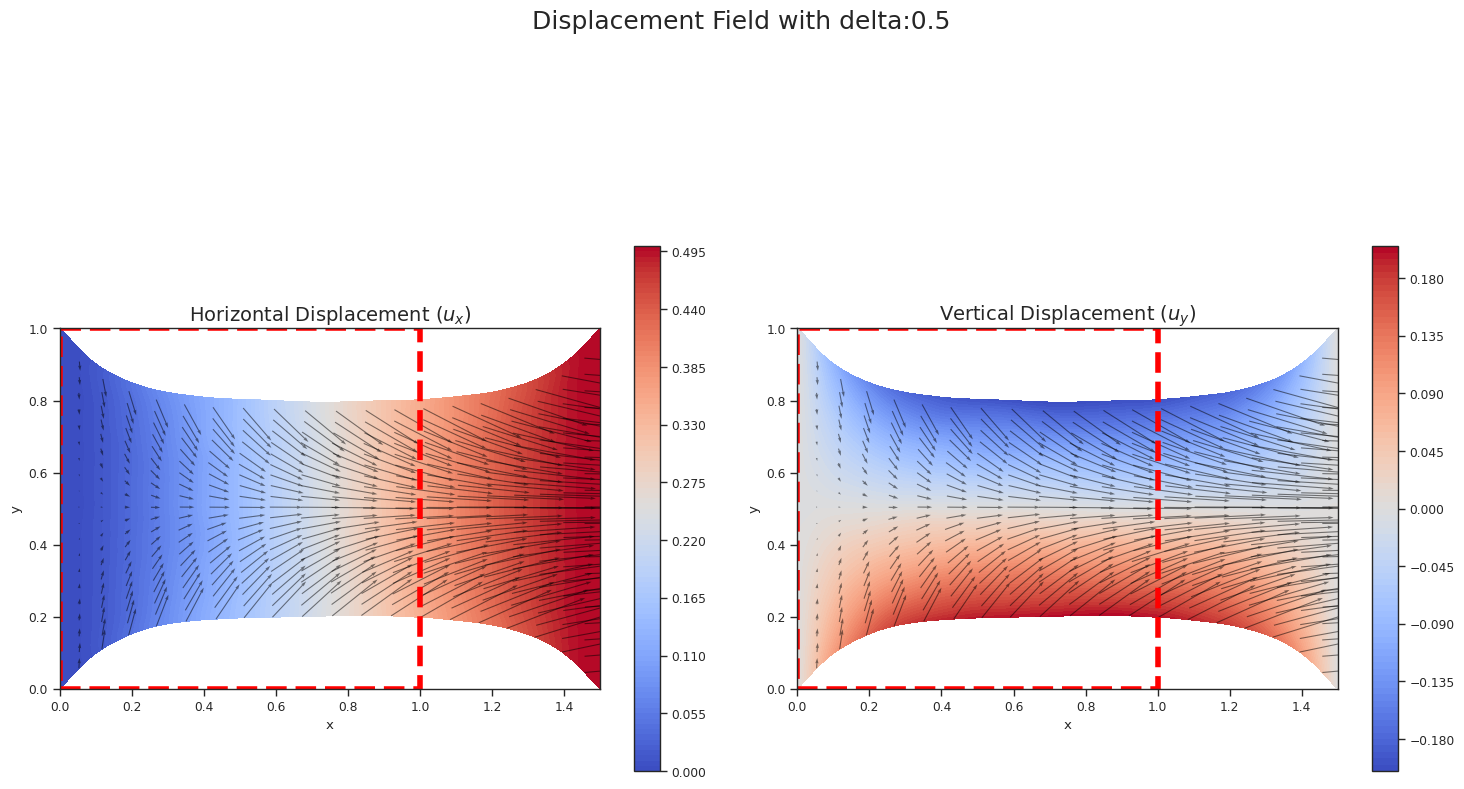

In [82]:
plot_displacement_contour_with_quiver(
    net1, net2,
    right_edge_displacement =0.5,
    scale_network_out=1.0,
    num_samples_X=100,
    quiver_stride=5,
    show_quiver= True
)

## Part C

Solve the parametric problem for $\delta \in [0,0.5]$. That is, build a neural network that takes $\delta$ as input and outputs the displacement field. To do this:
+ Modify the loss function to:

$$
\mathcal{L} = \int_0^{0.5} \int_{[0,1]^2} \left\{\frac{1}{2}(\sum_{i}\sum_{j}{F_{ij}^2} - 2)- \ln(\det(\mathbf{F})) + 50\ln(\det(\mathbf{F}))^2\right\} dxdy d\delta.
$$

+ Modify the neural networks to take $\delta$ as input, say $N_1(x,y;\delta;\theta)$ and $N_2(x,y;\delta;\theta)$. Your field will be $\mathbf{u}(x,y;\delta;\theta)$.
Use the following architecture for the neural networks:

$$
N_1(x,y;\delta) = \sum_{i=1}^n b_{1,i}(\delta)t_{1,i}(x,y).
$$

Here, $n$ is your choice (start with $n=10$), $b_{1,i}$ is a neural network that takes $\delta$ as input and outputs a scalar, and $t_{1,i}(x,y)$ is a multi-layer perceptron with 3 hidden layers, each with 128 units, and tanh activations, and Fourier features at the beginning. The same applies to $N_2(x,y;\delta)$. This representation resembles an expansion in terms of basis functions.
The same architecture appears in DeepONet.

Plot the $x$ and $y$ displacement at $x=0.5, y=0.5$ as a function of $\delta$.

*Put your answer here. Use as many markdown and code blocks as you want.*

In [83]:
# Fourier embedding of (x,y,delta)
class FourierFeatures(eqx.Module):
    B: jnp.ndarray
    def __init__(self, input_dim=3, mapping_size=256, scale=3.0, key=None):
        key = jax.random.PRNGKey(0) if key is None else key
        # B shape (mapping_size, input_dim)
        self.B = jax.random.normal(key, (mapping_size, input_dim)) * scale
    def __call__(self, x):
        # x: (...,3)
        proj = 2 * jnp.pi * (x @ self.B.T)
        return jnp.concatenate([jnp.sin(proj), jnp.cos(proj)], axis=-1)


# MLP that takes (x,y,delta)→ (r1,r2)
class ParamNet(eqx.Module):
    fft: FourierFeatures
    layers: tuple

    def __init__(self,
                 mapping_size=256,
                 hidden_dim=128,
                 hidden_layers=3,
                 scale=3.0,
                 key=None):

        key = jax.random.PRNGKey(1) if key is None else key
        kf, *kl = jax.random.split(key, hidden_layers + 2)

        # Fourier embed for input_dim=3
        self.fft = FourierFeatures(3, mapping_size, scale, key=kf)

        # build a simple MLP
        dims = [2 * mapping_size] + [hidden_dim] * hidden_layers + [2]
        self.layers = tuple(
            eqx.nn.Linear(d0, d1, key=kl[i])
            for i, (d0, d1) in enumerate(zip(dims[:-1], dims[1:]))
        )

    def __call__(self, x):
        # x: (...,3)
        h = self.fft(x)
        for layer in self.layers[:-1]:
            h = jnp.tanh(layer(h))
        return self.layers[-1](h)

# Pointwise displacement and energy
def disp_point(delta_xy, net):
    """
    delta_xy: (3,) vector = [x, y, delta]
    net: ParamNet
    returns: u = [u1, u2] at that point
    """
    x, y, delta = delta_xy
    # forward pass
    r1, r2 = net(jnp.array([x, y, delta]))  # (2,)
    u1 = delta - delta * (1 - x) + x * (1 - x) * r1
    u2 =        x * (1 - x) * r2
    return jnp.array([u1, u2])

def energy_point(delta_xy, net):
    """
    Compute energy density at a single sample ([x,y,delta], net).
    """
    # Compute jacobian of disp_point
    J = jax.jacfwd(lambda z: disp_point(z, net))(delta_xy)  # (2,3)
    # Only spatial part
    F11 = 1 + J[0,0]
    F12 =     J[0,1]
    F21 =     J[1,0]
    F22 = 1 + J[1,1]
    # Invariants
    F2   = F11**2 + F12**2 + F21**2 + F22**2
    detF = F11*F22 - F12*F21
    ld   = jnp.log(jnp.clip(detF, 1e-6))

    # Energy density
    return 0.5*(F2 - 2) - ld + 50 * ld**2

# vectorize over a batch of [x,y,delta] rows
v_energy = jax.vmap(energy_point, in_axes=(0, None))

In [84]:
# Loss & gradiant
def loss_fn(net, xy, delta):
    """
    xy: (B,2), delta: (B,1)
    """
    # stack to shape (B,3)
    data = jnp.concatenate([xy, delta], axis=1)
    eds  = v_energy(data, net)        # (B,)
    return jnp.mean(eds)

# JIT‑compile loss + gradient w.r.t. net
compute_loss_and_grad = jax.jit(jax.value_and_grad(loss_fn, argnums=0))


def train_paramnet(
    iters= int,
    batch=int,
    lr=int,
    seed=int,
    delta_min=float,
    delta_max=float,
    log_every=10,
):
    key = jax.random.PRNGKey(seed)
    net = ParamNet(key=key)
    optimizer = optax.adam(lr)
    opt_state = optimizer.init(net)

    loss_history = []
    start_time = time.time()
    pbar = trange(iters, desc="Training", leave=True)

    for i in pbar:
        key, kxy, kd = jax.random.split(key, 3)
        xy = jax.random.uniform(kxy, (batch, 2))
        delta  = jax.random.uniform(kd,  (batch, 1),
                                minval=delta_min,
                                maxval=delta_max)

        loss, grads = compute_loss_and_grad(net, xy, delta)
        updates, opt_state = optimizer.update(grads, opt_state)
        net = eqx.apply_updates(net, updates)

        loss_history.append(loss.item())

        if i % log_every == 0 or i == iters - 1:
            elapsed = int(time.time() - start_time)
            pbar.write(f"[iter: {i:4d}] time elapsed: {elapsed:4d}s  |  Loss = {loss:.6f}")

    return net, loss_history


In [85]:
# Begin Training
MAX_ITER = 10_000
LEARNING_RATE = 5e-4
BATCH = 128
SEED = 10
LOG = 100
DELTA_MIN = 0.0
DELTA_MAX = 0.5

net, loss_hist = train_paramnet(
    iters=MAX_ITER,
    batch=BATCH,
    lr=LEARNING_RATE,
    seed=SEED,
    delta_min=DELTA_MIN,
    delta_max=DELTA_MAX,
    log_every=LOG,
)

Training:   0%|          | 8/10000 [00:01<26:29,  6.29it/s]  

[iter:    0] time elapsed:    1s  |  Loss = 6.975414


Training:   1%|          | 109/10000 [00:03<02:28, 66.77it/s]

[iter:  100] time elapsed:    3s  |  Loss = 2.266402


Training:   2%|▏         | 208/10000 [00:04<02:29, 65.44it/s]

[iter:  200] time elapsed:    4s  |  Loss = 1.422154


Training:   3%|▎         | 315/10000 [00:06<02:20, 68.79it/s]

[iter:  300] time elapsed:    6s  |  Loss = 0.693476


Training:   4%|▍         | 409/10000 [00:07<02:17, 69.83it/s]

[iter:  400] time elapsed:    7s  |  Loss = 0.659638


Training:   5%|▌         | 512/10000 [00:09<02:19, 68.17it/s]

[iter:  500] time elapsed:    8s  |  Loss = 0.563266


Training:   6%|▌         | 615/10000 [00:10<02:13, 70.06it/s]

[iter:  600] time elapsed:   10s  |  Loss = 0.372958


Training:   7%|▋         | 710/10000 [00:11<02:15, 68.52it/s]

[iter:  700] time elapsed:   11s  |  Loss = 0.430087


Training:   8%|▊         | 814/10000 [00:13<02:12, 69.17it/s]

[iter:  800] time elapsed:   13s  |  Loss = 0.363055


Training:   9%|▉         | 911/10000 [00:14<02:10, 69.80it/s]

[iter:  900] time elapsed:   14s  |  Loss = 0.342151


Training:  10%|█         | 1011/10000 [00:16<02:16, 66.04it/s]

[iter: 1000] time elapsed:   16s  |  Loss = 0.403968


Training:  11%|█         | 1109/10000 [00:17<02:15, 65.40it/s]

[iter: 1100] time elapsed:   17s  |  Loss = 0.320001


Training:  12%|█▏        | 1212/10000 [00:19<02:08, 68.65it/s]

[iter: 1200] time elapsed:   19s  |  Loss = 0.277757


Training:  13%|█▎        | 1314/10000 [00:20<02:10, 66.36it/s]

[iter: 1300] time elapsed:   20s  |  Loss = 0.284806


Training:  14%|█▍        | 1408/10000 [00:22<02:04, 69.27it/s]

[iter: 1400] time elapsed:   22s  |  Loss = 0.309923


Training:  15%|█▌        | 1512/10000 [00:23<02:00, 70.70it/s]

[iter: 1500] time elapsed:   23s  |  Loss = 0.291447


Training:  16%|█▌        | 1615/10000 [00:25<01:59, 70.14it/s]

[iter: 1600] time elapsed:   24s  |  Loss = 0.334177


Training:  17%|█▋        | 1711/10000 [00:26<01:56, 71.03it/s]

[iter: 1700] time elapsed:   26s  |  Loss = 0.309906


Training:  18%|█▊        | 1807/10000 [00:27<01:55, 70.74it/s]

[iter: 1800] time elapsed:   27s  |  Loss = 0.266028


Training:  19%|█▉        | 1913/10000 [00:29<01:59, 67.54it/s]

[iter: 1900] time elapsed:   29s  |  Loss = 0.238199


Training:  20%|██        | 2012/10000 [00:30<01:53, 70.35it/s]

[iter: 2000] time elapsed:   30s  |  Loss = 0.277330


Training:  21%|██        | 2111/10000 [00:32<01:54, 69.11it/s]

[iter: 2100] time elapsed:   32s  |  Loss = 0.266410


Training:  22%|██▏       | 2208/10000 [00:33<01:53, 68.58it/s]

[iter: 2200] time elapsed:   33s  |  Loss = 0.221738


Training:  23%|██▎       | 2311/10000 [00:35<01:51, 68.92it/s]

[iter: 2300] time elapsed:   34s  |  Loss = 0.245441


Training:  24%|██▍       | 2412/10000 [00:36<01:50, 68.84it/s]

[iter: 2400] time elapsed:   36s  |  Loss = 0.219929


Training:  25%|██▌       | 2513/10000 [00:38<01:52, 66.71it/s]

[iter: 2500] time elapsed:   37s  |  Loss = 0.219664


Training:  26%|██▌       | 2612/10000 [00:39<01:50, 67.16it/s]

[iter: 2600] time elapsed:   39s  |  Loss = 0.276234


Training:  27%|██▋       | 2710/10000 [00:41<01:51, 65.54it/s]

[iter: 2700] time elapsed:   40s  |  Loss = 0.223413


Training:  28%|██▊       | 2810/10000 [00:42<01:44, 68.78it/s]

[iter: 2800] time elapsed:   42s  |  Loss = 0.249741


Training:  29%|██▉       | 2912/10000 [00:43<01:45, 67.50it/s]

[iter: 2900] time elapsed:   43s  |  Loss = 0.199851


Training:  30%|███       | 3010/10000 [00:45<01:44, 67.15it/s]

[iter: 3000] time elapsed:   45s  |  Loss = 0.242497


Training:  31%|███       | 3108/10000 [00:46<01:38, 70.16it/s]

[iter: 3100] time elapsed:   46s  |  Loss = 0.198770


Training:  32%|███▏      | 3209/10000 [00:48<01:37, 69.49it/s]

[iter: 3200] time elapsed:   48s  |  Loss = 0.220638


Training:  33%|███▎      | 3311/10000 [00:49<01:36, 69.05it/s]

[iter: 3300] time elapsed:   49s  |  Loss = 0.204143


Training:  34%|███▍      | 3413/10000 [00:51<01:34, 69.62it/s]

[iter: 3400] time elapsed:   51s  |  Loss = 0.198645


Training:  35%|███▌      | 3510/10000 [00:52<01:36, 67.21it/s]

[iter: 3500] time elapsed:   52s  |  Loss = 0.208536


Training:  36%|███▌      | 3612/10000 [00:54<01:32, 68.84it/s]

[iter: 3600] time elapsed:   53s  |  Loss = 0.234538


Training:  37%|███▋      | 3714/10000 [00:55<01:28, 71.04it/s]

[iter: 3700] time elapsed:   55s  |  Loss = 0.275842


Training:  38%|███▊      | 3809/10000 [00:56<01:28, 69.71it/s]

[iter: 3800] time elapsed:   56s  |  Loss = 0.207068


Training:  39%|███▉      | 3913/10000 [00:58<01:26, 70.60it/s]

[iter: 3900] time elapsed:   58s  |  Loss = 0.185426


Training:  40%|████      | 4008/10000 [00:59<01:26, 69.19it/s]

[iter: 4000] time elapsed:   59s  |  Loss = 0.230108


Training:  41%|████      | 4114/10000 [01:01<01:25, 69.23it/s]

[iter: 4100] time elapsed:   61s  |  Loss = 0.186751


Training:  42%|████▏     | 4210/10000 [01:02<01:25, 68.10it/s]

[iter: 4200] time elapsed:   62s  |  Loss = 0.173543


Training:  43%|████▎     | 4310/10000 [01:04<01:26, 65.81it/s]

[iter: 4300] time elapsed:   64s  |  Loss = 0.214692


Training:  44%|████▍     | 4408/10000 [01:05<01:26, 65.01it/s]

[iter: 4400] time elapsed:   65s  |  Loss = 0.180928


Training:  45%|████▌     | 4510/10000 [01:07<01:18, 69.92it/s]

[iter: 4500] time elapsed:   66s  |  Loss = 0.188053


Training:  46%|████▌     | 4611/10000 [01:08<01:18, 68.57it/s]

[iter: 4600] time elapsed:   68s  |  Loss = 0.246614


Training:  47%|████▋     | 4711/10000 [01:10<01:18, 67.09it/s]

[iter: 4700] time elapsed:   69s  |  Loss = 0.217733


Training:  48%|████▊     | 4811/10000 [01:11<01:15, 68.51it/s]

[iter: 4800] time elapsed:   71s  |  Loss = 0.191930


Training:  49%|████▉     | 4912/10000 [01:12<01:13, 68.82it/s]

[iter: 4900] time elapsed:   72s  |  Loss = 0.203429


Training:  50%|█████     | 5007/10000 [01:14<01:11, 70.23it/s]

[iter: 5000] time elapsed:   74s  |  Loss = 0.181583


Training:  51%|█████     | 5111/10000 [01:15<01:11, 68.21it/s]

[iter: 5100] time elapsed:   75s  |  Loss = 0.194444


Training:  52%|█████▏    | 5210/10000 [01:17<01:11, 66.86it/s]

[iter: 5200] time elapsed:   77s  |  Loss = 0.202548


Training:  53%|█████▎    | 5309/10000 [01:18<01:08, 68.30it/s]

[iter: 5300] time elapsed:   78s  |  Loss = 0.189491


Training:  54%|█████▍    | 5407/10000 [01:20<01:07, 68.38it/s]

[iter: 5400] time elapsed:   80s  |  Loss = 0.196240


Training:  55%|█████▌    | 5514/10000 [01:21<01:05, 68.53it/s]

[iter: 5500] time elapsed:   81s  |  Loss = 0.186808


Training:  56%|█████▌    | 5614/10000 [01:23<01:03, 68.54it/s]

[iter: 5600] time elapsed:   82s  |  Loss = 0.217875


Training:  57%|█████▋    | 5712/10000 [01:24<01:02, 68.23it/s]

[iter: 5700] time elapsed:   84s  |  Loss = 0.186677


Training:  58%|█████▊    | 5813/10000 [01:26<01:01, 68.12it/s]

[iter: 5800] time elapsed:   85s  |  Loss = 0.193210


Training:  59%|█████▉    | 5911/10000 [01:27<01:00, 67.97it/s]

[iter: 5900] time elapsed:   87s  |  Loss = 0.169932


Training:  60%|██████    | 6012/10000 [01:28<01:00, 66.11it/s]

[iter: 6000] time elapsed:   88s  |  Loss = 0.210059


Training:  61%|██████    | 6112/10000 [01:30<00:56, 69.00it/s]

[iter: 6100] time elapsed:   90s  |  Loss = 0.178634


Training:  62%|██████▏   | 6209/10000 [01:31<00:53, 71.15it/s]

[iter: 6200] time elapsed:   91s  |  Loss = 0.189852


Training:  63%|██████▎   | 6308/10000 [01:33<00:54, 68.11it/s]

[iter: 6300] time elapsed:   93s  |  Loss = 0.181345


Training:  64%|██████▍   | 6412/10000 [01:34<00:52, 68.60it/s]

[iter: 6400] time elapsed:   94s  |  Loss = 0.186000


Training:  65%|██████▌   | 6512/10000 [01:36<00:51, 67.43it/s]

[iter: 6500] time elapsed:   96s  |  Loss = 0.173780


Training:  66%|██████▌   | 6608/10000 [01:37<00:49, 68.13it/s]

[iter: 6600] time elapsed:   97s  |  Loss = 0.181046


Training:  67%|██████▋   | 6708/10000 [01:39<00:49, 67.08it/s]

[iter: 6700] time elapsed:   99s  |  Loss = 0.169454


Training:  68%|██████▊   | 6808/10000 [01:40<00:50, 62.84it/s]

[iter: 6800] time elapsed:  100s  |  Loss = 0.153470


Training:  69%|██████▉   | 6913/10000 [01:42<00:46, 66.09it/s]

[iter: 6900] time elapsed:  102s  |  Loss = 0.206153


Training:  70%|███████   | 7010/10000 [01:43<00:42, 71.09it/s]

[iter: 7000] time elapsed:  103s  |  Loss = 0.174186


Training:  71%|███████   | 7113/10000 [01:45<00:41, 69.62it/s]

[iter: 7100] time elapsed:  104s  |  Loss = 0.256091


Training:  72%|███████▏  | 7215/10000 [01:46<00:39, 70.23it/s]

[iter: 7200] time elapsed:  106s  |  Loss = 0.187013


Training:  73%|███████▎  | 7311/10000 [01:47<00:38, 70.34it/s]

[iter: 7300] time elapsed:  107s  |  Loss = 0.195503


Training:  74%|███████▍  | 7415/10000 [01:49<00:36, 70.33it/s]

[iter: 7400] time elapsed:  109s  |  Loss = 0.165562


Training:  75%|███████▌  | 7511/10000 [01:50<00:35, 70.43it/s]

[iter: 7500] time elapsed:  110s  |  Loss = 0.142445


Training:  76%|███████▌  | 7614/10000 [01:52<00:34, 68.99it/s]

[iter: 7600] time elapsed:  112s  |  Loss = 0.199618


Training:  77%|███████▋  | 7712/10000 [01:53<00:34, 66.56it/s]

[iter: 7700] time elapsed:  113s  |  Loss = 0.160891


Training:  78%|███████▊  | 7811/10000 [01:55<00:31, 69.74it/s]

[iter: 7800] time elapsed:  114s  |  Loss = 0.154555


Training:  79%|███████▉  | 7915/10000 [01:56<00:30, 69.40it/s]

[iter: 7900] time elapsed:  116s  |  Loss = 0.206856


Training:  80%|████████  | 8010/10000 [01:57<00:28, 68.68it/s]

[iter: 8000] time elapsed:  117s  |  Loss = 0.190223


Training:  81%|████████  | 8114/10000 [01:59<00:27, 69.20it/s]

[iter: 8100] time elapsed:  119s  |  Loss = 0.219380


Training:  82%|████████▏ | 8214/10000 [02:00<00:26, 68.05it/s]

[iter: 8200] time elapsed:  120s  |  Loss = 0.186116


Training:  83%|████████▎ | 8313/10000 [02:02<00:24, 68.83it/s]

[iter: 8300] time elapsed:  122s  |  Loss = 0.155914


Training:  84%|████████▍ | 8411/10000 [02:03<00:22, 69.42it/s]

[iter: 8400] time elapsed:  123s  |  Loss = 0.165781


Training:  85%|████████▌ | 8510/10000 [02:05<00:23, 64.34it/s]

[iter: 8500] time elapsed:  125s  |  Loss = 0.178207


Training:  86%|████████▌ | 8608/10000 [02:06<00:21, 65.41it/s]

[iter: 8600] time elapsed:  126s  |  Loss = 0.186876


Training:  87%|████████▋ | 8714/10000 [02:08<00:19, 67.10it/s]

[iter: 8700] time elapsed:  128s  |  Loss = 0.183467


Training:  88%|████████▊ | 8808/10000 [02:09<00:17, 67.20it/s]

[iter: 8800] time elapsed:  129s  |  Loss = 0.177436


Training:  89%|████████▉ | 8909/10000 [02:11<00:16, 67.47it/s]

[iter: 8900] time elapsed:  131s  |  Loss = 0.197870


Training:  90%|█████████ | 9014/10000 [02:12<00:14, 65.85it/s]

[iter: 9000] time elapsed:  132s  |  Loss = 0.205613


Training:  91%|█████████ | 9114/10000 [02:14<00:13, 67.77it/s]

[iter: 9100] time elapsed:  134s  |  Loss = 0.179193


Training:  92%|█████████▏| 9213/10000 [02:15<00:11, 67.95it/s]

[iter: 9200] time elapsed:  135s  |  Loss = 0.165924


Training:  93%|█████████▎| 9311/10000 [02:17<00:10, 65.66it/s]

[iter: 9300] time elapsed:  137s  |  Loss = 0.161696


Training:  94%|█████████▍| 9409/10000 [02:18<00:08, 66.37it/s]

[iter: 9400] time elapsed:  138s  |  Loss = 0.173836


Training:  95%|█████████▌| 9509/10000 [02:20<00:07, 67.21it/s]

[iter: 9500] time elapsed:  140s  |  Loss = 0.177550


Training:  96%|█████████▌| 9610/10000 [02:21<00:05, 68.10it/s]

[iter: 9600] time elapsed:  141s  |  Loss = 0.162987


Training:  97%|█████████▋| 9708/10000 [02:23<00:04, 66.79it/s]

[iter: 9700] time elapsed:  143s  |  Loss = 0.160042


Training:  98%|█████████▊| 9811/10000 [02:24<00:02, 69.10it/s]

[iter: 9800] time elapsed:  144s  |  Loss = 0.161081


Training:  99%|█████████▉| 9914/10000 [02:26<00:01, 69.21it/s]

[iter: 9900] time elapsed:  145s  |  Loss = 0.169776


Training: 100%|██████████| 10000/10000 [02:27<00:00, 67.85it/s]

[iter: 9999] time elapsed:  147s  |  Loss = 0.155904


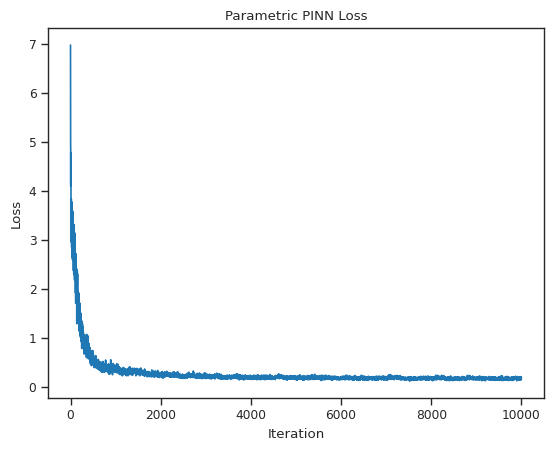

Initial Loss: 6.975414
Final Loss: 0.155904


In [86]:
# loss curve
plt.plot(loss_hist)
plt.yscale('linear')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Parametric PINN Loss")
plt.show()
print(f"Initial Loss: {loss_hist[0]:.6f}")
print(f"Final Loss: {loss_hist[-1]:.6f}")

Plot the $x$ and $y$ displacement at $x=0.5, y=0.5$ as a function of $\delta$.

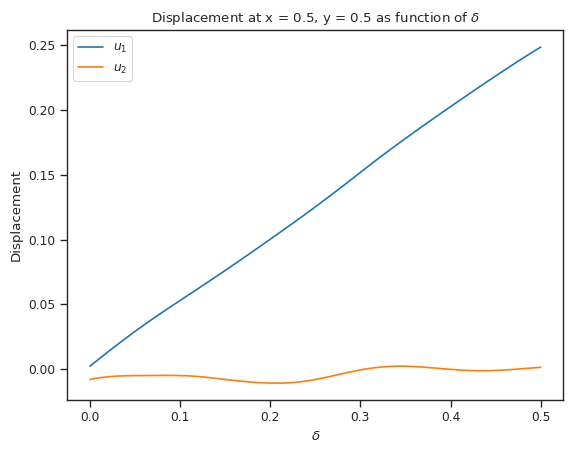

In [87]:
# center displacement vs delta
deltas   = jnp.linspace(0, 0.5, 100)[:, None]
xy_50 = jnp.tile(jnp.array([[0.5, 0.5]]), (100,1))  # (100,2)

# compute u1,u2 at center
def eval_u(xy, delta):
    return disp_point(jnp.concatenate([xy, delta]), net)
u_mid = jnp.stack([eval_u(xy_50[i], deltas[i]) for i in range(100)])
plt.plot(deltas.flatten(), u_mid[:,0], label='$u_1$')
plt.plot(deltas.flatten(), u_mid[:,1], label='$u_2$')
plt.xlabel('$\\delta$'); plt.ylabel('Displacement'); plt.legend()
plt.title('Displacement at x = 0.5, y = 0.5 as function of $\\delta$')
plt.show()

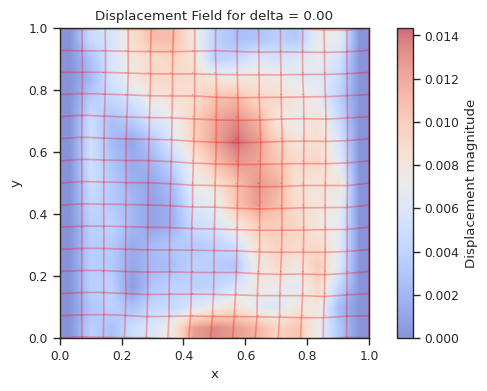

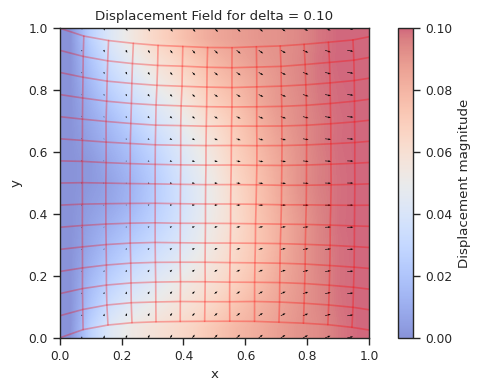

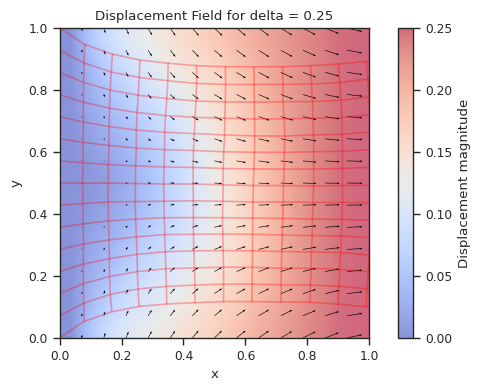

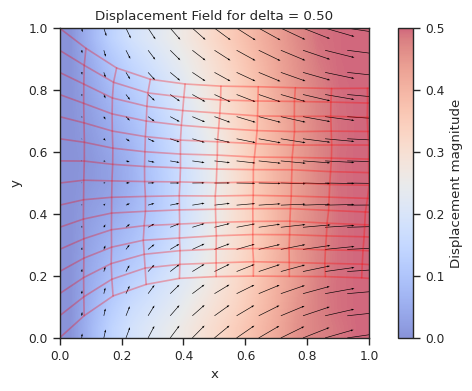

In [88]:
def plot_displacement_field(net, delta, resolution=20):
    # Create grid
    x = np.linspace(0, 1, resolution)
    y = np.linspace(0, 1, resolution)
    X, Y = np.meshgrid(x, y)

    # Compute displacements
    pts = np.stack([X.flatten(), Y.flatten()], axis=1)
    disp = []
    for p in pts:
        inp = jnp.concatenate([jnp.array(p), jnp.array([delta])])
        disp.append(disp_point(inp, net))
    disp = jnp.stack(disp)
    U = np.array(disp[:,0]).reshape(resolution, resolution)
    V = np.array(disp[:,1]).reshape(resolution, resolution)

    # Magnitude for contours
    mag = np.sqrt(U**2 + V**2)

    fig, ax = plt.subplots(figsize=(6,4))
    cf = ax.imshow(
        mag,
        extent=(0, 1, 0, 1),
        origin='lower',
        cmap='coolwarm',
        interpolation='bilinear',  # ← silky smooth
        alpha=0.6,
        zorder=0
    )
    cbar = fig.colorbar(cf, ax=ax)
    cbar.set_label('Displacement magnitude')

    stride = max(1, resolution // 10)
    q = ax.quiver(
        X[::stride, ::stride], Y[::stride, ::stride],
        U[::stride, ::stride], V[::stride, ::stride],
        color='k',
        angles='xy',
        scale_units='xy',
        scale=5,
        width=0.002,
        headwidth=3,
        headlength=4,
        zorder=1
    )

    # deformed grid in red
    Xd = X + U
    Yd = Y + V
    for i in range(0, resolution, stride):
        ax.plot(Xd[i,:], Yd[i,:], 'r-', alpha=0.3)
        ax.plot(Xd[:,i], Yd[:,i], 'r-', alpha=0.3)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f'Displacement Field for delta = {delta:.2f}')
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)

    return fig

for delta in [0.0, 0.1, 0.25, 0.5]:
    fig = plot_displacement_field(net, delta, resolution=15)
    plt.tight_layout()
    plt.show()


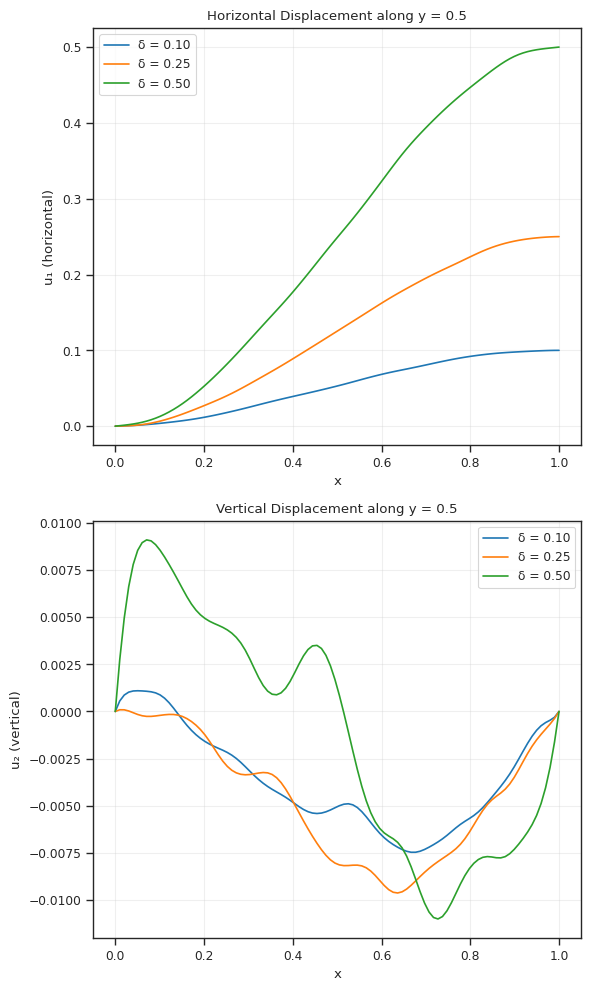

In [89]:
# Displacement profiles along cross-sections
def plot_displacement_profiles(net, delta_values=[0.1, 0.25, 0.5], resolution=100):
    # Create points along x-axis at y=0.5
    x_points = np.linspace(0, 1, resolution)
    y_value = 0.5

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 10))

    for delta in delta_values:
        u1_values = []
        u2_values = []

        # Compute displacements
        for x in x_points:
            point = jnp.array([x, y_value, delta])
            u = disp_point(point, net)
            u1_values.append(u[0])
            u2_values.append(u[1])

        # Plot u1 (horizontal displacement)
        ax1.plot(x_points, u1_values, label=f'δ = {delta:.2f}')

        # Plot u2 (vertical displacement)
        ax2.plot(x_points, u2_values, label=f'δ = {delta:.2f}')

    # Configure plots
    ax1.set_xlabel('x')
    ax1.set_ylabel('u₁ (horizontal)')
    ax1.set_title('Horizontal Displacement along y = 0.5')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2.set_xlabel('x')
    ax2.set_ylabel('u₂ (vertical)')
    ax2.set_title('Vertical Displacement along y = 0.5')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Plot displacement profiles
plot_displacement_profiles(net)